In [32]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d, langevin_dynamics_lsd, visualize, langevin_dynamics_lsd_3d
import importlib
import argparse
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/base/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=100, save_dir='log/test-toy-2d', save_freq=1000, val_freq=500, viz_freq=500), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=5, epochs=15000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters

In [39]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
#     plt.scatter(x[:, 0], x[:, 1])
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

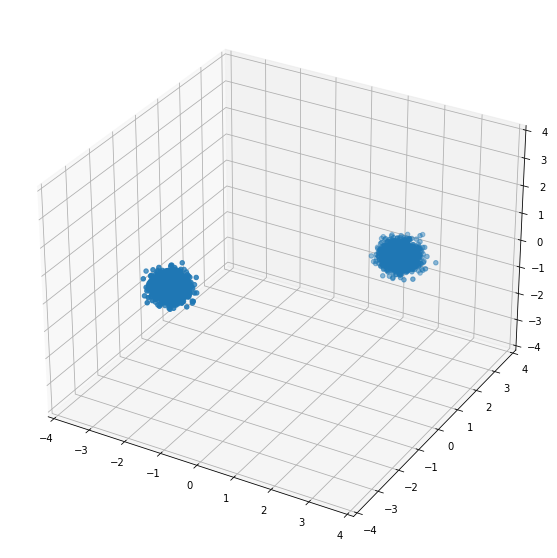

In [41]:
data = sample_data('multi_modal_gaussian_3d', 2048)
visualize(data)

In [42]:
score_net = SmallMLP(n_dims=3, n_out=3)
critic_net = SmallMLP(n_dims=3, n_out=3)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 5
e_iters = 1
epochs = 20000
itr = 0

losses = []

for epoch in range(epochs):
    tr_pts = sample_data('multi_modal_gaussian_3d', 4096).view(-1, 3)
    
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()

    tr_pts.requires_grad_()
    batch_size = tr_pts.size(0)

    perturbed_points = tr_pts

    score_pred = score_net(perturbed_points)

    critic_output = critic_net(perturbed_points)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)

    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()

    losses.append(loss)

    cycle_iter = itr % (k_iters + e_iters)

    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()

    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

#     if itr % cfg.log.save_freq == 0:
#         score_net.cpu()

#         torch.save({
#             'args': args,
#             'state_dict': score_net.state_dict(),
#         }, os.path.join(cfg.log.save_dir, 'checkpt.pth'))

#         score_net.to(device)

#     if itr % cfg.log.viz_freq == 0:
#         plt.clf()

#         #pt_cl, _ = langevin_dynamics(score_net, sigmas, dim=2, eps=1e-4, num_steps=cfg.inference.num_steps)
#         x_final = langevin_dynamics_lsd(score_net, l=1., e=.01, num_points=2048, n_steps=10)

#         visualize_2d(x_final)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'sample-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)


#         visualize_2d(perturbed_points)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'perturbed-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)

#     itr += 1

Epoch 0 (critic), Loss=-0.02051 t1=0.00057 t2=-0.02108
Epoch 1 (critic), Loss=0.40503 t1=0.02528 t2=0.37975
Epoch 2 (critic), Loss=0.77084 t1=0.04120 t2=0.72964
Epoch 3 (critic), Loss=1.07354 t1=0.04637 t2=1.02717
Epoch 4 (critic), Loss=1.35635 t1=0.04616 t2=1.31019
Epoch 5 (score), Loss=1.64668 t1=0.04168 t2=1.60500
Epoch 6 (critic), Loss=1.51038 t1=-0.09562 t2=1.60601
Epoch 7 (critic), Loss=1.86355 t1=-0.02932 t2=1.89287
Epoch 8 (critic), Loss=2.23799 t1=0.03435 t2=2.20365
Epoch 9 (critic), Loss=2.64168 t1=0.08153 t2=2.56015
Epoch 10 (critic), Loss=3.07252 t1=0.10082 t2=2.97170
Epoch 11 (score), Loss=3.53575 t1=0.09409 t2=3.44166
Epoch 12 (critic), Loss=3.51677 t1=0.07501 t2=3.44176
Epoch 13 (critic), Loss=4.02026 t1=0.05378 t2=3.96648
Epoch 14 (critic), Loss=4.56482 t1=0.02667 t2=4.53815
Epoch 15 (critic), Loss=5.15827 t1=-0.00711 t2=5.16538
Epoch 16 (critic), Loss=5.80098 t1=-0.03750 t2=5.83847
Epoch 17 (score), Loss=6.49811 t1=-0.05950 t2=6.55761
Epoch 18 (critic), Loss=6.46007 t1

Epoch 149 (score), Loss=27.84103 t1=-3.84609 t2=31.68711
Epoch 150 (critic), Loss=27.31684 t1=-4.39402 t2=31.71086
Epoch 151 (critic), Loss=27.31645 t1=-4.35242 t2=31.66887
Epoch 152 (critic), Loss=27.60782 t1=-4.04982 t2=31.65764
Epoch 153 (critic), Loss=27.66400 t1=-3.99375 t2=31.65775
Epoch 154 (critic), Loss=27.57219 t1=-4.09134 t2=31.66352
Epoch 155 (score), Loss=27.54012 t1=-4.06178 t2=31.60189
Epoch 156 (critic), Loss=27.18858 t1=-4.40237 t2=31.59096
Epoch 157 (critic), Loss=27.08175 t1=-4.52314 t2=31.60489
Epoch 158 (critic), Loss=27.47348 t1=-4.09162 t2=31.56510
Epoch 159 (critic), Loss=27.66034 t1=-3.83868 t2=31.49902
Epoch 160 (critic), Loss=27.66724 t1=-3.79249 t2=31.45974
Epoch 161 (score), Loss=27.33261 t1=-4.11590 t2=31.44851
Epoch 162 (critic), Loss=26.96428 t1=-4.46746 t2=31.43174
Epoch 163 (critic), Loss=26.86653 t1=-4.57980 t2=31.44634
Epoch 164 (critic), Loss=26.70578 t1=-4.63221 t2=31.33800
Epoch 165 (critic), Loss=26.98457 t1=-4.24676 t2=31.23133
Epoch 166 (critic

Epoch 299 (score), Loss=12.31398 t1=-3.76932 t2=16.08331
Epoch 300 (critic), Loss=12.37930 t1=-3.68901 t2=16.06831
Epoch 301 (critic), Loss=12.29774 t1=-3.69620 t2=15.99394
Epoch 302 (critic), Loss=12.34826 t1=-3.50653 t2=15.85478
Epoch 303 (critic), Loss=12.30821 t1=-3.41964 t2=15.72785
Epoch 304 (critic), Loss=12.34292 t1=-3.26026 t2=15.60319
Epoch 305 (score), Loss=12.38561 t1=-3.06480 t2=15.45041
Epoch 306 (critic), Loss=12.37148 t1=-3.07904 t2=15.45053
Epoch 307 (critic), Loss=12.43095 t1=-2.86769 t2=15.29864
Epoch 308 (critic), Loss=12.45330 t1=-2.71908 t2=15.17238
Epoch 309 (critic), Loss=12.45637 t1=-2.59566 t2=15.05203
Epoch 310 (critic), Loss=12.40646 t1=-2.54659 t2=14.95304
Epoch 311 (score), Loss=12.31517 t1=-2.52865 t2=14.84382
Epoch 312 (critic), Loss=12.20845 t1=-2.63431 t2=14.84277
Epoch 313 (critic), Loss=12.34571 t1=-2.37911 t2=14.72482
Epoch 314 (critic), Loss=12.43708 t1=-2.14379 t2=14.58087
Epoch 315 (critic), Loss=12.58067 t1=-1.87413 t2=14.45480
Epoch 316 (critic

Epoch 449 (score), Loss=13.60233 t1=7.94110 t2=5.66123
Epoch 450 (critic), Loss=13.38387 t1=7.72065 t2=5.66321
Epoch 451 (critic), Loss=13.55842 t1=7.85283 t2=5.70560
Epoch 452 (critic), Loss=13.39749 t1=7.63546 t2=5.76203
Epoch 453 (critic), Loss=13.57075 t1=7.73779 t2=5.83296
Epoch 454 (critic), Loss=13.39145 t1=7.48059 t2=5.91086
Epoch 455 (score), Loss=13.34582 t1=7.37178 t2=5.97404
Epoch 456 (critic), Loss=13.10956 t1=7.12278 t2=5.98678
Epoch 457 (critic), Loss=13.17789 t1=7.11396 t2=6.06392
Epoch 458 (critic), Loss=13.19328 t1=7.07018 t2=6.12310
Epoch 459 (critic), Loss=13.33294 t1=7.11386 t2=6.21908
Epoch 460 (critic), Loss=13.08653 t1=6.80320 t2=6.28333
Epoch 461 (score), Loss=13.09623 t1=6.74141 t2=6.35482
Epoch 462 (critic), Loss=13.05275 t1=6.69236 t2=6.36040
Epoch 463 (critic), Loss=12.85926 t1=6.40635 t2=6.45292
Epoch 464 (critic), Loss=12.88991 t1=6.35090 t2=6.53901
Epoch 465 (critic), Loss=12.95297 t1=6.34847 t2=6.60449
Epoch 466 (critic), Loss=12.93930 t1=6.26734 t2=6.6

Epoch 599 (score), Loss=12.13916 t1=-1.49068 t2=13.62984
Epoch 600 (critic), Loss=12.09312 t1=-1.54084 t2=13.63396
Epoch 601 (critic), Loss=12.12169 t1=-1.52409 t2=13.64578
Epoch 602 (critic), Loss=12.14970 t1=-1.52230 t2=13.67200
Epoch 603 (critic), Loss=12.15744 t1=-1.58666 t2=13.74410
Epoch 604 (critic), Loss=12.13123 t1=-1.69319 t2=13.82442
Epoch 605 (score), Loss=12.12407 t1=-1.74883 t2=13.87290
Epoch 606 (critic), Loss=12.14220 t1=-1.72337 t2=13.86556
Epoch 607 (critic), Loss=12.16453 t1=-1.72558 t2=13.89012
Epoch 608 (critic), Loss=12.17498 t1=-1.73626 t2=13.91124
Epoch 609 (critic), Loss=12.20828 t1=-1.72642 t2=13.93470
Epoch 610 (critic), Loss=12.18997 t1=-1.79757 t2=13.98754
Epoch 611 (score), Loss=12.17570 t1=-1.87102 t2=14.04672
Epoch 612 (critic), Loss=12.18571 t1=-1.85364 t2=14.03935
Epoch 613 (critic), Loss=12.18756 t1=-1.90800 t2=14.09557
Epoch 614 (critic), Loss=12.19814 t1=-1.90882 t2=14.10697
Epoch 615 (critic), Loss=12.21785 t1=-1.89450 t2=14.11234
Epoch 616 (critic

Epoch 749 (score), Loss=11.57115 t1=-2.69212 t2=14.26326
Epoch 750 (critic), Loss=11.64787 t1=-2.60409 t2=14.25196
Epoch 751 (critic), Loss=11.54694 t1=-2.68892 t2=14.23586
Epoch 752 (critic), Loss=11.48686 t1=-2.67437 t2=14.16122
Epoch 753 (critic), Loss=11.55540 t1=-2.52211 t2=14.07751
Epoch 754 (critic), Loss=11.62316 t1=-2.39667 t2=14.01983
Epoch 755 (score), Loss=11.56190 t1=-2.46361 t2=14.02551
Epoch 756 (critic), Loss=11.47926 t1=-2.54150 t2=14.02077
Epoch 757 (critic), Loss=11.50004 t1=-2.51113 t2=14.01117
Epoch 758 (critic), Loss=11.55957 t1=-2.41044 t2=13.97001
Epoch 759 (critic), Loss=11.44815 t1=-2.39715 t2=13.84530
Epoch 760 (critic), Loss=11.54110 t1=-2.22673 t2=13.76783
Epoch 761 (score), Loss=11.46649 t1=-2.26578 t2=13.73228
Epoch 762 (critic), Loss=11.50404 t1=-2.23463 t2=13.73867
Epoch 763 (critic), Loss=11.44723 t1=-2.27823 t2=13.72546
Epoch 764 (critic), Loss=11.47495 t1=-2.24847 t2=13.72342
Epoch 765 (critic), Loss=11.47403 t1=-2.19596 t2=13.66999
Epoch 766 (critic

Epoch 899 (score), Loss=11.83452 t1=1.83186 t2=10.00266
Epoch 900 (critic), Loss=11.64888 t1=1.64166 t2=10.00722
Epoch 901 (critic), Loss=11.53371 t1=1.55319 t2=9.98052
Epoch 902 (critic), Loss=11.20043 t1=1.20638 t2=9.99405
Epoch 903 (critic), Loss=11.17865 t1=1.18209 t2=9.99655
Epoch 904 (critic), Loss=11.29999 t1=1.33076 t2=9.96922
Epoch 905 (score), Loss=11.50640 t1=1.58732 t2=9.91908
Epoch 906 (critic), Loss=11.37253 t1=1.44940 t2=9.92313
Epoch 907 (critic), Loss=11.45190 t1=1.59535 t2=9.85654
Epoch 908 (critic), Loss=11.15338 t1=1.33621 t2=9.81717
Epoch 909 (critic), Loss=11.00653 t1=1.19127 t2=9.81525
Epoch 910 (critic), Loss=11.03066 t1=1.21195 t2=9.81871
Epoch 911 (score), Loss=11.18789 t1=1.35208 t2=9.83582
Epoch 912 (critic), Loss=10.95823 t1=1.12353 t2=9.83470
Epoch 913 (critic), Loss=11.01013 t1=1.22250 t2=9.78763
Epoch 914 (critic), Loss=11.03414 t1=1.30842 t2=9.72572
Epoch 915 (critic), Loss=10.99802 t1=1.32563 t2=9.67240
Epoch 916 (critic), Loss=10.96605 t1=1.31528 t2=9

Epoch 1049 (score), Loss=9.87430 t1=-1.26831 t2=11.14261
Epoch 1050 (critic), Loss=9.87249 t1=-1.27614 t2=11.14863
Epoch 1051 (critic), Loss=9.85016 t1=-1.31103 t2=11.16119
Epoch 1052 (critic), Loss=9.82253 t1=-1.33790 t2=11.16043
Epoch 1053 (critic), Loss=9.89718 t1=-1.25196 t2=11.14914
Epoch 1054 (critic), Loss=9.92018 t1=-1.24224 t2=11.16242
Epoch 1055 (score), Loss=9.90756 t1=-1.29289 t2=11.20045
Epoch 1056 (critic), Loss=9.86642 t1=-1.33199 t2=11.19841
Epoch 1057 (critic), Loss=9.82855 t1=-1.42567 t2=11.25422
Epoch 1058 (critic), Loss=9.84833 t1=-1.43316 t2=11.28149
Epoch 1059 (critic), Loss=9.77922 t1=-1.51436 t2=11.29358
Epoch 1060 (critic), Loss=9.85448 t1=-1.40924 t2=11.26373
Epoch 1061 (score), Loss=9.81431 t1=-1.43472 t2=11.24903
Epoch 1062 (critic), Loss=9.88340 t1=-1.35921 t2=11.24262
Epoch 1063 (critic), Loss=9.83463 t1=-1.45300 t2=11.28763
Epoch 1064 (critic), Loss=9.77500 t1=-1.58017 t2=11.35517
Epoch 1065 (critic), Loss=9.78703 t1=-1.58850 t2=11.37552
Epoch 1066 (criti

Epoch 1199 (score), Loss=9.16278 t1=-2.85046 t2=12.01324
Epoch 1200 (critic), Loss=9.03930 t1=-2.96509 t2=12.00439
Epoch 1201 (critic), Loss=9.12470 t1=-2.91816 t2=12.04287
Epoch 1202 (critic), Loss=9.11176 t1=-2.95056 t2=12.06232
Epoch 1203 (critic), Loss=9.13435 t1=-2.93659 t2=12.07093
Epoch 1204 (critic), Loss=9.10313 t1=-3.00095 t2=12.10408
Epoch 1205 (score), Loss=9.06956 t1=-3.04946 t2=12.11903
Epoch 1206 (critic), Loss=9.10788 t1=-3.01502 t2=12.12290
Epoch 1207 (critic), Loss=9.04686 t1=-3.09788 t2=12.14473
Epoch 1208 (critic), Loss=9.06017 t1=-3.09207 t2=12.15224
Epoch 1209 (critic), Loss=9.10380 t1=-3.05621 t2=12.16001
Epoch 1210 (critic), Loss=9.07847 t1=-3.10929 t2=12.18776
Epoch 1211 (score), Loss=9.06602 t1=-3.15581 t2=12.22184
Epoch 1212 (critic), Loss=8.94629 t1=-3.28037 t2=12.22666
Epoch 1213 (critic), Loss=9.08477 t1=-3.16106 t2=12.24584
Epoch 1214 (critic), Loss=8.94590 t1=-3.30654 t2=12.25245
Epoch 1215 (critic), Loss=8.99342 t1=-3.26621 t2=12.25963
Epoch 1216 (criti

Epoch 1349 (score), Loss=7.12989 t1=-2.74458 t2=9.87446
Epoch 1350 (critic), Loss=7.03773 t1=-2.83446 t2=9.87219
Epoch 1351 (critic), Loss=7.02599 t1=-2.81853 t2=9.84451
Epoch 1352 (critic), Loss=7.03513 t1=-2.79207 t2=9.82720
Epoch 1353 (critic), Loss=6.99920 t1=-2.81470 t2=9.81390
Epoch 1354 (critic), Loss=7.06989 t1=-2.74727 t2=9.81716
Epoch 1355 (score), Loss=6.97765 t1=-2.84125 t2=9.81890
Epoch 1356 (critic), Loss=6.90149 t1=-2.91618 t2=9.81768
Epoch 1357 (critic), Loss=6.96153 t1=-2.83379 t2=9.79532
Epoch 1358 (critic), Loss=6.90483 t1=-2.86941 t2=9.77423
Epoch 1359 (critic), Loss=6.89531 t1=-2.86544 t2=9.76076
Epoch 1360 (critic), Loss=6.93191 t1=-2.79831 t2=9.73022
Epoch 1361 (score), Loss=6.99935 t1=-2.71181 t2=9.71116
Epoch 1362 (critic), Loss=6.93783 t1=-2.77134 t2=9.70916
Epoch 1363 (critic), Loss=6.88828 t1=-2.83617 t2=9.72445
Epoch 1364 (critic), Loss=6.94606 t1=-2.77577 t2=9.72183
Epoch 1365 (critic), Loss=6.89255 t1=-2.78575 t2=9.67830
Epoch 1366 (critic), Loss=6.90662 

Epoch 1499 (score), Loss=6.08197 t1=-1.16769 t2=7.24966
Epoch 1500 (critic), Loss=5.65689 t1=-1.59162 t2=7.24851
Epoch 1501 (critic), Loss=5.65917 t1=-1.56780 t2=7.22697
Epoch 1502 (critic), Loss=5.60594 t1=-1.63564 t2=7.24158
Epoch 1503 (critic), Loss=5.73285 t1=-1.52724 t2=7.26009
Epoch 1504 (critic), Loss=5.60636 t1=-1.61075 t2=7.21711
Epoch 1505 (score), Loss=5.59740 t1=-1.54032 t2=7.13772
Epoch 1506 (critic), Loss=5.22953 t1=-1.90794 t2=7.13747
Epoch 1507 (critic), Loss=5.15202 t1=-1.92757 t2=7.07959
Epoch 1508 (critic), Loss=5.26408 t1=-1.78344 t2=7.04753
Epoch 1509 (critic), Loss=5.43169 t1=-1.62651 t2=7.05820
Epoch 1510 (critic), Loss=5.46948 t1=-1.57232 t2=7.04180
Epoch 1511 (score), Loss=5.54370 t1=-1.45628 t2=6.99997
Epoch 1512 (critic), Loss=5.58595 t1=-1.41586 t2=7.00181
Epoch 1513 (critic), Loss=5.68176 t1=-1.26542 t2=6.94718
Epoch 1514 (critic), Loss=5.93638 t1=-0.96943 t2=6.90581
Epoch 1515 (critic), Loss=6.09405 t1=-0.77848 t2=6.87253
Epoch 1516 (critic), Loss=6.11677 

Epoch 1649 (score), Loss=3.41653 t1=-2.87075 t2=6.28728
Epoch 1650 (critic), Loss=3.41368 t1=-2.87476 t2=6.28844
Epoch 1651 (critic), Loss=3.48381 t1=-2.81046 t2=6.29427
Epoch 1652 (critic), Loss=3.59762 t1=-2.69877 t2=6.29640
Epoch 1653 (critic), Loss=3.66949 t1=-2.59927 t2=6.26876
Epoch 1654 (critic), Loss=3.89114 t1=-2.34072 t2=6.23187
Epoch 1655 (score), Loss=4.02970 t1=-2.14427 t2=6.17397
Epoch 1656 (critic), Loss=4.06641 t1=-2.10446 t2=6.17087
Epoch 1657 (critic), Loss=4.41230 t1=-1.75274 t2=6.16504
Epoch 1658 (critic), Loss=4.61540 t1=-1.56899 t2=6.18440
Epoch 1659 (critic), Loss=4.93052 t1=-1.26703 t2=6.19755
Epoch 1660 (critic), Loss=5.20439 t1=-0.99287 t2=6.19726
Epoch 1661 (score), Loss=5.54965 t1=-0.62461 t2=6.17426
Epoch 1662 (critic), Loss=5.19160 t1=-0.98370 t2=6.17530
Epoch 1663 (critic), Loss=5.55064 t1=-0.63035 t2=6.18099
Epoch 1664 (critic), Loss=5.62008 t1=-0.57951 t2=6.19958
Epoch 1665 (critic), Loss=5.73061 t1=-0.48639 t2=6.21700
Epoch 1666 (critic), Loss=5.55951 

Epoch 1799 (score), Loss=3.62102 t1=-2.27864 t2=5.89966
Epoch 1800 (critic), Loss=3.17748 t1=-2.72096 t2=5.89844
Epoch 1801 (critic), Loss=2.97914 t1=-2.90359 t2=5.88273
Epoch 1802 (critic), Loss=2.98374 t1=-2.85994 t2=5.84368
Epoch 1803 (critic), Loss=2.90189 t1=-2.90877 t2=5.81067
Epoch 1804 (critic), Loss=2.90599 t1=-2.90258 t2=5.80858
Epoch 1805 (score), Loss=2.71816 t1=-3.10891 t2=5.82708
Epoch 1806 (critic), Loss=2.47535 t1=-3.35260 t2=5.82795
Epoch 1807 (critic), Loss=2.47017 t1=-3.35769 t2=5.82786
Epoch 1808 (critic), Loss=2.34479 t1=-3.45679 t2=5.80159
Epoch 1809 (critic), Loss=2.32240 t1=-3.45806 t2=5.78047
Epoch 1810 (critic), Loss=2.33044 t1=-3.42779 t2=5.75822
Epoch 1811 (score), Loss=2.36583 t1=-3.38043 t2=5.74626
Epoch 1812 (critic), Loss=2.12825 t1=-3.61671 t2=5.74496
Epoch 1813 (critic), Loss=2.09897 t1=-3.66048 t2=5.75946
Epoch 1814 (critic), Loss=2.10669 t1=-3.66660 t2=5.77330
Epoch 1815 (critic), Loss=1.95127 t1=-3.82444 t2=5.77571
Epoch 1816 (critic), Loss=2.05199 

Epoch 1949 (score), Loss=1.75993 t1=-3.28840 t2=5.04834
Epoch 1950 (critic), Loss=1.63524 t1=-3.40726 t2=5.04251
Epoch 1951 (critic), Loss=1.63039 t1=-3.34875 t2=4.97914
Epoch 1952 (critic), Loss=1.63436 t1=-3.28958 t2=4.92394
Epoch 1953 (critic), Loss=1.68337 t1=-3.19046 t2=4.87383
Epoch 1954 (critic), Loss=1.66860 t1=-3.15615 t2=4.82475
Epoch 1955 (score), Loss=1.75963 t1=-3.01665 t2=4.77628
Epoch 1956 (critic), Loss=1.48642 t1=-3.28773 t2=4.77415
Epoch 1957 (critic), Loss=1.57330 t1=-3.12497 t2=4.69828
Epoch 1958 (critic), Loss=1.62741 t1=-3.01119 t2=4.63861
Epoch 1959 (critic), Loss=1.49427 t1=-3.08803 t2=4.58230
Epoch 1960 (critic), Loss=1.48424 t1=-3.05471 t2=4.53894
Epoch 1961 (score), Loss=1.58395 t1=-2.92624 t2=4.51019
Epoch 1962 (critic), Loss=1.43277 t1=-3.07668 t2=4.50945
Epoch 1963 (critic), Loss=1.42309 t1=-3.04978 t2=4.47287
Epoch 1964 (critic), Loss=1.27863 t1=-3.13760 t2=4.41623
Epoch 1965 (critic), Loss=1.32409 t1=-3.03102 t2=4.35511
Epoch 1966 (critic), Loss=1.40363 

Epoch 2099 (score), Loss=3.12368 t1=-0.02405 t2=3.14773
Epoch 2100 (critic), Loss=3.27481 t1=0.11705 t2=3.15776
Epoch 2101 (critic), Loss=3.82774 t1=0.58746 t2=3.24028
Epoch 2102 (critic), Loss=4.49139 t1=1.21058 t2=3.28081
Epoch 2103 (critic), Loss=5.19499 t1=1.93050 t2=3.26449
Epoch 2104 (critic), Loss=5.82781 t1=2.60491 t2=3.22290
Epoch 2105 (score), Loss=6.59582 t1=3.41780 t2=3.17803
Epoch 2106 (critic), Loss=5.75701 t1=2.57966 t2=3.17735
Epoch 2107 (critic), Loss=6.35014 t1=3.14988 t2=3.20026
Epoch 2108 (critic), Loss=6.49039 t1=3.23402 t2=3.25637
Epoch 2109 (critic), Loss=6.60324 t1=3.30160 t2=3.30164
Epoch 2110 (critic), Loss=6.43886 t1=3.13383 t2=3.30503
Epoch 2111 (score), Loss=6.09477 t1=2.84891 t2=3.24586
Epoch 2112 (critic), Loss=4.34971 t1=1.11222 t2=3.23750
Epoch 2113 (critic), Loss=4.13442 t1=0.99556 t2=3.13886
Epoch 2114 (critic), Loss=3.87570 t1=0.82530 t2=3.05040
Epoch 2115 (critic), Loss=3.66166 t1=0.63989 t2=3.02177
Epoch 2116 (critic), Loss=3.20332 t1=0.16540 t2=3.

Epoch 2249 (score), Loss=1.19241 t1=-1.89040 t2=3.08280
Epoch 2250 (critic), Loss=0.96588 t1=-2.12413 t2=3.09001
Epoch 2251 (critic), Loss=0.91967 t1=-2.13762 t2=3.05728
Epoch 2252 (critic), Loss=0.98347 t1=-2.05591 t2=3.03937
Epoch 2253 (critic), Loss=0.95523 t1=-2.07154 t2=3.02677
Epoch 2254 (critic), Loss=0.92261 t1=-2.11406 t2=3.03667
Epoch 2255 (score), Loss=0.94776 t1=-2.10058 t2=3.04834
Epoch 2256 (critic), Loss=0.81363 t1=-2.23896 t2=3.05259
Epoch 2257 (critic), Loss=0.77361 t1=-2.28474 t2=3.05835
Epoch 2258 (critic), Loss=0.84320 t1=-2.21271 t2=3.05591
Epoch 2259 (critic), Loss=0.87291 t1=-2.15722 t2=3.03014
Epoch 2260 (critic), Loss=0.83994 t1=-2.16206 t2=3.00200
Epoch 2261 (score), Loss=0.85289 t1=-2.11873 t2=2.97161
Epoch 2262 (critic), Loss=0.82733 t1=-2.14417 t2=2.97149
Epoch 2263 (critic), Loss=0.83910 t1=-2.13293 t2=2.97203
Epoch 2264 (critic), Loss=0.89318 t1=-2.09679 t2=2.98997
Epoch 2265 (critic), Loss=0.89367 t1=-2.09610 t2=2.98976
Epoch 2266 (critic), Loss=0.98416 

Epoch 2399 (score), Loss=1.07416 t1=-1.24241 t2=2.31656
Epoch 2400 (critic), Loss=1.23962 t1=-1.07904 t2=2.31866
Epoch 2401 (critic), Loss=1.58008 t1=-0.73827 t2=2.31835
Epoch 2402 (critic), Loss=1.88732 t1=-0.44896 t2=2.33627
Epoch 2403 (critic), Loss=2.29075 t1=-0.08367 t2=2.37442
Epoch 2404 (critic), Loss=2.73404 t1=0.30637 t2=2.42766
Epoch 2405 (score), Loss=3.28110 t1=0.78323 t2=2.49787
Epoch 2406 (critic), Loss=3.42171 t1=0.93330 t2=2.48840
Epoch 2407 (critic), Loss=4.03991 t1=1.52394 t2=2.51597
Epoch 2408 (critic), Loss=4.59345 t1=2.07260 t2=2.52085
Epoch 2409 (critic), Loss=5.26706 t1=2.76767 t2=2.49938
Epoch 2410 (critic), Loss=5.81580 t1=3.34992 t2=2.46588
Epoch 2411 (score), Loss=6.30645 t1=3.86578 t2=2.44067
Epoch 2412 (critic), Loss=5.27586 t1=2.84020 t2=2.43566
Epoch 2413 (critic), Loss=5.57625 t1=3.15256 t2=2.42369
Epoch 2414 (critic), Loss=5.71462 t1=3.29973 t2=2.41490
Epoch 2415 (critic), Loss=5.78598 t1=3.38358 t2=2.40240
Epoch 2416 (critic), Loss=5.63849 t1=3.26780 t

Epoch 2549 (score), Loss=0.97730 t1=-0.40368 t2=1.38098
Epoch 2550 (critic), Loss=1.05194 t1=-0.32822 t2=1.38016
Epoch 2551 (critic), Loss=1.17442 t1=-0.19806 t2=1.37249
Epoch 2552 (critic), Loss=1.29397 t1=-0.07982 t2=1.37378
Epoch 2553 (critic), Loss=1.31797 t1=-0.07401 t2=1.39198
Epoch 2554 (critic), Loss=1.39740 t1=-0.03667 t2=1.43408
Epoch 2555 (score), Loss=1.47811 t1=0.00567 t2=1.47245
Epoch 2556 (critic), Loss=1.49720 t1=0.00496 t2=1.49224
Epoch 2557 (critic), Loss=1.46599 t1=-0.04753 t2=1.51353
Epoch 2558 (critic), Loss=1.50644 t1=-0.02905 t2=1.53549
Epoch 2559 (critic), Loss=1.56959 t1=0.04128 t2=1.52832
Epoch 2560 (critic), Loss=1.65843 t1=0.14246 t2=1.51597
Epoch 2561 (score), Loss=1.62959 t1=0.09541 t2=1.53417
Epoch 2562 (critic), Loss=1.51184 t1=-0.01739 t2=1.52923
Epoch 2563 (critic), Loss=1.50411 t1=-0.07958 t2=1.58370
Epoch 2564 (critic), Loss=1.50201 t1=-0.14316 t2=1.64517
Epoch 2565 (critic), Loss=1.53564 t1=-0.16381 t2=1.69945
Epoch 2566 (critic), Loss=1.49342 t1=-0

Epoch 2699 (score), Loss=0.40415 t1=-1.53170 t2=1.93585
Epoch 2700 (critic), Loss=0.38039 t1=-1.55787 t2=1.93826
Epoch 2701 (critic), Loss=0.32946 t1=-1.62752 t2=1.95698
Epoch 2702 (critic), Loss=0.44355 t1=-1.54886 t2=1.99241
Epoch 2703 (critic), Loss=0.31916 t1=-1.67480 t2=1.99396
Epoch 2704 (critic), Loss=0.30791 t1=-1.66619 t2=1.97411
Epoch 2705 (score), Loss=0.33446 t1=-1.58101 t2=1.91547
Epoch 2706 (critic), Loss=0.36804 t1=-1.56119 t2=1.92922
Epoch 2707 (critic), Loss=0.36458 t1=-1.50948 t2=1.87406
Epoch 2708 (critic), Loss=0.30091 t1=-1.52581 t2=1.82672
Epoch 2709 (critic), Loss=0.31055 t1=-1.49790 t2=1.80844
Epoch 2710 (critic), Loss=0.33796 t1=-1.47114 t2=1.80910
Epoch 2711 (score), Loss=0.33669 t1=-1.46882 t2=1.80552
Epoch 2712 (critic), Loss=0.30221 t1=-1.50638 t2=1.80859
Epoch 2713 (critic), Loss=0.26598 t1=-1.53033 t2=1.79631
Epoch 2714 (critic), Loss=0.26794 t1=-1.50216 t2=1.77010
Epoch 2715 (critic), Loss=0.28311 t1=-1.45186 t2=1.73497
Epoch 2716 (critic), Loss=0.19407 

Epoch 2849 (score), Loss=-0.01432 t1=-0.15484 t2=0.14052
Epoch 2850 (critic), Loss=-0.06198 t1=-0.21090 t2=0.14892
Epoch 2851 (critic), Loss=0.02759 t1=-0.06483 t2=0.09241
Epoch 2852 (critic), Loss=0.08379 t1=0.04049 t2=0.04330
Epoch 2853 (critic), Loss=0.18906 t1=0.20224 t2=-0.01318
Epoch 2854 (critic), Loss=0.25087 t1=0.28122 t2=-0.03035
Epoch 2855 (score), Loss=0.30278 t1=0.33479 t2=-0.03201
Epoch 2856 (critic), Loss=0.31684 t1=0.35769 t2=-0.04085
Epoch 2857 (critic), Loss=0.34033 t1=0.36518 t2=-0.02485
Epoch 2858 (critic), Loss=0.45618 t1=0.45632 t2=-0.00014
Epoch 2859 (critic), Loss=0.55831 t1=0.54946 t2=0.00885
Epoch 2860 (critic), Loss=0.58262 t1=0.58138 t2=0.00124
Epoch 2861 (score), Loss=0.68300 t1=0.71576 t2=-0.03276
Epoch 2862 (critic), Loss=0.62591 t1=0.65466 t2=-0.02874
Epoch 2863 (critic), Loss=0.66170 t1=0.72989 t2=-0.06818
Epoch 2864 (critic), Loss=0.66880 t1=0.76265 t2=-0.09384
Epoch 2865 (critic), Loss=0.79990 t1=0.90042 t2=-0.10052
Epoch 2866 (critic), Loss=0.84391 t

Epoch 2999 (score), Loss=0.87347 t1=0.97871 t2=-0.10525
Epoch 3000 (critic), Loss=0.74251 t1=0.83546 t2=-0.09295
Epoch 3001 (critic), Loss=0.87879 t1=0.98613 t2=-0.10735
Epoch 3002 (critic), Loss=0.92428 t1=1.03325 t2=-0.10897
Epoch 3003 (critic), Loss=1.04039 t1=1.13371 t2=-0.09332
Epoch 3004 (critic), Loss=1.11547 t1=1.19438 t2=-0.07891
Epoch 3005 (score), Loss=1.26494 t1=1.32053 t2=-0.05559
Epoch 3006 (critic), Loss=1.22797 t1=1.27984 t2=-0.05187
Epoch 3007 (critic), Loss=1.38595 t1=1.41395 t2=-0.02800
Epoch 3008 (critic), Loss=1.37315 t1=1.39309 t2=-0.01994
Epoch 3009 (critic), Loss=1.64017 t1=1.64019 t2=-0.00002
Epoch 3010 (critic), Loss=1.70030 t1=1.68521 t2=0.01509
Epoch 3011 (score), Loss=1.88531 t1=1.85634 t2=0.02897
Epoch 3012 (critic), Loss=1.69176 t1=1.66255 t2=0.02921
Epoch 3013 (critic), Loss=1.82696 t1=1.77424 t2=0.05271
Epoch 3014 (critic), Loss=1.87897 t1=1.79520 t2=0.08377
Epoch 3015 (critic), Loss=1.89205 t1=1.78146 t2=0.11059
Epoch 3016 (critic), Loss=2.06127 t1=1.9

Epoch 3149 (score), Loss=2.39400 t1=1.58606 t2=0.80794
Epoch 3150 (critic), Loss=1.54084 t1=0.73528 t2=0.80556
Epoch 3151 (critic), Loss=1.46072 t1=0.64675 t2=0.81397
Epoch 3152 (critic), Loss=1.37710 t1=0.55910 t2=0.81801
Epoch 3153 (critic), Loss=1.37700 t1=0.54677 t2=0.83024
Epoch 3154 (critic), Loss=1.21563 t1=0.35394 t2=0.86169
Epoch 3155 (score), Loss=1.17810 t1=0.27307 t2=0.90503
Epoch 3156 (critic), Loss=0.72203 t1=-0.18602 t2=0.90805
Epoch 3157 (critic), Loss=0.71101 t1=-0.23863 t2=0.94964
Epoch 3158 (critic), Loss=0.71792 t1=-0.25403 t2=0.97195
Epoch 3159 (critic), Loss=0.65892 t1=-0.31992 t2=0.97883
Epoch 3160 (critic), Loss=0.77562 t1=-0.20228 t2=0.97790
Epoch 3161 (score), Loss=0.69592 t1=-0.28524 t2=0.98115
Epoch 3162 (critic), Loss=0.59112 t1=-0.38194 t2=0.97306
Epoch 3163 (critic), Loss=0.66185 t1=-0.34675 t2=1.00860
Epoch 3164 (critic), Loss=0.73032 t1=-0.32956 t2=1.05988
Epoch 3165 (critic), Loss=0.86069 t1=-0.26615 t2=1.12684
Epoch 3166 (critic), Loss=0.95534 t1=-0.2

Epoch 3299 (score), Loss=0.70073 t1=-1.73273 t2=2.43345
Epoch 3300 (critic), Loss=0.69866 t1=-1.75575 t2=2.45441
Epoch 3301 (critic), Loss=0.70474 t1=-1.71092 t2=2.41566
Epoch 3302 (critic), Loss=0.71943 t1=-1.70559 t2=2.42501
Epoch 3303 (critic), Loss=0.69628 t1=-1.74760 t2=2.44388
Epoch 3304 (critic), Loss=0.73416 t1=-1.72687 t2=2.46103
Epoch 3305 (score), Loss=0.77329 t1=-1.71371 t2=2.48700
Epoch 3306 (critic), Loss=0.77798 t1=-1.70539 t2=2.48336
Epoch 3307 (critic), Loss=0.82504 t1=-1.66074 t2=2.48579
Epoch 3308 (critic), Loss=0.82686 t1=-1.65359 t2=2.48045
Epoch 3309 (critic), Loss=0.80658 t1=-1.66412 t2=2.47070
Epoch 3310 (critic), Loss=0.88037 t1=-1.60077 t2=2.48115
Epoch 3311 (score), Loss=0.83024 t1=-1.65318 t2=2.48342
Epoch 3312 (critic), Loss=0.86074 t1=-1.60882 t2=2.46956
Epoch 3313 (critic), Loss=0.88142 t1=-1.60071 t2=2.48213
Epoch 3314 (critic), Loss=0.87756 t1=-1.62412 t2=2.50167
Epoch 3315 (critic), Loss=0.91493 t1=-1.59548 t2=2.51042
Epoch 3316 (critic), Loss=0.90191 

Epoch 3449 (score), Loss=0.75566 t1=0.03748 t2=0.71818
Epoch 3450 (critic), Loss=0.79423 t1=0.07694 t2=0.71730
Epoch 3451 (critic), Loss=0.84708 t1=0.13372 t2=0.71336
Epoch 3452 (critic), Loss=0.76646 t1=0.05557 t2=0.71089
Epoch 3453 (critic), Loss=0.89197 t1=0.18032 t2=0.71165
Epoch 3454 (critic), Loss=0.89883 t1=0.18473 t2=0.71410
Epoch 3455 (score), Loss=0.94077 t1=0.22430 t2=0.71647
Epoch 3456 (critic), Loss=0.84309 t1=0.12432 t2=0.71877
Epoch 3457 (critic), Loss=0.85208 t1=0.14197 t2=0.71011
Epoch 3458 (critic), Loss=0.78866 t1=0.09197 t2=0.69668
Epoch 3459 (critic), Loss=0.77105 t1=0.09090 t2=0.68015
Epoch 3460 (critic), Loss=0.89500 t1=0.24144 t2=0.65356
Epoch 3461 (score), Loss=0.85682 t1=0.21569 t2=0.64113
Epoch 3462 (critic), Loss=0.62587 t1=-0.01608 t2=0.64195
Epoch 3463 (critic), Loss=0.66816 t1=0.04569 t2=0.62246
Epoch 3464 (critic), Loss=0.70303 t1=0.07824 t2=0.62479
Epoch 3465 (critic), Loss=0.69017 t1=0.07476 t2=0.61541
Epoch 3466 (critic), Loss=0.70550 t1=0.08422 t2=0.

Epoch 3599 (score), Loss=1.85096 t1=1.74047 t2=0.11049
Epoch 3600 (critic), Loss=1.45469 t1=1.34799 t2=0.10670
Epoch 3601 (critic), Loss=1.42929 t1=1.31924 t2=0.11005
Epoch 3602 (critic), Loss=1.42538 t1=1.29628 t2=0.12910
Epoch 3603 (critic), Loss=1.38244 t1=1.22716 t2=0.15528
Epoch 3604 (critic), Loss=1.46209 t1=1.26532 t2=0.19678
Epoch 3605 (score), Loss=1.55243 t1=1.32433 t2=0.22810
Epoch 3606 (critic), Loss=1.09529 t1=0.86292 t2=0.23237
Epoch 3607 (critic), Loss=1.29600 t1=1.07341 t2=0.22258
Epoch 3608 (critic), Loss=1.31841 t1=1.12527 t2=0.19314
Epoch 3609 (critic), Loss=1.34902 t1=1.20080 t2=0.14823
Epoch 3610 (critic), Loss=1.35370 t1=1.21665 t2=0.13705
Epoch 3611 (score), Loss=1.35085 t1=1.19142 t2=0.15944
Epoch 3612 (critic), Loss=1.17902 t1=1.02339 t2=0.15563
Epoch 3613 (critic), Loss=1.14972 t1=0.95196 t2=0.19776
Epoch 3614 (critic), Loss=1.22382 t1=0.99387 t2=0.22995
Epoch 3615 (critic), Loss=1.29366 t1=1.04390 t2=0.24976
Epoch 3616 (critic), Loss=1.23034 t1=0.99318 t2=0.2

Epoch 3749 (score), Loss=1.18461 t1=0.09138 t2=1.09323
Epoch 3750 (critic), Loss=0.92663 t1=-0.16004 t2=1.08668
Epoch 3751 (critic), Loss=0.90088 t1=-0.17664 t2=1.07752
Epoch 3752 (critic), Loss=0.88530 t1=-0.19649 t2=1.08179
Epoch 3753 (critic), Loss=0.86589 t1=-0.22716 t2=1.09305
Epoch 3754 (critic), Loss=0.90023 t1=-0.18259 t2=1.08283
Epoch 3755 (score), Loss=0.77344 t1=-0.27556 t2=1.04900
Epoch 3756 (critic), Loss=0.61208 t1=-0.45321 t2=1.06529
Epoch 3757 (critic), Loss=0.61431 t1=-0.40698 t2=1.02129
Epoch 3758 (critic), Loss=0.53457 t1=-0.44343 t2=0.97800
Epoch 3759 (critic), Loss=0.57493 t1=-0.37374 t2=0.94868
Epoch 3760 (critic), Loss=0.55536 t1=-0.37335 t2=0.92871
Epoch 3761 (score), Loss=0.56899 t1=-0.37059 t2=0.93958
Epoch 3762 (critic), Loss=0.26961 t1=-0.66340 t2=0.93301
Epoch 3763 (critic), Loss=0.42492 t1=-0.53543 t2=0.96035
Epoch 3764 (critic), Loss=0.36850 t1=-0.60220 t2=0.97070
Epoch 3765 (critic), Loss=0.42035 t1=-0.53838 t2=0.95873
Epoch 3766 (critic), Loss=0.37155 t

Epoch 3899 (score), Loss=1.00938 t1=-0.41247 t2=1.42185
Epoch 3900 (critic), Loss=0.70932 t1=-0.71124 t2=1.42056
Epoch 3901 (critic), Loss=0.68877 t1=-0.73283 t2=1.42160
Epoch 3902 (critic), Loss=0.74961 t1=-0.67804 t2=1.42765
Epoch 3903 (critic), Loss=0.64311 t1=-0.78185 t2=1.42496
Epoch 3904 (critic), Loss=0.65550 t1=-0.77029 t2=1.42579
Epoch 3905 (score), Loss=0.68409 t1=-0.73486 t2=1.41895
Epoch 3906 (critic), Loss=0.36443 t1=-1.05793 t2=1.42236
Epoch 3907 (critic), Loss=0.42896 t1=-0.97202 t2=1.40098
Epoch 3908 (critic), Loss=0.44593 t1=-0.94784 t2=1.39377
Epoch 3909 (critic), Loss=0.43103 t1=-0.95865 t2=1.38968
Epoch 3910 (critic), Loss=0.46552 t1=-0.92071 t2=1.38623
Epoch 3911 (score), Loss=0.49519 t1=-0.91680 t2=1.41199
Epoch 3912 (critic), Loss=0.32284 t1=-1.07730 t2=1.40014
Epoch 3913 (critic), Loss=0.37039 t1=-1.03919 t2=1.40958
Epoch 3914 (critic), Loss=0.45718 t1=-0.96051 t2=1.41769
Epoch 3915 (critic), Loss=0.41684 t1=-1.02187 t2=1.43871
Epoch 3916 (critic), Loss=0.44385 

Epoch 4049 (score), Loss=0.98740 t1=0.28681 t2=0.70059
Epoch 4050 (critic), Loss=0.92286 t1=0.21663 t2=0.70623
Epoch 4051 (critic), Loss=0.86566 t1=0.12938 t2=0.73628
Epoch 4052 (critic), Loss=0.99306 t1=0.20530 t2=0.78776
Epoch 4053 (critic), Loss=1.05610 t1=0.22573 t2=0.83037
Epoch 4054 (critic), Loss=1.03877 t1=0.19259 t2=0.84618
Epoch 4055 (score), Loss=1.00203 t1=0.17275 t2=0.82928
Epoch 4056 (critic), Loss=0.97064 t1=0.13138 t2=0.83927
Epoch 4057 (critic), Loss=0.95866 t1=0.14409 t2=0.81457
Epoch 4058 (critic), Loss=0.94842 t1=0.15207 t2=0.79635
Epoch 4059 (critic), Loss=0.98436 t1=0.17757 t2=0.80679
Epoch 4060 (critic), Loss=0.99213 t1=0.16015 t2=0.83198
Epoch 4061 (score), Loss=1.06261 t1=0.19145 t2=0.87115
Epoch 4062 (critic), Loss=0.80700 t1=-0.06934 t2=0.87633
Epoch 4063 (critic), Loss=0.83018 t1=-0.08429 t2=0.91447
Epoch 4064 (critic), Loss=0.85238 t1=-0.09618 t2=0.94855
Epoch 4065 (critic), Loss=0.85825 t1=-0.09481 t2=0.95306
Epoch 4066 (critic), Loss=0.89285 t1=-0.07396 t

Epoch 4199 (score), Loss=2.19864 t1=1.18085 t2=1.01779
Epoch 4200 (critic), Loss=1.99218 t1=0.97593 t2=1.01625
Epoch 4201 (critic), Loss=1.87610 t1=0.85917 t2=1.01693
Epoch 4202 (critic), Loss=1.86774 t1=0.85888 t2=1.00886
Epoch 4203 (critic), Loss=1.94643 t1=0.95980 t2=0.98663
Epoch 4204 (critic), Loss=1.86119 t1=0.88340 t2=0.97778
Epoch 4205 (score), Loss=1.77705 t1=0.78771 t2=0.98934
Epoch 4206 (critic), Loss=1.45396 t1=0.46563 t2=0.98833
Epoch 4207 (critic), Loss=1.28255 t1=0.27530 t2=1.00725
Epoch 4208 (critic), Loss=1.29063 t1=0.25934 t2=1.03129
Epoch 4209 (critic), Loss=1.19828 t1=0.15108 t2=1.04720
Epoch 4210 (critic), Loss=1.19507 t1=0.15980 t2=1.03527
Epoch 4211 (score), Loss=1.12675 t1=0.10975 t2=1.01700
Epoch 4212 (critic), Loss=0.70104 t1=-0.30948 t2=1.01051
Epoch 4213 (critic), Loss=0.70250 t1=-0.26467 t2=0.96717
Epoch 4214 (critic), Loss=0.67920 t1=-0.25041 t2=0.92961
Epoch 4215 (critic), Loss=0.62401 t1=-0.28307 t2=0.90707
Epoch 4216 (critic), Loss=0.58428 t1=-0.32496 t

Epoch 4349 (score), Loss=4.71629 t1=3.70358 t2=1.01271
Epoch 4350 (critic), Loss=4.09159 t1=3.07864 t2=1.01294
Epoch 4351 (critic), Loss=4.02862 t1=2.95966 t2=1.06896
Epoch 4352 (critic), Loss=3.98975 t1=2.87452 t2=1.11522
Epoch 4353 (critic), Loss=3.70246 t1=2.57595 t2=1.12651
Epoch 4354 (critic), Loss=3.53682 t1=2.43402 t2=1.10280
Epoch 4355 (score), Loss=3.34877 t1=2.29843 t2=1.05034
Epoch 4356 (critic), Loss=2.68211 t1=1.63877 t2=1.04334
Epoch 4357 (critic), Loss=2.53535 t1=1.54764 t2=0.98771
Epoch 4358 (critic), Loss=2.40141 t1=1.44902 t2=0.95239
Epoch 4359 (critic), Loss=2.18178 t1=1.23128 t2=0.95051
Epoch 4360 (critic), Loss=2.12511 t1=1.15376 t2=0.97135
Epoch 4361 (score), Loss=2.04965 t1=1.05117 t2=0.99847
Epoch 4362 (critic), Loss=1.57828 t1=0.57641 t2=1.00187
Epoch 4363 (critic), Loss=1.45249 t1=0.43958 t2=1.01291
Epoch 4364 (critic), Loss=1.45726 t1=0.45830 t2=0.99896
Epoch 4365 (critic), Loss=1.37983 t1=0.40819 t2=0.97164
Epoch 4366 (critic), Loss=1.31092 t1=0.37447 t2=0.9

Epoch 4499 (score), Loss=0.85175 t1=-1.45235 t2=2.30411
Epoch 4500 (critic), Loss=0.71227 t1=-1.58659 t2=2.29886
Epoch 4501 (critic), Loss=0.78034 t1=-1.51619 t2=2.29653
Epoch 4502 (critic), Loss=0.70199 t1=-1.58742 t2=2.28940
Epoch 4503 (critic), Loss=0.74533 t1=-1.54968 t2=2.29500
Epoch 4504 (critic), Loss=0.77705 t1=-1.52120 t2=2.29825
Epoch 4505 (score), Loss=0.79849 t1=-1.49028 t2=2.28877
Epoch 4506 (critic), Loss=0.64654 t1=-1.63504 t2=2.28158
Epoch 4507 (critic), Loss=0.66842 t1=-1.59237 t2=2.26080
Epoch 4508 (critic), Loss=0.67774 t1=-1.53565 t2=2.21339
Epoch 4509 (critic), Loss=0.63355 t1=-1.54534 t2=2.17888
Epoch 4510 (critic), Loss=0.74834 t1=-1.39828 t2=2.14662
Epoch 4511 (score), Loss=0.65663 t1=-1.46654 t2=2.12317
Epoch 4512 (critic), Loss=0.60593 t1=-1.51742 t2=2.12335
Epoch 4513 (critic), Loss=0.62598 t1=-1.48525 t2=2.11123
Epoch 4514 (critic), Loss=0.59841 t1=-1.51956 t2=2.11797
Epoch 4515 (critic), Loss=0.62730 t1=-1.49224 t2=2.11954
Epoch 4516 (critic), Loss=0.67345 

Epoch 4649 (score), Loss=0.37156 t1=-0.35736 t2=0.72892
Epoch 4650 (critic), Loss=0.17803 t1=-0.55066 t2=0.72869
Epoch 4651 (critic), Loss=0.26047 t1=-0.45258 t2=0.71304
Epoch 4652 (critic), Loss=0.23115 t1=-0.46639 t2=0.69753
Epoch 4653 (critic), Loss=0.23148 t1=-0.44325 t2=0.67472
Epoch 4654 (critic), Loss=0.21919 t1=-0.44904 t2=0.66823
Epoch 4655 (score), Loss=0.20534 t1=-0.45288 t2=0.65821
Epoch 4656 (critic), Loss=0.05635 t1=-0.59978 t2=0.65613
Epoch 4657 (critic), Loss=0.02757 t1=-0.62241 t2=0.64998
Epoch 4658 (critic), Loss=0.04226 t1=-0.60567 t2=0.64793
Epoch 4659 (critic), Loss=0.07283 t1=-0.57032 t2=0.64315
Epoch 4660 (critic), Loss=0.09901 t1=-0.52503 t2=0.62404
Epoch 4661 (score), Loss=-0.00927 t1=-0.61084 t2=0.60156
Epoch 4662 (critic), Loss=-0.07444 t1=-0.67729 t2=0.60285
Epoch 4663 (critic), Loss=-0.08555 t1=-0.65897 t2=0.57342
Epoch 4664 (critic), Loss=-0.03275 t1=-0.58519 t2=0.55244
Epoch 4665 (critic), Loss=-0.05826 t1=-0.59868 t2=0.54042
Epoch 4666 (critic), Loss=-0.

Epoch 4799 (score), Loss=1.39054 t1=1.20856 t2=0.18198
Epoch 4800 (critic), Loss=0.93438 t1=0.74977 t2=0.18461
Epoch 4801 (critic), Loss=0.85920 t1=0.67227 t2=0.18693
Epoch 4802 (critic), Loss=0.87425 t1=0.70654 t2=0.16771
Epoch 4803 (critic), Loss=0.88548 t1=0.73883 t2=0.14665
Epoch 4804 (critic), Loss=0.72564 t1=0.61207 t2=0.11357
Epoch 4805 (score), Loss=0.81273 t1=0.69667 t2=0.11605
Epoch 4806 (critic), Loss=0.24130 t1=0.13030 t2=0.11100
Epoch 4807 (critic), Loss=0.35016 t1=0.19388 t2=0.15628
Epoch 4808 (critic), Loss=0.37743 t1=0.16635 t2=0.21108
Epoch 4809 (critic), Loss=0.42527 t1=0.14157 t2=0.28370
Epoch 4810 (critic), Loss=0.46044 t1=0.12330 t2=0.33714
Epoch 4811 (score), Loss=0.57930 t1=0.21566 t2=0.36364
Epoch 4812 (critic), Loss=0.01439 t1=-0.33275 t2=0.34714
Epoch 4813 (critic), Loss=0.04322 t1=-0.27799 t2=0.32120
Epoch 4814 (critic), Loss=0.12372 t1=-0.15878 t2=0.28249
Epoch 4815 (critic), Loss=0.15670 t1=-0.07586 t2=0.23256
Epoch 4816 (critic), Loss=0.18662 t1=-0.01350 t

Epoch 4949 (score), Loss=0.81576 t1=-0.60535 t2=1.42111
Epoch 4950 (critic), Loss=0.87940 t1=-0.56795 t2=1.44735
Epoch 4951 (critic), Loss=0.93794 t1=-0.53891 t2=1.47684
Epoch 4952 (critic), Loss=0.81250 t1=-0.66890 t2=1.48140
Epoch 4953 (critic), Loss=0.96925 t1=-0.54853 t2=1.51778
Epoch 4954 (critic), Loss=0.88034 t1=-0.64852 t2=1.52886
Epoch 4955 (score), Loss=0.97672 t1=-0.58224 t2=1.55896
Epoch 4956 (critic), Loss=0.89069 t1=-0.65536 t2=1.54605
Epoch 4957 (critic), Loss=0.92769 t1=-0.64565 t2=1.57334
Epoch 4958 (critic), Loss=0.93677 t1=-0.65056 t2=1.58733
Epoch 4959 (critic), Loss=0.88755 t1=-0.71643 t2=1.60398
Epoch 4960 (critic), Loss=0.94312 t1=-0.68015 t2=1.62327
Epoch 4961 (score), Loss=0.92621 t1=-0.70416 t2=1.63037
Epoch 4962 (critic), Loss=0.82899 t1=-0.80930 t2=1.63829
Epoch 4963 (critic), Loss=0.87696 t1=-0.77684 t2=1.65380
Epoch 4964 (critic), Loss=0.93203 t1=-0.74500 t2=1.67703
Epoch 4965 (critic), Loss=0.92401 t1=-0.79000 t2=1.71401
Epoch 4966 (critic), Loss=0.94147 

Epoch 5099 (score), Loss=0.23011 t1=-0.17578 t2=0.40589
Epoch 5100 (critic), Loss=0.06312 t1=-0.34450 t2=0.40762
Epoch 5101 (critic), Loss=0.11848 t1=-0.29684 t2=0.41532
Epoch 5102 (critic), Loss=0.13276 t1=-0.28721 t2=0.41997
Epoch 5103 (critic), Loss=0.17760 t1=-0.25272 t2=0.43032
Epoch 5104 (critic), Loss=0.19837 t1=-0.23907 t2=0.43744
Epoch 5105 (score), Loss=0.22704 t1=-0.22017 t2=0.44721
Epoch 5106 (critic), Loss=0.11465 t1=-0.33596 t2=0.45061
Epoch 5107 (critic), Loss=0.13434 t1=-0.31656 t2=0.45090
Epoch 5108 (critic), Loss=0.14283 t1=-0.30752 t2=0.45035
Epoch 5109 (critic), Loss=0.21729 t1=-0.23650 t2=0.45379
Epoch 5110 (critic), Loss=0.31603 t1=-0.13733 t2=0.45336
Epoch 5111 (score), Loss=0.31364 t1=-0.13501 t2=0.44865
Epoch 5112 (critic), Loss=0.26237 t1=-0.18242 t2=0.44479
Epoch 5113 (critic), Loss=0.38851 t1=-0.05496 t2=0.44347
Epoch 5114 (critic), Loss=0.42147 t1=-0.02043 t2=0.44191
Epoch 5115 (critic), Loss=0.50508 t1=0.06959 t2=0.43549
Epoch 5116 (critic), Loss=0.52644 t

Epoch 5249 (score), Loss=3.66408 t1=3.33140 t2=0.33268
Epoch 5250 (critic), Loss=2.98278 t1=2.64246 t2=0.34032
Epoch 5251 (critic), Loss=3.19057 t1=2.81014 t2=0.38043
Epoch 5252 (critic), Loss=3.17356 t1=2.74424 t2=0.42932
Epoch 5253 (critic), Loss=2.98629 t1=2.51495 t2=0.47133
Epoch 5254 (critic), Loss=2.80582 t1=2.27418 t2=0.53164
Epoch 5255 (score), Loss=2.62947 t1=2.04259 t2=0.58687
Epoch 5256 (critic), Loss=1.64597 t1=1.05086 t2=0.59511
Epoch 5257 (critic), Loss=1.42429 t1=0.77253 t2=0.65176
Epoch 5258 (critic), Loss=1.38064 t1=0.65784 t2=0.72281
Epoch 5259 (critic), Loss=1.29545 t1=0.49854 t2=0.79691
Epoch 5260 (critic), Loss=1.13346 t1=0.27190 t2=0.86156
Epoch 5261 (score), Loss=1.09438 t1=0.16905 t2=0.92533
Epoch 5262 (critic), Loss=0.51960 t1=-0.41415 t2=0.93375
Epoch 5263 (critic), Loss=0.62406 t1=-0.36891 t2=0.99297
Epoch 5264 (critic), Loss=0.64801 t1=-0.41794 t2=1.06596
Epoch 5265 (critic), Loss=0.74974 t1=-0.38206 t2=1.13181
Epoch 5266 (critic), Loss=0.78246 t1=-0.41074 t

Epoch 5399 (score), Loss=12.29024 t1=9.72095 t2=2.56929
Epoch 5400 (critic), Loss=13.15501 t1=10.59244 t2=2.56258
Epoch 5401 (critic), Loss=14.28174 t1=11.64210 t2=2.63964
Epoch 5402 (critic), Loss=14.59454 t1=11.93682 t2=2.65772
Epoch 5403 (critic), Loss=15.01815 t1=12.39448 t2=2.62367
Epoch 5404 (critic), Loss=14.40650 t1=11.83076 t2=2.57574
Epoch 5405 (score), Loss=13.23520 t1=10.73764 t2=2.49756
Epoch 5406 (critic), Loss=10.61965 t1=8.11704 t2=2.50261
Epoch 5407 (critic), Loss=9.85091 t1=7.45068 t2=2.40023
Epoch 5408 (critic), Loss=8.92706 t1=6.61743 t2=2.30962
Epoch 5409 (critic), Loss=8.03081 t1=5.82697 t2=2.20383
Epoch 5410 (critic), Loss=7.00193 t1=4.88533 t2=2.11660
Epoch 5411 (score), Loss=6.32546 t1=4.27974 t2=2.04572
Epoch 5412 (critic), Loss=4.17661 t1=2.13675 t2=2.03986
Epoch 5413 (critic), Loss=3.75226 t1=1.77469 t2=1.97757
Epoch 5414 (critic), Loss=3.50959 t1=1.59356 t2=1.91602
Epoch 5415 (critic), Loss=3.23411 t1=1.37161 t2=1.86250
Epoch 5416 (critic), Loss=3.04864 t1=

Epoch 5549 (score), Loss=7.19047 t1=6.26229 t2=0.92817
Epoch 5550 (critic), Loss=5.95508 t1=5.02180 t2=0.93328
Epoch 5551 (critic), Loss=5.61024 t1=4.68911 t2=0.92113
Epoch 5552 (critic), Loss=5.40066 t1=4.45954 t2=0.94112
Epoch 5553 (critic), Loss=4.96525 t1=4.00734 t2=0.95792
Epoch 5554 (critic), Loss=4.90459 t1=3.90755 t2=0.99704
Epoch 5555 (score), Loss=4.48916 t1=3.45327 t2=1.03590
Epoch 5556 (critic), Loss=3.57068 t1=2.53658 t2=1.03410
Epoch 5557 (critic), Loss=3.21751 t1=2.13082 t2=1.08669
Epoch 5558 (critic), Loss=3.21108 t1=2.07330 t2=1.13777
Epoch 5559 (critic), Loss=3.23380 t1=2.03300 t2=1.20080
Epoch 5560 (critic), Loss=3.06493 t1=1.79521 t2=1.26972
Epoch 5561 (score), Loss=3.02039 t1=1.67818 t2=1.34220
Epoch 5562 (critic), Loss=2.27334 t1=0.94245 t2=1.33090
Epoch 5563 (critic), Loss=2.24301 t1=0.83762 t2=1.40539
Epoch 5564 (critic), Loss=2.35920 t1=0.89205 t2=1.46715
Epoch 5565 (critic), Loss=2.38529 t1=0.82227 t2=1.56302
Epoch 5566 (critic), Loss=2.33279 t1=0.70208 t2=1.6

Epoch 5699 (score), Loss=2.86212 t1=0.87209 t2=1.99004
Epoch 5700 (critic), Loss=2.45577 t1=0.45635 t2=1.99942
Epoch 5701 (critic), Loss=2.48137 t1=0.46691 t2=2.01447
Epoch 5702 (critic), Loss=2.38665 t1=0.36226 t2=2.02439
Epoch 5703 (critic), Loss=2.40191 t1=0.35658 t2=2.04533
Epoch 5704 (critic), Loss=2.38010 t1=0.32954 t2=2.05056
Epoch 5705 (score), Loss=2.42746 t1=0.38690 t2=2.04056
Epoch 5706 (critic), Loss=1.79048 t1=-0.25569 t2=2.04617
Epoch 5707 (critic), Loss=1.82087 t1=-0.21687 t2=2.03774
Epoch 5708 (critic), Loss=1.70262 t1=-0.32824 t2=2.03086
Epoch 5709 (critic), Loss=1.71033 t1=-0.30460 t2=2.01493
Epoch 5710 (critic), Loss=1.66246 t1=-0.33127 t2=1.99373
Epoch 5711 (score), Loss=1.57637 t1=-0.39899 t2=1.97536
Epoch 5712 (critic), Loss=1.13823 t1=-0.83424 t2=1.97247
Epoch 5713 (critic), Loss=1.10737 t1=-0.85068 t2=1.95806
Epoch 5714 (critic), Loss=1.09093 t1=-0.84437 t2=1.93530
Epoch 5715 (critic), Loss=1.02285 t1=-0.88853 t2=1.91138
Epoch 5716 (critic), Loss=0.96263 t1=-0.9

Epoch 5849 (score), Loss=1.66209 t1=0.56078 t2=1.10131
Epoch 5850 (critic), Loss=1.51649 t1=0.40543 t2=1.11106
Epoch 5851 (critic), Loss=1.52603 t1=0.47112 t2=1.05492
Epoch 5852 (critic), Loss=1.76813 t1=0.76583 t2=1.00230
Epoch 5853 (critic), Loss=1.85184 t1=0.89676 t2=0.95508
Epoch 5854 (critic), Loss=2.03565 t1=1.13534 t2=0.90031
Epoch 5855 (score), Loss=2.08564 t1=1.22394 t2=0.86170
Epoch 5856 (critic), Loss=1.99504 t1=1.14226 t2=0.85278
Epoch 5857 (critic), Loss=2.32847 t1=1.51821 t2=0.81027
Epoch 5858 (critic), Loss=2.46013 t1=1.68324 t2=0.77689
Epoch 5859 (critic), Loss=2.62632 t1=1.89862 t2=0.72770
Epoch 5860 (critic), Loss=2.85916 t1=2.15730 t2=0.70186
Epoch 5861 (score), Loss=3.08207 t1=2.40227 t2=0.67980
Epoch 5862 (critic), Loss=2.91946 t1=2.23623 t2=0.68323
Epoch 5863 (critic), Loss=3.18667 t1=2.54187 t2=0.64481
Epoch 5864 (critic), Loss=3.42922 t1=2.80376 t2=0.62546
Epoch 5865 (critic), Loss=3.79389 t1=3.19522 t2=0.59866
Epoch 5866 (critic), Loss=3.98349 t1=3.41320 t2=0.5

Epoch 5999 (score), Loss=1.62792 t1=-0.17331 t2=1.80124
Epoch 6000 (critic), Loss=1.50618 t1=-0.29917 t2=1.80534
Epoch 6001 (critic), Loss=1.55320 t1=-0.29236 t2=1.84555
Epoch 6002 (critic), Loss=1.60886 t1=-0.30765 t2=1.91651
Epoch 6003 (critic), Loss=1.61321 t1=-0.33813 t2=1.95134
Epoch 6004 (critic), Loss=1.49850 t1=-0.52581 t2=2.02431
Epoch 6005 (score), Loss=1.58765 t1=-0.50202 t2=2.08968
Epoch 6006 (critic), Loss=1.43346 t1=-0.63721 t2=2.07067
Epoch 6007 (critic), Loss=1.45664 t1=-0.68683 t2=2.14347
Epoch 6008 (critic), Loss=1.42284 t1=-0.76717 t2=2.19002
Epoch 6009 (critic), Loss=1.44378 t1=-0.82262 t2=2.26639
Epoch 6010 (critic), Loss=1.42385 t1=-0.90335 t2=2.32720
Epoch 6011 (score), Loss=1.52389 t1=-0.84525 t2=2.36914
Epoch 6012 (critic), Loss=1.29480 t1=-1.07452 t2=2.36932
Epoch 6013 (critic), Loss=1.35771 t1=-1.06954 t2=2.42725
Epoch 6014 (critic), Loss=1.28066 t1=-1.20363 t2=2.48429
Epoch 6015 (critic), Loss=1.27757 t1=-1.24752 t2=2.52509
Epoch 6016 (critic), Loss=1.28176 

Epoch 6149 (score), Loss=0.65040 t1=-0.56454 t2=1.21494
Epoch 6150 (critic), Loss=0.53187 t1=-0.67750 t2=1.20937
Epoch 6151 (critic), Loss=0.51403 t1=-0.72270 t2=1.23673
Epoch 6152 (critic), Loss=0.55119 t1=-0.72353 t2=1.27472
Epoch 6153 (critic), Loss=0.51546 t1=-0.77655 t2=1.29201
Epoch 6154 (critic), Loss=0.56303 t1=-0.76865 t2=1.33168
Epoch 6155 (score), Loss=0.56273 t1=-0.80344 t2=1.36617
Epoch 6156 (critic), Loss=0.47116 t1=-0.89608 t2=1.36723
Epoch 6157 (critic), Loss=0.42599 t1=-0.97148 t2=1.39747
Epoch 6158 (critic), Loss=0.45087 t1=-0.99928 t2=1.45014
Epoch 6159 (critic), Loss=0.48876 t1=-1.01581 t2=1.50457
Epoch 6160 (critic), Loss=0.41880 t1=-1.11089 t2=1.52969
Epoch 6161 (score), Loss=0.45813 t1=-1.12604 t2=1.58417
Epoch 6162 (critic), Loss=0.38173 t1=-1.19934 t2=1.58107
Epoch 6163 (critic), Loss=0.39590 t1=-1.24533 t2=1.64123
Epoch 6164 (critic), Loss=0.46295 t1=-1.23573 t2=1.69868
Epoch 6165 (critic), Loss=0.44748 t1=-1.29150 t2=1.73898
Epoch 6166 (critic), Loss=0.46987 

Epoch 6299 (score), Loss=3.14833 t1=1.82776 t2=1.32056
Epoch 6300 (critic), Loss=2.83843 t1=1.51814 t2=1.32030
Epoch 6301 (critic), Loss=2.90880 t1=1.58570 t2=1.32310
Epoch 6302 (critic), Loss=3.18499 t1=1.87852 t2=1.30647
Epoch 6303 (critic), Loss=3.34138 t1=2.06153 t2=1.27985
Epoch 6304 (critic), Loss=3.46285 t1=2.22696 t2=1.23589
Epoch 6305 (score), Loss=3.49365 t1=2.30343 t2=1.19022
Epoch 6306 (critic), Loss=2.89899 t1=1.71263 t2=1.18636
Epoch 6307 (critic), Loss=2.95995 t1=1.83789 t2=1.12206
Epoch 6308 (critic), Loss=2.87578 t1=1.81265 t2=1.06313
Epoch 6309 (critic), Loss=2.69336 t1=1.70147 t2=0.99190
Epoch 6310 (critic), Loss=2.66601 t1=1.75233 t2=0.91368
Epoch 6311 (score), Loss=2.53403 t1=1.69495 t2=0.83908
Epoch 6312 (critic), Loss=1.80749 t1=0.96409 t2=0.84340
Epoch 6313 (critic), Loss=1.67152 t1=0.90844 t2=0.76308
Epoch 6314 (critic), Loss=1.61570 t1=0.92762 t2=0.68808
Epoch 6315 (critic), Loss=1.43883 t1=0.83085 t2=0.60798
Epoch 6316 (critic), Loss=1.57087 t1=1.03803 t2=0.5

Epoch 6449 (score), Loss=0.42371 t1=-0.74358 t2=1.16728
Epoch 6450 (critic), Loss=0.35904 t1=-0.81386 t2=1.17290
Epoch 6451 (critic), Loss=0.36465 t1=-0.79065 t2=1.15530
Epoch 6452 (critic), Loss=0.34414 t1=-0.79075 t2=1.13489
Epoch 6453 (critic), Loss=0.42000 t1=-0.68313 t2=1.10314
Epoch 6454 (critic), Loss=0.44622 t1=-0.62236 t2=1.06857
Epoch 6455 (score), Loss=0.44351 t1=-0.60118 t2=1.04469
Epoch 6456 (critic), Loss=0.46381 t1=-0.57161 t2=1.03542
Epoch 6457 (critic), Loss=0.42236 t1=-0.59369 t2=1.01605
Epoch 6458 (critic), Loss=0.48355 t1=-0.49732 t2=0.98087
Epoch 6459 (critic), Loss=0.49455 t1=-0.45790 t2=0.95245
Epoch 6460 (critic), Loss=0.53414 t1=-0.39604 t2=0.93018
Epoch 6461 (score), Loss=0.50320 t1=-0.40152 t2=0.90472
Epoch 6462 (critic), Loss=0.58738 t1=-0.29725 t2=0.88462
Epoch 6463 (critic), Loss=0.62074 t1=-0.24019 t2=0.86093
Epoch 6464 (critic), Loss=0.69710 t1=-0.12797 t2=0.82507
Epoch 6465 (critic), Loss=0.74840 t1=-0.05038 t2=0.79878
Epoch 6466 (critic), Loss=0.74997 

Epoch 6599 (score), Loss=0.55997 t1=-1.47344 t2=2.03341
Epoch 6600 (critic), Loss=0.51160 t1=-1.51927 t2=2.03087
Epoch 6601 (critic), Loss=0.60405 t1=-1.43153 t2=2.03558
Epoch 6602 (critic), Loss=0.65241 t1=-1.37755 t2=2.02996
Epoch 6603 (critic), Loss=0.68911 t1=-1.34467 t2=2.03377
Epoch 6604 (critic), Loss=0.73635 t1=-1.29859 t2=2.03494
Epoch 6605 (score), Loss=0.70027 t1=-1.34336 t2=2.04363
Epoch 6606 (critic), Loss=0.76050 t1=-1.27892 t2=2.03942
Epoch 6607 (critic), Loss=0.75976 t1=-1.28448 t2=2.04424
Epoch 6608 (critic), Loss=0.86457 t1=-1.17739 t2=2.04196
Epoch 6609 (critic), Loss=0.87993 t1=-1.16809 t2=2.04802
Epoch 6610 (critic), Loss=0.89656 t1=-1.15882 t2=2.05539
Epoch 6611 (score), Loss=0.90544 t1=-1.15311 t2=2.05855
Epoch 6612 (critic), Loss=0.97415 t1=-1.08289 t2=2.05703
Epoch 6613 (critic), Loss=0.93239 t1=-1.13643 t2=2.06881
Epoch 6614 (critic), Loss=0.94787 t1=-1.12954 t2=2.07742
Epoch 6615 (critic), Loss=1.00822 t1=-1.06952 t2=2.07775
Epoch 6616 (critic), Loss=1.07044 

Epoch 6749 (score), Loss=0.84054 t1=0.50229 t2=0.33824
Epoch 6750 (critic), Loss=0.74219 t1=0.40014 t2=0.34205
Epoch 6751 (critic), Loss=0.83305 t1=0.49659 t2=0.33645
Epoch 6752 (critic), Loss=0.95247 t1=0.61379 t2=0.33868
Epoch 6753 (critic), Loss=1.07892 t1=0.74442 t2=0.33450
Epoch 6754 (critic), Loss=1.22385 t1=0.89239 t2=0.33146
Epoch 6755 (score), Loss=1.25838 t1=0.93434 t2=0.32403
Epoch 6756 (critic), Loss=1.28144 t1=0.95554 t2=0.32590
Epoch 6757 (critic), Loss=1.34378 t1=1.02536 t2=0.31841
Epoch 6758 (critic), Loss=1.42967 t1=1.11936 t2=0.31030
Epoch 6759 (critic), Loss=1.66573 t1=1.35167 t2=0.31406
Epoch 6760 (critic), Loss=1.83319 t1=1.52954 t2=0.30365
Epoch 6761 (score), Loss=1.97499 t1=1.66546 t2=0.30953
Epoch 6762 (critic), Loss=1.86012 t1=1.55445 t2=0.30567
Epoch 6763 (critic), Loss=2.03103 t1=1.72713 t2=0.30390
Epoch 6764 (critic), Loss=2.10939 t1=1.79974 t2=0.30964
Epoch 6765 (critic), Loss=2.32063 t1=2.01609 t2=0.30454
Epoch 6766 (critic), Loss=2.49324 t1=2.18553 t2=0.3

Epoch 6899 (score), Loss=4.78597 t1=4.55713 t2=0.22883
Epoch 6900 (critic), Loss=4.28311 t1=4.05595 t2=0.22716
Epoch 6901 (critic), Loss=4.37825 t1=4.11990 t2=0.25835
Epoch 6902 (critic), Loss=4.37404 t1=4.08769 t2=0.28635
Epoch 6903 (critic), Loss=4.56375 t1=4.22592 t2=0.33783
Epoch 6904 (critic), Loss=4.59408 t1=4.19572 t2=0.39836
Epoch 6905 (score), Loss=4.50791 t1=4.05078 t2=0.45713
Epoch 6906 (critic), Loss=3.72876 t1=3.27533 t2=0.45343
Epoch 6907 (critic), Loss=3.89859 t1=3.36779 t2=0.53080
Epoch 6908 (critic), Loss=3.81353 t1=3.21025 t2=0.60328
Epoch 6909 (critic), Loss=3.72121 t1=3.04483 t2=0.67637
Epoch 6910 (critic), Loss=3.74446 t1=2.98978 t2=0.75468
Epoch 6911 (score), Loss=3.60609 t1=2.77785 t2=0.82824
Epoch 6912 (critic), Loss=2.77080 t1=1.94032 t2=0.83049
Epoch 6913 (critic), Loss=2.78055 t1=1.88327 t2=0.89728
Epoch 6914 (critic), Loss=2.48533 t1=1.51856 t2=0.96677
Epoch 6915 (critic), Loss=2.35312 t1=1.32820 t2=1.02492
Epoch 6916 (critic), Loss=2.31161 t1=1.22228 t2=1.0

Epoch 7049 (score), Loss=1.25427 t1=0.06512 t2=1.18914
Epoch 7050 (critic), Loss=1.08572 t1=-0.10448 t2=1.19020
Epoch 7051 (critic), Loss=1.10219 t1=-0.10228 t2=1.20447
Epoch 7052 (critic), Loss=1.12112 t1=-0.10968 t2=1.23080
Epoch 7053 (critic), Loss=1.22841 t1=-0.02718 t2=1.25559
Epoch 7054 (critic), Loss=1.12770 t1=-0.15321 t2=1.28091
Epoch 7055 (score), Loss=1.15274 t1=-0.16148 t2=1.31421
Epoch 7056 (critic), Loss=0.96214 t1=-0.35072 t2=1.31286
Epoch 7057 (critic), Loss=0.96909 t1=-0.38351 t2=1.35260
Epoch 7058 (critic), Loss=1.01302 t1=-0.38073 t2=1.39376
Epoch 7059 (critic), Loss=0.93153 t1=-0.50536 t2=1.43689
Epoch 7060 (critic), Loss=0.98104 t1=-0.49699 t2=1.47803
Epoch 7061 (score), Loss=1.05147 t1=-0.47995 t2=1.53142
Epoch 7062 (critic), Loss=0.80447 t1=-0.72283 t2=1.52731
Epoch 7063 (critic), Loss=0.75584 t1=-0.82409 t2=1.57992
Epoch 7064 (critic), Loss=0.90006 t1=-0.75260 t2=1.65266
Epoch 7065 (critic), Loss=0.85604 t1=-0.85946 t2=1.71549
Epoch 7066 (critic), Loss=0.88453 t

Epoch 7199 (score), Loss=0.47726 t1=-0.17188 t2=0.64914
Epoch 7200 (critic), Loss=0.30981 t1=-0.33914 t2=0.64894
Epoch 7201 (critic), Loss=0.29826 t1=-0.38369 t2=0.68195
Epoch 7202 (critic), Loss=0.26428 t1=-0.44481 t2=0.70909
Epoch 7203 (critic), Loss=0.28811 t1=-0.44422 t2=0.73232
Epoch 7204 (critic), Loss=0.27667 t1=-0.48298 t2=0.75964
Epoch 7205 (score), Loss=0.29991 t1=-0.48068 t2=0.78060
Epoch 7206 (critic), Loss=0.14446 t1=-0.63983 t2=0.78429
Epoch 7207 (critic), Loss=0.15920 t1=-0.64083 t2=0.80002
Epoch 7208 (critic), Loss=0.14395 t1=-0.67807 t2=0.82202
Epoch 7209 (critic), Loss=0.16233 t1=-0.68252 t2=0.84484
Epoch 7210 (critic), Loss=0.18396 t1=-0.67726 t2=0.86123
Epoch 7211 (score), Loss=0.20077 t1=-0.68017 t2=0.88095
Epoch 7212 (critic), Loss=0.09532 t1=-0.77960 t2=0.87492
Epoch 7213 (critic), Loss=0.14764 t1=-0.74324 t2=0.89088
Epoch 7214 (critic), Loss=0.15636 t1=-0.74925 t2=0.90561
Epoch 7215 (critic), Loss=0.15207 t1=-0.76895 t2=0.92102
Epoch 7216 (critic), Loss=0.20183 

Epoch 7349 (score), Loss=0.05055 t1=-0.55197 t2=0.60252
Epoch 7350 (critic), Loss=-0.13353 t1=-0.73220 t2=0.59866
Epoch 7351 (critic), Loss=-0.10152 t1=-0.73559 t2=0.63407
Epoch 7352 (critic), Loss=-0.03947 t1=-0.71792 t2=0.67845
Epoch 7353 (critic), Loss=0.05360 t1=-0.66251 t2=0.71611
Epoch 7354 (critic), Loss=0.07421 t1=-0.67138 t2=0.74559
Epoch 7355 (score), Loss=0.15255 t1=-0.64399 t2=0.79654
Epoch 7356 (critic), Loss=0.08469 t1=-0.70769 t2=0.79239
Epoch 7357 (critic), Loss=0.19471 t1=-0.63807 t2=0.83278
Epoch 7358 (critic), Loss=0.32047 t1=-0.56531 t2=0.88578
Epoch 7359 (critic), Loss=0.42877 t1=-0.50203 t2=0.93080
Epoch 7360 (critic), Loss=0.54219 t1=-0.43618 t2=0.97837
Epoch 7361 (score), Loss=0.69764 t1=-0.32561 t2=1.02325
Epoch 7362 (critic), Loss=0.75593 t1=-0.26852 t2=1.02445
Epoch 7363 (critic), Loss=0.99072 t1=-0.06848 t2=1.05920
Epoch 7364 (critic), Loss=1.20712 t1=0.10879 t2=1.09833
Epoch 7365 (critic), Loss=1.39347 t1=0.26137 t2=1.13211
Epoch 7366 (critic), Loss=1.57272

Epoch 7499 (score), Loss=0.98640 t1=0.03508 t2=0.95132
Epoch 7500 (critic), Loss=0.85727 t1=-0.09201 t2=0.94928
Epoch 7501 (critic), Loss=0.96987 t1=-0.01897 t2=0.98884
Epoch 7502 (critic), Loss=0.94787 t1=-0.07721 t2=1.02507
Epoch 7503 (critic), Loss=0.94990 t1=-0.11276 t2=1.06266
Epoch 7504 (critic), Loss=1.00747 t1=-0.09448 t2=1.10195
Epoch 7505 (score), Loss=1.09015 t1=-0.05608 t2=1.14622
Epoch 7506 (critic), Loss=0.98907 t1=-0.15328 t2=1.14235
Epoch 7507 (critic), Loss=1.11586 t1=-0.07169 t2=1.18756
Epoch 7508 (critic), Loss=1.19312 t1=-0.03746 t2=1.23057
Epoch 7509 (critic), Loss=1.20417 t1=-0.07287 t2=1.27704
Epoch 7510 (critic), Loss=1.25230 t1=-0.06688 t2=1.31918
Epoch 7511 (score), Loss=1.33532 t1=-0.03208 t2=1.36740
Epoch 7512 (critic), Loss=1.21785 t1=-0.14265 t2=1.36050
Epoch 7513 (critic), Loss=1.39829 t1=-0.01053 t2=1.40882
Epoch 7514 (critic), Loss=1.43703 t1=-0.02518 t2=1.46222
Epoch 7515 (critic), Loss=1.60590 t1=0.10534 t2=1.50057
Epoch 7516 (critic), Loss=1.67057 t1

Epoch 7649 (score), Loss=1.16995 t1=-0.37748 t2=1.54742
Epoch 7650 (critic), Loss=1.31190 t1=-0.23330 t2=1.54519
Epoch 7651 (critic), Loss=1.28809 t1=-0.28080 t2=1.56889
Epoch 7652 (critic), Loss=1.31574 t1=-0.27484 t2=1.59059
Epoch 7653 (critic), Loss=1.49823 t1=-0.11607 t2=1.61429
Epoch 7654 (critic), Loss=1.54630 t1=-0.08775 t2=1.63405
Epoch 7655 (score), Loss=1.73800 t1=0.08577 t2=1.65223
Epoch 7656 (critic), Loss=1.62420 t1=-0.02438 t2=1.64858
Epoch 7657 (critic), Loss=1.65714 t1=-0.00476 t2=1.66189
Epoch 7658 (critic), Loss=1.89250 t1=0.22152 t2=1.67098
Epoch 7659 (critic), Loss=1.86670 t1=0.17826 t2=1.68844
Epoch 7660 (critic), Loss=2.03930 t1=0.34323 t2=1.69607
Epoch 7661 (score), Loss=2.11352 t1=0.40608 t2=1.70745
Epoch 7662 (critic), Loss=1.88607 t1=0.17711 t2=1.70897
Epoch 7663 (critic), Loss=1.85724 t1=0.13788 t2=1.71937
Epoch 7664 (critic), Loss=1.94029 t1=0.22546 t2=1.71483
Epoch 7665 (critic), Loss=2.08050 t1=0.36767 t2=1.71283
Epoch 7666 (critic), Loss=2.11787 t1=0.4103

Epoch 7799 (score), Loss=2.02739 t1=-0.14158 t2=2.16897
Epoch 7800 (critic), Loss=2.04556 t1=-0.12652 t2=2.17207
Epoch 7801 (critic), Loss=1.90313 t1=-0.25729 t2=2.16042
Epoch 7802 (critic), Loss=1.93145 t1=-0.19507 t2=2.12652
Epoch 7803 (critic), Loss=1.89794 t1=-0.19153 t2=2.08947
Epoch 7804 (critic), Loss=1.86089 t1=-0.18362 t2=2.04450
Epoch 7805 (score), Loss=1.78966 t1=-0.21694 t2=2.00660
Epoch 7806 (critic), Loss=1.66940 t1=-0.33628 t2=2.00568
Epoch 7807 (critic), Loss=1.61521 t1=-0.34910 t2=1.96430
Epoch 7808 (critic), Loss=1.59890 t1=-0.32435 t2=1.92325
Epoch 7809 (critic), Loss=1.58480 t1=-0.29580 t2=1.88060
Epoch 7810 (critic), Loss=1.48377 t1=-0.36736 t2=1.85113
Epoch 7811 (score), Loss=1.48137 t1=-0.34187 t2=1.82324
Epoch 7812 (critic), Loss=1.27593 t1=-0.54557 t2=1.82149
Epoch 7813 (critic), Loss=1.31909 t1=-0.47626 t2=1.79535
Epoch 7814 (critic), Loss=1.27303 t1=-0.50032 t2=1.77335
Epoch 7815 (critic), Loss=1.30728 t1=-0.44924 t2=1.75652
Epoch 7816 (critic), Loss=1.23586 

Epoch 7949 (score), Loss=1.13104 t1=-1.31432 t2=2.44536
Epoch 7950 (critic), Loss=1.11932 t1=-1.32079 t2=2.44010
Epoch 7951 (critic), Loss=1.05235 t1=-1.36979 t2=2.42213
Epoch 7952 (critic), Loss=1.09037 t1=-1.29848 t2=2.38885
Epoch 7953 (critic), Loss=1.08164 t1=-1.26862 t2=2.35026
Epoch 7954 (critic), Loss=1.07392 t1=-1.23081 t2=2.30472
Epoch 7955 (score), Loss=1.10596 t1=-1.16609 t2=2.27205
Epoch 7956 (critic), Loss=1.00986 t1=-1.25898 t2=2.26883
Epoch 7957 (critic), Loss=1.02546 t1=-1.20219 t2=2.22764
Epoch 7958 (critic), Loss=0.95397 t1=-1.23729 t2=2.19127
Epoch 7959 (critic), Loss=0.91154 t1=-1.22827 t2=2.13981
Epoch 7960 (critic), Loss=0.87472 t1=-1.23745 t2=2.11217
Epoch 7961 (score), Loss=0.90239 t1=-1.15525 t2=2.05764
Epoch 7962 (critic), Loss=0.81681 t1=-1.24393 t2=2.06073
Epoch 7963 (critic), Loss=0.85051 t1=-1.16276 t2=2.01327
Epoch 7964 (critic), Loss=0.71621 t1=-1.26250 t2=1.97870
Epoch 7965 (critic), Loss=0.75156 t1=-1.18492 t2=1.93648
Epoch 7966 (critic), Loss=0.75008 

Epoch 8099 (score), Loss=0.43592 t1=-1.46450 t2=1.90042
Epoch 8100 (critic), Loss=0.44525 t1=-1.45474 t2=1.89998
Epoch 8101 (critic), Loss=0.46984 t1=-1.42362 t2=1.89346
Epoch 8102 (critic), Loss=0.41614 t1=-1.47105 t2=1.88719
Epoch 8103 (critic), Loss=0.48295 t1=-1.39210 t2=1.87505
Epoch 8104 (critic), Loss=0.41734 t1=-1.43486 t2=1.85221
Epoch 8105 (score), Loss=0.44693 t1=-1.36894 t2=1.81587
Epoch 8106 (critic), Loss=0.44345 t1=-1.38129 t2=1.82474
Epoch 8107 (critic), Loss=0.46101 t1=-1.33211 t2=1.79313
Epoch 8108 (critic), Loss=0.42072 t1=-1.34073 t2=1.76145
Epoch 8109 (critic), Loss=0.40897 t1=-1.32466 t2=1.73363
Epoch 8110 (critic), Loss=0.42833 t1=-1.27789 t2=1.70622
Epoch 8111 (score), Loss=0.38824 t1=-1.30731 t2=1.69555
Epoch 8112 (critic), Loss=0.36031 t1=-1.33343 t2=1.69373
Epoch 8113 (critic), Loss=0.37809 t1=-1.29483 t2=1.67292
Epoch 8114 (critic), Loss=0.34182 t1=-1.31243 t2=1.65425
Epoch 8115 (critic), Loss=0.35457 t1=-1.27928 t2=1.63385
Epoch 8116 (critic), Loss=0.36209 

Epoch 8250 (critic), Loss=0.24632 t1=-0.93132 t2=1.17764
Epoch 8251 (critic), Loss=0.28912 t1=-0.89583 t2=1.18495
Epoch 8252 (critic), Loss=0.30669 t1=-0.88985 t2=1.19654
Epoch 8253 (critic), Loss=0.29972 t1=-0.91357 t2=1.21328
Epoch 8254 (critic), Loss=0.24503 t1=-0.97338 t2=1.21841
Epoch 8255 (score), Loss=0.25242 t1=-0.97681 t2=1.22923
Epoch 8256 (critic), Loss=0.22501 t1=-0.99911 t2=1.22412
Epoch 8257 (critic), Loss=0.29327 t1=-0.94459 t2=1.23787
Epoch 8258 (critic), Loss=0.23163 t1=-1.00895 t2=1.24058
Epoch 8259 (critic), Loss=0.24598 t1=-1.01120 t2=1.25718
Epoch 8260 (critic), Loss=0.27694 t1=-0.97891 t2=1.25586
Epoch 8261 (score), Loss=0.23785 t1=-1.03240 t2=1.27025
Epoch 8262 (critic), Loss=0.22355 t1=-1.03674 t2=1.26028
Epoch 8263 (critic), Loss=0.24112 t1=-1.03120 t2=1.27232
Epoch 8264 (critic), Loss=0.27042 t1=-1.01116 t2=1.28157
Epoch 8265 (critic), Loss=0.22849 t1=-1.05332 t2=1.28181
Epoch 8266 (critic), Loss=0.24763 t1=-1.03524 t2=1.28287
Epoch 8267 (score), Loss=0.25193 

Epoch 8400 (critic), Loss=0.43824 t1=-0.91731 t2=1.35554
Epoch 8401 (critic), Loss=0.45574 t1=-0.90408 t2=1.35982
Epoch 8402 (critic), Loss=0.46945 t1=-0.90012 t2=1.36957
Epoch 8403 (critic), Loss=0.49706 t1=-0.86132 t2=1.35838
Epoch 8404 (critic), Loss=0.48592 t1=-0.87309 t2=1.35901
Epoch 8405 (score), Loss=0.51922 t1=-0.85088 t2=1.37010
Epoch 8406 (critic), Loss=0.50208 t1=-0.86970 t2=1.37178
Epoch 8407 (critic), Loss=0.45668 t1=-0.92389 t2=1.38057
Epoch 8408 (critic), Loss=0.50829 t1=-0.87044 t2=1.37873
Epoch 8409 (critic), Loss=0.47372 t1=-0.90577 t2=1.37950
Epoch 8410 (critic), Loss=0.47910 t1=-0.92119 t2=1.40029
Epoch 8411 (score), Loss=0.49266 t1=-0.90613 t2=1.39879
Epoch 8412 (critic), Loss=0.47166 t1=-0.92037 t2=1.39203
Epoch 8413 (critic), Loss=0.42629 t1=-0.96280 t2=1.38908
Epoch 8414 (critic), Loss=0.43062 t1=-0.96210 t2=1.39271
Epoch 8415 (critic), Loss=0.44080 t1=-0.96199 t2=1.40279
Epoch 8416 (critic), Loss=0.44827 t1=-0.94319 t2=1.39146
Epoch 8417 (score), Loss=0.37620 

Epoch 8550 (critic), Loss=1.22697 t1=0.25507 t2=0.97189
Epoch 8551 (critic), Loss=1.38738 t1=0.40444 t2=0.98294
Epoch 8552 (critic), Loss=1.44764 t1=0.45203 t2=0.99561
Epoch 8553 (critic), Loss=1.62433 t1=0.62513 t2=0.99921
Epoch 8554 (critic), Loss=1.65097 t1=0.64877 t2=1.00219
Epoch 8555 (score), Loss=1.63002 t1=0.62710 t2=1.00292
Epoch 8556 (critic), Loss=1.37693 t1=0.37467 t2=1.00226
Epoch 8557 (critic), Loss=1.35503 t1=0.35736 t2=0.99767
Epoch 8558 (critic), Loss=1.39349 t1=0.40065 t2=0.99284
Epoch 8559 (critic), Loss=1.37354 t1=0.38496 t2=0.98858
Epoch 8560 (critic), Loss=1.48266 t1=0.52040 t2=0.96226
Epoch 8561 (score), Loss=1.41717 t1=0.45428 t2=0.96289
Epoch 8562 (critic), Loss=1.03543 t1=0.07727 t2=0.95816
Epoch 8563 (critic), Loss=1.03284 t1=0.08182 t2=0.95102
Epoch 8564 (critic), Loss=1.01843 t1=0.07984 t2=0.93858
Epoch 8565 (critic), Loss=0.98038 t1=0.05503 t2=0.92535
Epoch 8566 (critic), Loss=1.01120 t1=0.09244 t2=0.91876
Epoch 8567 (score), Loss=0.94265 t1=0.03336 t2=0.9

Epoch 8700 (critic), Loss=0.53871 t1=-0.69864 t2=1.23735
Epoch 8701 (critic), Loss=0.57442 t1=-0.64774 t2=1.22216
Epoch 8702 (critic), Loss=0.54398 t1=-0.66901 t2=1.21298
Epoch 8703 (critic), Loss=0.65836 t1=-0.53952 t2=1.19787
Epoch 8704 (critic), Loss=0.55887 t1=-0.62148 t2=1.18035
Epoch 8705 (score), Loss=0.56748 t1=-0.59950 t2=1.16699
Epoch 8706 (critic), Loss=0.45700 t1=-0.70820 t2=1.16520
Epoch 8707 (critic), Loss=0.54506 t1=-0.60832 t2=1.15338
Epoch 8708 (critic), Loss=0.48980 t1=-0.63813 t2=1.12793
Epoch 8709 (critic), Loss=0.44742 t1=-0.65879 t2=1.10620
Epoch 8710 (critic), Loss=0.50946 t1=-0.57473 t2=1.08419
Epoch 8711 (score), Loss=0.42447 t1=-0.63295 t2=1.05741
Epoch 8712 (critic), Loss=0.38123 t1=-0.68200 t2=1.06323
Epoch 8713 (critic), Loss=0.36983 t1=-0.66730 t2=1.03713
Epoch 8714 (critic), Loss=0.38746 t1=-0.61679 t2=1.00425
Epoch 8715 (critic), Loss=0.35141 t1=-0.62565 t2=0.97706
Epoch 8716 (critic), Loss=0.35407 t1=-0.59398 t2=0.94804
Epoch 8717 (score), Loss=0.34420 

Epoch 8850 (critic), Loss=0.83474 t1=0.14883 t2=0.68591
Epoch 8851 (critic), Loss=0.84276 t1=0.18300 t2=0.65976
Epoch 8852 (critic), Loss=0.81027 t1=0.17432 t2=0.63594
Epoch 8853 (critic), Loss=0.77530 t1=0.17515 t2=0.60015
Epoch 8854 (critic), Loss=0.86134 t1=0.28805 t2=0.57328
Epoch 8855 (score), Loss=0.82463 t1=0.28099 t2=0.54364
Epoch 8856 (critic), Loss=0.76014 t1=0.21502 t2=0.54512
Epoch 8857 (critic), Loss=0.68735 t1=0.16834 t2=0.51901
Epoch 8858 (critic), Loss=0.66621 t1=0.16867 t2=0.49755
Epoch 8859 (critic), Loss=0.73088 t1=0.25422 t2=0.47666
Epoch 8860 (critic), Loss=0.65997 t1=0.20115 t2=0.45882
Epoch 8861 (score), Loss=0.62509 t1=0.18134 t2=0.44375
Epoch 8862 (critic), Loss=0.48634 t1=0.03679 t2=0.44955
Epoch 8863 (critic), Loss=0.48021 t1=0.05155 t2=0.42866
Epoch 8864 (critic), Loss=0.49483 t1=0.07976 t2=0.41508
Epoch 8865 (critic), Loss=0.49671 t1=0.09713 t2=0.39959
Epoch 8866 (critic), Loss=0.47279 t1=0.07900 t2=0.39379
Epoch 8867 (score), Loss=0.47037 t1=0.09174 t2=0.3

Epoch 9000 (critic), Loss=0.39010 t1=-1.03628 t2=1.42638
Epoch 9001 (critic), Loss=0.38685 t1=-0.99137 t2=1.37822
Epoch 9002 (critic), Loss=0.34364 t1=-0.97460 t2=1.31824
Epoch 9003 (critic), Loss=0.38661 t1=-0.87523 t2=1.26184
Epoch 9004 (critic), Loss=0.31647 t1=-0.88651 t2=1.20298
Epoch 9005 (score), Loss=0.32839 t1=-0.82720 t2=1.15559
Epoch 9006 (critic), Loss=0.12786 t1=-1.02656 t2=1.15442
Epoch 9007 (critic), Loss=0.15773 t1=-0.94999 t2=1.10772
Epoch 9008 (critic), Loss=0.14186 t1=-0.91736 t2=1.05922
Epoch 9009 (critic), Loss=0.15049 t1=-0.85352 t2=1.00401
Epoch 9010 (critic), Loss=0.13014 t1=-0.82461 t2=0.95475
Epoch 9011 (score), Loss=0.12233 t1=-0.78685 t2=0.90918
Epoch 9012 (critic), Loss=0.04114 t1=-0.85706 t2=0.89820
Epoch 9013 (critic), Loss=0.04483 t1=-0.80629 t2=0.85112
Epoch 9014 (critic), Loss=0.10038 t1=-0.70681 t2=0.80719
Epoch 9015 (critic), Loss=0.10517 t1=-0.65840 t2=0.76357
Epoch 9016 (critic), Loss=0.13285 t1=-0.58041 t2=0.71326
Epoch 9017 (score), Loss=0.12815 

Epoch 9150 (critic), Loss=0.11182 t1=-0.60405 t2=0.71587
Epoch 9151 (critic), Loss=0.12831 t1=-0.56543 t2=0.69374
Epoch 9152 (critic), Loss=0.13583 t1=-0.54969 t2=0.68552
Epoch 9153 (critic), Loss=0.11167 t1=-0.54829 t2=0.65996
Epoch 9154 (critic), Loss=0.13738 t1=-0.51120 t2=0.64857
Epoch 9155 (score), Loss=0.13778 t1=-0.48741 t2=0.62518
Epoch 9156 (critic), Loss=0.11941 t1=-0.51177 t2=0.63118
Epoch 9157 (critic), Loss=0.10087 t1=-0.50829 t2=0.60917
Epoch 9158 (critic), Loss=0.11180 t1=-0.48407 t2=0.59588
Epoch 9159 (critic), Loss=0.11007 t1=-0.46944 t2=0.57952
Epoch 9160 (critic), Loss=0.10995 t1=-0.45262 t2=0.56257
Epoch 9161 (score), Loss=0.11091 t1=-0.43889 t2=0.54980
Epoch 9162 (critic), Loss=0.08854 t1=-0.46170 t2=0.55024
Epoch 9163 (critic), Loss=0.08120 t1=-0.45636 t2=0.53756
Epoch 9164 (critic), Loss=0.10807 t1=-0.41986 t2=0.52793
Epoch 9165 (critic), Loss=0.10453 t1=-0.42499 t2=0.52952
Epoch 9166 (critic), Loss=0.11721 t1=-0.41175 t2=0.52897
Epoch 9167 (score), Loss=0.08947 

Epoch 9300 (critic), Loss=0.13524 t1=-0.28120 t2=0.41644
Epoch 9301 (critic), Loss=0.13649 t1=-0.25015 t2=0.38664
Epoch 9302 (critic), Loss=0.15265 t1=-0.21879 t2=0.37144
Epoch 9303 (critic), Loss=0.19606 t1=-0.14710 t2=0.34316
Epoch 9304 (critic), Loss=0.18646 t1=-0.12905 t2=0.31551
Epoch 9305 (score), Loss=0.17589 t1=-0.12125 t2=0.29714
Epoch 9306 (critic), Loss=0.16834 t1=-0.12397 t2=0.29231
Epoch 9307 (critic), Loss=0.19391 t1=-0.07397 t2=0.26788
Epoch 9308 (critic), Loss=0.20816 t1=-0.03621 t2=0.24437
Epoch 9309 (critic), Loss=0.21023 t1=-0.00674 t2=0.21698
Epoch 9310 (critic), Loss=0.20180 t1=0.00766 t2=0.19414
Epoch 9311 (score), Loss=0.25748 t1=0.08074 t2=0.17674
Epoch 9312 (critic), Loss=0.19085 t1=-0.00420 t2=0.19506
Epoch 9313 (critic), Loss=0.17160 t1=-0.00372 t2=0.17532
Epoch 9314 (critic), Loss=0.20390 t1=0.04303 t2=0.16086
Epoch 9315 (critic), Loss=0.18112 t1=0.01595 t2=0.16517
Epoch 9316 (critic), Loss=0.20062 t1=0.04102 t2=0.15960
Epoch 9317 (score), Loss=0.21440 t1=0.

Epoch 9450 (critic), Loss=0.15232 t1=0.11594 t2=0.03638
Epoch 9451 (critic), Loss=0.15506 t1=0.12069 t2=0.03437
Epoch 9452 (critic), Loss=0.14233 t1=0.11486 t2=0.02747
Epoch 9453 (critic), Loss=0.17015 t1=0.12361 t2=0.04654
Epoch 9454 (critic), Loss=0.12898 t1=0.08652 t2=0.04246
Epoch 9455 (score), Loss=0.18998 t1=0.12377 t2=0.06621
Epoch 9456 (critic), Loss=0.17366 t1=0.11438 t2=0.05928
Epoch 9457 (critic), Loss=0.14572 t1=0.06367 t2=0.08205
Epoch 9458 (critic), Loss=0.17516 t1=0.07975 t2=0.09540
Epoch 9459 (critic), Loss=0.19323 t1=0.08085 t2=0.11238
Epoch 9460 (critic), Loss=0.16798 t1=0.05060 t2=0.11738
Epoch 9461 (score), Loss=0.18590 t1=0.05797 t2=0.12793
Epoch 9462 (critic), Loss=0.19139 t1=0.05924 t2=0.13215
Epoch 9463 (critic), Loss=0.19298 t1=0.05131 t2=0.14168
Epoch 9464 (critic), Loss=0.16943 t1=0.02415 t2=0.14528
Epoch 9465 (critic), Loss=0.18197 t1=0.02026 t2=0.16171
Epoch 9466 (critic), Loss=0.17783 t1=0.00029 t2=0.17754
Epoch 9467 (score), Loss=0.15781 t1=-0.02723 t2=0.

Epoch 9600 (critic), Loss=0.03481 t1=-0.32223 t2=0.35704
Epoch 9601 (critic), Loss=0.04976 t1=-0.30699 t2=0.35675
Epoch 9602 (critic), Loss=0.04950 t1=-0.30993 t2=0.35943
Epoch 9603 (critic), Loss=0.06480 t1=-0.29080 t2=0.35560
Epoch 9604 (critic), Loss=0.05181 t1=-0.30914 t2=0.36095
Epoch 9605 (score), Loss=0.09919 t1=-0.26288 t2=0.36207
Epoch 9606 (critic), Loss=0.03241 t1=-0.32962 t2=0.36203
Epoch 9607 (critic), Loss=0.01557 t1=-0.35074 t2=0.36631
Epoch 9608 (critic), Loss=0.07550 t1=-0.29674 t2=0.37224
Epoch 9609 (critic), Loss=0.05431 t1=-0.32635 t2=0.38066
Epoch 9610 (critic), Loss=0.09628 t1=-0.28343 t2=0.37970
Epoch 9611 (score), Loss=0.10599 t1=-0.29204 t2=0.39803
Epoch 9612 (critic), Loss=0.06021 t1=-0.33072 t2=0.39093
Epoch 9613 (critic), Loss=0.14941 t1=-0.26171 t2=0.41112
Epoch 9614 (critic), Loss=0.16364 t1=-0.25227 t2=0.41591
Epoch 9615 (critic), Loss=0.23795 t1=-0.17837 t2=0.41632
Epoch 9616 (critic), Loss=0.31223 t1=-0.11871 t2=0.43095
Epoch 9617 (score), Loss=0.35224 

Epoch 9750 (critic), Loss=0.25891 t1=0.17759 t2=0.08132
Epoch 9751 (critic), Loss=0.29224 t1=0.21575 t2=0.07649
Epoch 9752 (critic), Loss=0.23433 t1=0.15053 t2=0.08380
Epoch 9753 (critic), Loss=0.25668 t1=0.17371 t2=0.08297
Epoch 9754 (critic), Loss=0.26998 t1=0.18277 t2=0.08721
Epoch 9755 (score), Loss=0.19234 t1=0.09349 t2=0.09885
Epoch 9756 (critic), Loss=0.04585 t1=-0.04913 t2=0.09498
Epoch 9757 (critic), Loss=0.08147 t1=-0.00774 t2=0.08921
Epoch 9758 (critic), Loss=0.05781 t1=-0.05171 t2=0.10951
Epoch 9759 (critic), Loss=0.01024 t1=-0.11632 t2=0.12656
Epoch 9760 (critic), Loss=0.03127 t1=-0.08561 t2=0.11688
Epoch 9761 (score), Loss=0.05757 t1=-0.06948 t2=0.12705
Epoch 9762 (critic), Loss=-0.03955 t1=-0.16435 t2=0.12480
Epoch 9763 (critic), Loss=-0.06718 t1=-0.20500 t2=0.13783
Epoch 9764 (critic), Loss=-0.05047 t1=-0.18118 t2=0.13071
Epoch 9765 (critic), Loss=-0.02430 t1=-0.15665 t2=0.13236
Epoch 9766 (critic), Loss=-0.00177 t1=-0.13764 t2=0.13587
Epoch 9767 (score), Loss=0.01249 t

Epoch 9900 (critic), Loss=1.43991 t1=0.97186 t2=0.46805
Epoch 9901 (critic), Loss=1.63928 t1=1.14194 t2=0.49734
Epoch 9902 (critic), Loss=1.70187 t1=1.19703 t2=0.50484
Epoch 9903 (critic), Loss=1.73163 t1=1.22221 t2=0.50942
Epoch 9904 (critic), Loss=1.84012 t1=1.33320 t2=0.50692
Epoch 9905 (score), Loss=1.66297 t1=1.18367 t2=0.47930
Epoch 9906 (critic), Loss=1.45322 t1=0.97026 t2=0.48297
Epoch 9907 (critic), Loss=1.37590 t1=0.91983 t2=0.45607
Epoch 9908 (critic), Loss=1.33688 t1=0.90777 t2=0.42911
Epoch 9909 (critic), Loss=1.32443 t1=0.92803 t2=0.39641
Epoch 9910 (critic), Loss=1.26668 t1=0.89580 t2=0.37088
Epoch 9911 (score), Loss=1.17523 t1=0.83222 t2=0.34301
Epoch 9912 (critic), Loss=0.72421 t1=0.39438 t2=0.32983
Epoch 9913 (critic), Loss=0.71477 t1=0.41002 t2=0.30475
Epoch 9914 (critic), Loss=0.71127 t1=0.43044 t2=0.28083
Epoch 9915 (critic), Loss=0.59913 t1=0.34702 t2=0.25211
Epoch 9916 (critic), Loss=0.53559 t1=0.31199 t2=0.22360
Epoch 9917 (score), Loss=0.53796 t1=0.32886 t2=0.2

Epoch 10050 (critic), Loss=0.53936 t1=0.03129 t2=0.50807
Epoch 10051 (critic), Loss=0.61959 t1=0.09430 t2=0.52529
Epoch 10052 (critic), Loss=0.64187 t1=0.10416 t2=0.53771
Epoch 10053 (critic), Loss=0.77035 t1=0.23448 t2=0.53588
Epoch 10054 (critic), Loss=0.83245 t1=0.27724 t2=0.55521
Epoch 10055 (score), Loss=0.89348 t1=0.33957 t2=0.55391
Epoch 10056 (critic), Loss=0.88176 t1=0.32405 t2=0.55771
Epoch 10057 (critic), Loss=0.96357 t1=0.40842 t2=0.55515
Epoch 10058 (critic), Loss=1.04752 t1=0.47780 t2=0.56972
Epoch 10059 (critic), Loss=1.02462 t1=0.44927 t2=0.57535
Epoch 10060 (critic), Loss=1.14012 t1=0.56789 t2=0.57223
Epoch 10061 (score), Loss=1.12310 t1=0.55088 t2=0.57222
Epoch 10062 (critic), Loss=0.93480 t1=0.36030 t2=0.57450
Epoch 10063 (critic), Loss=0.93845 t1=0.36648 t2=0.57197
Epoch 10064 (critic), Loss=0.98757 t1=0.43429 t2=0.55328
Epoch 10065 (critic), Loss=0.96332 t1=0.42025 t2=0.54308
Epoch 10066 (critic), Loss=0.92321 t1=0.39182 t2=0.53139
Epoch 10067 (score), Loss=0.84632

Epoch 10200 (critic), Loss=0.00569 t1=-0.06363 t2=0.06932
Epoch 10201 (critic), Loss=0.15241 t1=0.09094 t2=0.06147
Epoch 10202 (critic), Loss=0.29033 t1=0.23859 t2=0.05175
Epoch 10203 (critic), Loss=0.44124 t1=0.38805 t2=0.05320
Epoch 10204 (critic), Loss=0.57588 t1=0.52543 t2=0.05045
Epoch 10205 (score), Loss=0.77597 t1=0.71113 t2=0.06484
Epoch 10206 (critic), Loss=0.96038 t1=0.89917 t2=0.06120
Epoch 10207 (critic), Loss=1.21026 t1=1.13000 t2=0.08026
Epoch 10208 (critic), Loss=1.46989 t1=1.36113 t2=0.10876
Epoch 10209 (critic), Loss=1.79570 t1=1.65240 t2=0.14330
Epoch 10210 (critic), Loss=2.12921 t1=1.94422 t2=0.18499
Epoch 10211 (score), Loss=2.45502 t1=2.21374 t2=0.24128
Epoch 10212 (critic), Loss=2.61261 t1=2.37801 t2=0.23460
Epoch 10213 (critic), Loss=3.09627 t1=2.80217 t2=0.29410
Epoch 10214 (critic), Loss=3.39910 t1=3.04884 t2=0.35026
Epoch 10215 (critic), Loss=3.74374 t1=3.34711 t2=0.39663
Epoch 10216 (critic), Loss=3.74901 t1=3.31374 t2=0.43527
Epoch 10217 (score), Loss=3.8961

Epoch 10350 (critic), Loss=0.03281 t1=-0.62271 t2=0.65552
Epoch 10351 (critic), Loss=0.04074 t1=-0.63014 t2=0.67088
Epoch 10352 (critic), Loss=0.04407 t1=-0.64584 t2=0.68991
Epoch 10353 (critic), Loss=0.04290 t1=-0.66720 t2=0.71010
Epoch 10354 (critic), Loss=0.05835 t1=-0.66197 t2=0.72032
Epoch 10355 (score), Loss=0.04971 t1=-0.68888 t2=0.73859
Epoch 10356 (critic), Loss=0.04009 t1=-0.70220 t2=0.74228
Epoch 10357 (critic), Loss=0.04582 t1=-0.71366 t2=0.75948
Epoch 10358 (critic), Loss=0.08320 t1=-0.70403 t2=0.78723
Epoch 10359 (critic), Loss=0.10117 t1=-0.70060 t2=0.80177
Epoch 10360 (critic), Loss=0.07720 t1=-0.75219 t2=0.82939
Epoch 10361 (score), Loss=0.14586 t1=-0.69771 t2=0.84357
Epoch 10362 (critic), Loss=0.12968 t1=-0.71046 t2=0.84014
Epoch 10363 (critic), Loss=0.14742 t1=-0.71539 t2=0.86281
Epoch 10364 (critic), Loss=0.17785 t1=-0.71557 t2=0.89341
Epoch 10365 (critic), Loss=0.16170 t1=-0.75035 t2=0.91205
Epoch 10366 (critic), Loss=0.12734 t1=-0.81171 t2=0.93905
Epoch 10367 (sco

Epoch 10500 (critic), Loss=1.38126 t1=-0.02484 t2=1.40610
Epoch 10501 (critic), Loss=1.53802 t1=0.11908 t2=1.41894
Epoch 10502 (critic), Loss=1.76141 t1=0.35233 t2=1.40908
Epoch 10503 (critic), Loss=1.83302 t1=0.43903 t2=1.39399
Epoch 10504 (critic), Loss=2.01175 t1=0.66165 t2=1.35010
Epoch 10505 (score), Loss=2.04211 t1=0.73320 t2=1.30890
Epoch 10506 (critic), Loss=1.78952 t1=0.48515 t2=1.30436
Epoch 10507 (critic), Loss=1.70207 t1=0.45782 t2=1.24425
Epoch 10508 (critic), Loss=1.74012 t1=0.57079 t2=1.16933
Epoch 10509 (critic), Loss=1.74965 t1=0.65228 t2=1.09738
Epoch 10510 (critic), Loss=1.69028 t1=0.66540 t2=1.02487
Epoch 10511 (score), Loss=1.57820 t1=0.63067 t2=0.94753
Epoch 10512 (critic), Loss=1.10521 t1=0.15602 t2=0.94918
Epoch 10513 (critic), Loss=0.99027 t1=0.11013 t2=0.88014
Epoch 10514 (critic), Loss=1.00880 t1=0.21187 t2=0.79693
Epoch 10515 (critic), Loss=0.93127 t1=0.21553 t2=0.71574
Epoch 10516 (critic), Loss=0.78178 t1=0.12961 t2=0.65217
Epoch 10517 (score), Loss=0.6653

Epoch 10650 (critic), Loss=1.06828 t1=1.02125 t2=0.04703
Epoch 10651 (critic), Loss=1.02001 t1=0.98281 t2=0.03721
Epoch 10652 (critic), Loss=0.87244 t1=0.84619 t2=0.02625
Epoch 10653 (critic), Loss=0.83094 t1=0.80005 t2=0.03089
Epoch 10654 (critic), Loss=0.71460 t1=0.69977 t2=0.01483
Epoch 10655 (score), Loss=0.79664 t1=0.77920 t2=0.01744
Epoch 10656 (critic), Loss=0.78795 t1=0.77634 t2=0.01161
Epoch 10657 (critic), Loss=0.79138 t1=0.77212 t2=0.01926
Epoch 10658 (critic), Loss=0.86373 t1=0.84078 t2=0.02295
Epoch 10659 (critic), Loss=0.88231 t1=0.84203 t2=0.04028
Epoch 10660 (critic), Loss=0.94056 t1=0.88644 t2=0.05411
Epoch 10661 (score), Loss=0.97807 t1=0.91520 t2=0.06287
Epoch 10662 (critic), Loss=0.93570 t1=0.86739 t2=0.06832
Epoch 10663 (critic), Loss=0.94439 t1=0.86479 t2=0.07960
Epoch 10664 (critic), Loss=1.09845 t1=1.00722 t2=0.09123
Epoch 10665 (critic), Loss=1.14557 t1=1.02833 t2=0.11724
Epoch 10666 (critic), Loss=1.15520 t1=1.02831 t2=0.12689
Epoch 10667 (score), Loss=1.07010

Epoch 10800 (critic), Loss=0.12717 t1=-0.48541 t2=0.61258
Epoch 10801 (critic), Loss=0.15253 t1=-0.48465 t2=0.63718
Epoch 10802 (critic), Loss=0.16449 t1=-0.49637 t2=0.66086
Epoch 10803 (critic), Loss=0.20145 t1=-0.49641 t2=0.69786
Epoch 10804 (critic), Loss=0.19666 t1=-0.52877 t2=0.72543
Epoch 10805 (score), Loss=0.26145 t1=-0.48538 t2=0.74682
Epoch 10806 (critic), Loss=0.24293 t1=-0.49461 t2=0.73754
Epoch 10807 (critic), Loss=0.28098 t1=-0.49902 t2=0.78000
Epoch 10808 (critic), Loss=0.32947 t1=-0.49718 t2=0.82665
Epoch 10809 (critic), Loss=0.38289 t1=-0.47511 t2=0.85800
Epoch 10810 (critic), Loss=0.41874 t1=-0.46211 t2=0.88085
Epoch 10811 (score), Loss=0.41783 t1=-0.48604 t2=0.90387
Epoch 10812 (critic), Loss=0.44499 t1=-0.45698 t2=0.90196
Epoch 10813 (critic), Loss=0.52607 t1=-0.39818 t2=0.92425
Epoch 10814 (critic), Loss=0.59704 t1=-0.35845 t2=0.95549
Epoch 10815 (critic), Loss=0.65009 t1=-0.32247 t2=0.97256
Epoch 10816 (critic), Loss=0.66796 t1=-0.32790 t2=0.99586
Epoch 10817 (sco

Epoch 10950 (critic), Loss=0.27198 t1=-0.25581 t2=0.52779
Epoch 10951 (critic), Loss=0.26472 t1=-0.23747 t2=0.50219
Epoch 10952 (critic), Loss=0.28812 t1=-0.18282 t2=0.47094
Epoch 10953 (critic), Loss=0.23147 t1=-0.23097 t2=0.46244
Epoch 10954 (critic), Loss=0.25506 t1=-0.17918 t2=0.43424
Epoch 10955 (score), Loss=0.20965 t1=-0.21519 t2=0.42484
Epoch 10956 (critic), Loss=0.14719 t1=-0.27450 t2=0.42169
Epoch 10957 (critic), Loss=0.16844 t1=-0.23770 t2=0.40614
Epoch 10958 (critic), Loss=0.17170 t1=-0.22071 t2=0.39242
Epoch 10959 (critic), Loss=0.16341 t1=-0.21679 t2=0.38021
Epoch 10960 (critic), Loss=0.15280 t1=-0.21756 t2=0.37036
Epoch 10961 (score), Loss=0.16470 t1=-0.18780 t2=0.35250
Epoch 10962 (critic), Loss=0.16222 t1=-0.19109 t2=0.35331
Epoch 10963 (critic), Loss=0.17772 t1=-0.16475 t2=0.34247
Epoch 10964 (critic), Loss=0.18225 t1=-0.15169 t2=0.33394
Epoch 10965 (critic), Loss=0.19661 t1=-0.12544 t2=0.32205
Epoch 10966 (critic), Loss=0.19007 t1=-0.12196 t2=0.31203
Epoch 10967 (sco

Epoch 11100 (critic), Loss=0.36775 t1=0.23379 t2=0.13397
Epoch 11101 (critic), Loss=0.36849 t1=0.22685 t2=0.14164
Epoch 11102 (critic), Loss=0.41433 t1=0.26455 t2=0.14978
Epoch 11103 (critic), Loss=0.40706 t1=0.24720 t2=0.15986
Epoch 11104 (critic), Loss=0.38193 t1=0.20972 t2=0.17220
Epoch 11105 (score), Loss=0.44470 t1=0.24984 t2=0.19486
Epoch 11106 (critic), Loss=0.33503 t1=0.15791 t2=0.17712
Epoch 11107 (critic), Loss=0.38176 t1=0.17640 t2=0.20537
Epoch 11108 (critic), Loss=0.39009 t1=0.17665 t2=0.21343
Epoch 11109 (critic), Loss=0.41915 t1=0.18052 t2=0.23863
Epoch 11110 (critic), Loss=0.41675 t1=0.15558 t2=0.26117
Epoch 11111 (score), Loss=0.41645 t1=0.14167 t2=0.27477
Epoch 11112 (critic), Loss=0.36040 t1=0.08586 t2=0.27454
Epoch 11113 (critic), Loss=0.36265 t1=0.07397 t2=0.28868
Epoch 11114 (critic), Loss=0.35677 t1=0.06298 t2=0.29380
Epoch 11115 (critic), Loss=0.35097 t1=0.03753 t2=0.31344
Epoch 11116 (critic), Loss=0.33366 t1=0.01120 t2=0.32247
Epoch 11117 (score), Loss=0.29432

Epoch 11250 (critic), Loss=0.10271 t1=-1.08233 t2=1.18504
Epoch 11251 (critic), Loss=0.12511 t1=-1.06932 t2=1.19443
Epoch 11252 (critic), Loss=0.10803 t1=-1.08603 t2=1.19406
Epoch 11253 (critic), Loss=0.11476 t1=-1.08568 t2=1.20043
Epoch 11254 (critic), Loss=0.15502 t1=-1.04318 t2=1.19820
Epoch 11255 (score), Loss=0.13533 t1=-1.06524 t2=1.20057
Epoch 11256 (critic), Loss=0.11896 t1=-1.08055 t2=1.19950
Epoch 11257 (critic), Loss=0.15623 t1=-1.03836 t2=1.19458
Epoch 11258 (critic), Loss=0.13709 t1=-1.06678 t2=1.20387
Epoch 11259 (critic), Loss=0.16003 t1=-1.03291 t2=1.19294
Epoch 11260 (critic), Loss=0.13597 t1=-1.04661 t2=1.18259
Epoch 11261 (score), Loss=0.12878 t1=-1.04705 t2=1.17583
Epoch 11262 (critic), Loss=0.17207 t1=-1.00941 t2=1.18148
Epoch 11263 (critic), Loss=0.16424 t1=-1.00797 t2=1.17221
Epoch 11264 (critic), Loss=0.16909 t1=-0.99172 t2=1.16081
Epoch 11265 (critic), Loss=0.15634 t1=-0.99897 t2=1.15531
Epoch 11266 (critic), Loss=0.15881 t1=-0.98668 t2=1.14548
Epoch 11267 (sco

Epoch 11400 (critic), Loss=0.07558 t1=-0.59440 t2=0.66997
Epoch 11401 (critic), Loss=0.12538 t1=-0.51768 t2=0.64305
Epoch 11402 (critic), Loss=0.09776 t1=-0.55801 t2=0.65577
Epoch 11403 (critic), Loss=0.10153 t1=-0.53842 t2=0.63995
Epoch 11404 (critic), Loss=0.10645 t1=-0.55476 t2=0.66121
Epoch 11405 (score), Loss=0.06332 t1=-0.58244 t2=0.64577
Epoch 11406 (critic), Loss=0.11100 t1=-0.54054 t2=0.65153
Epoch 11407 (critic), Loss=0.09219 t1=-0.56710 t2=0.65929
Epoch 11408 (critic), Loss=0.07243 t1=-0.57194 t2=0.64438
Epoch 11409 (critic), Loss=0.08391 t1=-0.56217 t2=0.64608
Epoch 11410 (critic), Loss=0.08211 t1=-0.56724 t2=0.64935
Epoch 11411 (score), Loss=0.11035 t1=-0.53557 t2=0.64592
Epoch 11412 (critic), Loss=0.08352 t1=-0.55163 t2=0.63515
Epoch 11413 (critic), Loss=0.08979 t1=-0.54999 t2=0.63977
Epoch 11414 (critic), Loss=0.08302 t1=-0.55438 t2=0.63741
Epoch 11415 (critic), Loss=0.08592 t1=-0.56722 t2=0.65314
Epoch 11416 (critic), Loss=0.07944 t1=-0.59551 t2=0.67495
Epoch 11417 (sco

Epoch 11550 (critic), Loss=0.06619 t1=-0.59404 t2=0.66024
Epoch 11551 (critic), Loss=0.06383 t1=-0.58090 t2=0.64473
Epoch 11552 (critic), Loss=0.06522 t1=-0.56712 t2=0.63235
Epoch 11553 (critic), Loss=0.04836 t1=-0.59480 t2=0.64316
Epoch 11554 (critic), Loss=0.07300 t1=-0.54773 t2=0.62072
Epoch 11555 (score), Loss=0.05921 t1=-0.54290 t2=0.60210
Epoch 11556 (critic), Loss=0.04917 t1=-0.57597 t2=0.62513
Epoch 11557 (critic), Loss=0.08454 t1=-0.51489 t2=0.59943
Epoch 11558 (critic), Loss=0.07201 t1=-0.50478 t2=0.57679
Epoch 11559 (critic), Loss=0.06770 t1=-0.50801 t2=0.57571
Epoch 11560 (critic), Loss=0.07272 t1=-0.50442 t2=0.57714
Epoch 11561 (score), Loss=0.06736 t1=-0.51063 t2=0.57799
Epoch 11562 (critic), Loss=0.08080 t1=-0.49057 t2=0.57136
Epoch 11563 (critic), Loss=0.09563 t1=-0.46054 t2=0.55618
Epoch 11564 (critic), Loss=0.06305 t1=-0.48146 t2=0.54451
Epoch 11565 (critic), Loss=0.06936 t1=-0.46008 t2=0.52944
Epoch 11566 (critic), Loss=0.07612 t1=-0.45569 t2=0.53181
Epoch 11567 (sco

Epoch 11700 (critic), Loss=0.08043 t1=-0.25104 t2=0.33146
Epoch 11701 (critic), Loss=0.04572 t1=-0.27058 t2=0.31630
Epoch 11702 (critic), Loss=0.05758 t1=-0.25188 t2=0.30945
Epoch 11703 (critic), Loss=0.07813 t1=-0.22807 t2=0.30619
Epoch 11704 (critic), Loss=0.08651 t1=-0.21633 t2=0.30284
Epoch 11705 (score), Loss=0.07520 t1=-0.20265 t2=0.27785
Epoch 11706 (critic), Loss=0.06419 t1=-0.20925 t2=0.27344
Epoch 11707 (critic), Loss=0.07951 t1=-0.17117 t2=0.25069
Epoch 11708 (critic), Loss=0.07562 t1=-0.17153 t2=0.24715
Epoch 11709 (critic), Loss=0.07243 t1=-0.16279 t2=0.23522
Epoch 11710 (critic), Loss=0.08346 t1=-0.13647 t2=0.21994
Epoch 11711 (score), Loss=0.08208 t1=-0.12159 t2=0.20367
Epoch 11712 (critic), Loss=0.10143 t1=-0.09381 t2=0.19523
Epoch 11713 (critic), Loss=0.05664 t1=-0.13034 t2=0.18698
Epoch 11714 (critic), Loss=0.07026 t1=-0.09255 t2=0.16281
Epoch 11715 (critic), Loss=0.07335 t1=-0.08369 t2=0.15704
Epoch 11716 (critic), Loss=0.09747 t1=-0.04231 t2=0.13979
Epoch 11717 (sco

Epoch 11850 (critic), Loss=0.08535 t1=-0.43177 t2=0.51712
Epoch 11851 (critic), Loss=0.10369 t1=-0.42277 t2=0.52647
Epoch 11852 (critic), Loss=0.06970 t1=-0.46618 t2=0.53588
Epoch 11853 (critic), Loss=0.10273 t1=-0.44300 t2=0.54573
Epoch 11854 (critic), Loss=0.08602 t1=-0.46544 t2=0.55146
Epoch 11855 (score), Loss=0.11230 t1=-0.44664 t2=0.55894
Epoch 11856 (critic), Loss=0.06619 t1=-0.47846 t2=0.54465
Epoch 11857 (critic), Loss=0.06895 t1=-0.51222 t2=0.58117
Epoch 11858 (critic), Loss=0.04453 t1=-0.53637 t2=0.58089
Epoch 11859 (critic), Loss=0.04798 t1=-0.56581 t2=0.61379
Epoch 11860 (critic), Loss=0.05220 t1=-0.57754 t2=0.62974
Epoch 11861 (score), Loss=0.05456 t1=-0.58407 t2=0.63864
Epoch 11862 (critic), Loss=0.03197 t1=-0.61689 t2=0.64886
Epoch 11863 (critic), Loss=0.05615 t1=-0.58080 t2=0.63695
Epoch 11864 (critic), Loss=0.04544 t1=-0.60007 t2=0.64550
Epoch 11865 (critic), Loss=0.04158 t1=-0.60676 t2=0.64834
Epoch 11866 (critic), Loss=0.04467 t1=-0.61762 t2=0.66229
Epoch 11867 (sco

Epoch 12000 (critic), Loss=0.06527 t1=-0.13374 t2=0.19901
Epoch 12001 (critic), Loss=0.07190 t1=-0.15071 t2=0.22262
Epoch 12002 (critic), Loss=0.08278 t1=-0.12737 t2=0.21014
Epoch 12003 (critic), Loss=0.11406 t1=-0.11127 t2=0.22533
Epoch 12004 (critic), Loss=0.11992 t1=-0.11375 t2=0.23367
Epoch 12005 (score), Loss=0.10988 t1=-0.12325 t2=0.23313
Epoch 12006 (critic), Loss=0.12585 t1=-0.09569 t2=0.22154
Epoch 12007 (critic), Loss=0.15158 t1=-0.08306 t2=0.23465
Epoch 12008 (critic), Loss=0.13333 t1=-0.11870 t2=0.25203
Epoch 12009 (critic), Loss=0.14718 t1=-0.12133 t2=0.26852
Epoch 12010 (critic), Loss=0.16840 t1=-0.10736 t2=0.27576
Epoch 12011 (score), Loss=0.18748 t1=-0.07178 t2=0.25926
Epoch 12012 (critic), Loss=0.17422 t1=-0.09210 t2=0.26631
Epoch 12013 (critic), Loss=0.13986 t1=-0.11186 t2=0.25172
Epoch 12014 (critic), Loss=0.16230 t1=-0.06546 t2=0.22776
Epoch 12015 (critic), Loss=0.18262 t1=-0.02514 t2=0.20777
Epoch 12016 (critic), Loss=0.16741 t1=-0.00151 t2=0.16892
Epoch 12017 (sco

Epoch 12150 (critic), Loss=0.05541 t1=-0.44008 t2=0.49549
Epoch 12151 (critic), Loss=0.07079 t1=-0.41511 t2=0.48589
Epoch 12152 (critic), Loss=0.07057 t1=-0.39857 t2=0.46915
Epoch 12153 (critic), Loss=0.05574 t1=-0.39338 t2=0.44911
Epoch 12154 (critic), Loss=0.05419 t1=-0.38320 t2=0.43739
Epoch 12155 (score), Loss=0.05990 t1=-0.36672 t2=0.42662
Epoch 12156 (critic), Loss=0.02661 t1=-0.39674 t2=0.42335
Epoch 12157 (critic), Loss=0.03386 t1=-0.36931 t2=0.40317
Epoch 12158 (critic), Loss=0.02556 t1=-0.36760 t2=0.39316
Epoch 12159 (critic), Loss=0.02658 t1=-0.34717 t2=0.37375
Epoch 12160 (critic), Loss=0.04689 t1=-0.30980 t2=0.35670
Epoch 12161 (score), Loss=0.04845 t1=-0.29343 t2=0.34188
Epoch 12162 (critic), Loss=0.02159 t1=-0.33368 t2=0.35527
Epoch 12163 (critic), Loss=0.05212 t1=-0.26735 t2=0.31947
Epoch 12164 (critic), Loss=0.06171 t1=-0.26640 t2=0.32811
Epoch 12165 (critic), Loss=0.05442 t1=-0.26748 t2=0.32190
Epoch 12166 (critic), Loss=0.04945 t1=-0.26875 t2=0.31820
Epoch 12167 (sco

Epoch 12300 (critic), Loss=2.47803 t1=2.27459 t2=0.20344
Epoch 12301 (critic), Loss=2.30499 t1=2.09729 t2=0.20771
Epoch 12302 (critic), Loss=2.17224 t1=1.97675 t2=0.19550
Epoch 12303 (critic), Loss=2.17714 t1=2.00664 t2=0.17051
Epoch 12304 (critic), Loss=1.89954 t1=1.76282 t2=0.13671
Epoch 12305 (score), Loss=1.77357 t1=1.67773 t2=0.09585
Epoch 12306 (critic), Loss=1.36097 t1=1.26196 t2=0.09900
Epoch 12307 (critic), Loss=1.17046 t1=1.11337 t2=0.05709
Epoch 12308 (critic), Loss=1.11667 t1=1.08093 t2=0.03574
Epoch 12309 (critic), Loss=0.91231 t1=0.91161 t2=0.00070
Epoch 12310 (critic), Loss=0.96721 t1=0.96805 t2=-0.00084
Epoch 12311 (score), Loss=0.85174 t1=0.87079 t2=-0.01904
Epoch 12312 (critic), Loss=0.46606 t1=0.47972 t2=-0.01366
Epoch 12313 (critic), Loss=0.44696 t1=0.45815 t2=-0.01119
Epoch 12314 (critic), Loss=0.39329 t1=0.40739 t2=-0.01410
Epoch 12315 (critic), Loss=0.42657 t1=0.44058 t2=-0.01401
Epoch 12316 (critic), Loss=0.37830 t1=0.39241 t2=-0.01411
Epoch 12317 (score), Loss=

Epoch 12450 (critic), Loss=0.37834 t1=0.17529 t2=0.20305
Epoch 12451 (critic), Loss=0.45423 t1=0.28309 t2=0.17114
Epoch 12452 (critic), Loss=0.38721 t1=0.23136 t2=0.15585
Epoch 12453 (critic), Loss=0.42398 t1=0.29686 t2=0.12712
Epoch 12454 (critic), Loss=0.41146 t1=0.32560 t2=0.08587
Epoch 12455 (score), Loss=0.44789 t1=0.40558 t2=0.04232
Epoch 12456 (critic), Loss=0.40990 t1=0.35896 t2=0.05095
Epoch 12457 (critic), Loss=0.41385 t1=0.39872 t2=0.01513
Epoch 12458 (critic), Loss=0.36998 t1=0.37629 t2=-0.00631
Epoch 12459 (critic), Loss=0.40796 t1=0.44498 t2=-0.03702
Epoch 12460 (critic), Loss=0.40900 t1=0.47480 t2=-0.06580
Epoch 12461 (score), Loss=0.42406 t1=0.50027 t2=-0.07622
Epoch 12462 (critic), Loss=0.28775 t1=0.36410 t2=-0.07635
Epoch 12463 (critic), Loss=0.30442 t1=0.39762 t2=-0.09319
Epoch 12464 (critic), Loss=0.32517 t1=0.44028 t2=-0.11510
Epoch 12465 (critic), Loss=0.30286 t1=0.40810 t2=-0.10524
Epoch 12466 (critic), Loss=0.25924 t1=0.36649 t2=-0.10725
Epoch 12467 (score), Los

Epoch 12600 (critic), Loss=0.02078 t1=-0.07135 t2=0.09213
Epoch 12601 (critic), Loss=0.02865 t1=-0.04760 t2=0.07624
Epoch 12602 (critic), Loss=0.03936 t1=-0.01898 t2=0.05834
Epoch 12603 (critic), Loss=0.04324 t1=0.00264 t2=0.04060
Epoch 12604 (critic), Loss=0.05441 t1=0.03159 t2=0.02282
Epoch 12605 (score), Loss=0.06144 t1=0.05614 t2=0.00530
Epoch 12606 (critic), Loss=0.06115 t1=0.06440 t2=-0.00326
Epoch 12607 (critic), Loss=0.09737 t1=0.10045 t2=-0.00307
Epoch 12608 (critic), Loss=0.09452 t1=0.12264 t2=-0.02812
Epoch 12609 (critic), Loss=0.11997 t1=0.15194 t2=-0.03197
Epoch 12610 (critic), Loss=0.11771 t1=0.16398 t2=-0.04627
Epoch 12611 (score), Loss=0.13470 t1=0.18628 t2=-0.05158
Epoch 12612 (critic), Loss=0.15909 t1=0.20668 t2=-0.04759
Epoch 12613 (critic), Loss=0.18363 t1=0.23316 t2=-0.04953
Epoch 12614 (critic), Loss=0.21765 t1=0.26682 t2=-0.04916
Epoch 12615 (critic), Loss=0.23451 t1=0.28033 t2=-0.04583
Epoch 12616 (critic), Loss=0.27595 t1=0.31461 t2=-0.03866
Epoch 12617 (score)

Epoch 12750 (critic), Loss=1.09293 t1=0.54823 t2=0.54470
Epoch 12751 (critic), Loss=0.89314 t1=0.35206 t2=0.54108
Epoch 12752 (critic), Loss=0.73315 t1=0.21469 t2=0.51846
Epoch 12753 (critic), Loss=0.62796 t1=0.15343 t2=0.47454
Epoch 12754 (critic), Loss=0.66837 t1=0.23831 t2=0.43006
Epoch 12755 (score), Loss=0.73809 t1=0.35978 t2=0.37831
Epoch 12756 (critic), Loss=0.44675 t1=0.07162 t2=0.37513
Epoch 12757 (critic), Loss=0.52493 t1=0.18566 t2=0.33928
Epoch 12758 (critic), Loss=0.45311 t1=0.13152 t2=0.32159
Epoch 12759 (critic), Loss=0.45784 t1=0.14094 t2=0.31690
Epoch 12760 (critic), Loss=0.35044 t1=0.02374 t2=0.32670
Epoch 12761 (score), Loss=0.33469 t1=-0.02232 t2=0.35701
Epoch 12762 (critic), Loss=0.11569 t1=-0.24421 t2=0.35990
Epoch 12763 (critic), Loss=0.10496 t1=-0.29605 t2=0.40101
Epoch 12764 (critic), Loss=0.05312 t1=-0.37753 t2=0.43065
Epoch 12765 (critic), Loss=0.03434 t1=-0.43583 t2=0.47017
Epoch 12766 (critic), Loss=0.02786 t1=-0.45910 t2=0.48696
Epoch 12767 (score), Loss=0

Epoch 12900 (critic), Loss=0.08852 t1=-0.48183 t2=0.57035
Epoch 12901 (critic), Loss=0.05881 t1=-0.51483 t2=0.57364
Epoch 12902 (critic), Loss=0.07960 t1=-0.48897 t2=0.56857
Epoch 12903 (critic), Loss=0.06237 t1=-0.51096 t2=0.57334
Epoch 12904 (critic), Loss=0.05043 t1=-0.52074 t2=0.57117
Epoch 12905 (score), Loss=0.06511 t1=-0.50109 t2=0.56620
Epoch 12906 (critic), Loss=0.07909 t1=-0.48191 t2=0.56100
Epoch 12907 (critic), Loss=0.06134 t1=-0.49267 t2=0.55401
Epoch 12908 (critic), Loss=0.05796 t1=-0.48698 t2=0.54493
Epoch 12909 (critic), Loss=0.05077 t1=-0.47580 t2=0.52656
Epoch 12910 (critic), Loss=0.05479 t1=-0.46062 t2=0.51541
Epoch 12911 (score), Loss=0.05087 t1=-0.43628 t2=0.48715
Epoch 12912 (critic), Loss=0.04617 t1=-0.45061 t2=0.49678
Epoch 12913 (critic), Loss=0.03992 t1=-0.42689 t2=0.46681
Epoch 12914 (critic), Loss=0.03780 t1=-0.41563 t2=0.45344
Epoch 12915 (critic), Loss=0.04080 t1=-0.42164 t2=0.46244
Epoch 12916 (critic), Loss=0.02988 t1=-0.42046 t2=0.45034
Epoch 12917 (sco

Epoch 13050 (critic), Loss=0.01295 t1=-0.40396 t2=0.41691
Epoch 13051 (critic), Loss=0.03596 t1=-0.37330 t2=0.40927
Epoch 13052 (critic), Loss=0.02001 t1=-0.38228 t2=0.40229
Epoch 13053 (critic), Loss=0.03255 t1=-0.36034 t2=0.39289
Epoch 13054 (critic), Loss=0.03734 t1=-0.34665 t2=0.38399
Epoch 13055 (score), Loss=0.02244 t1=-0.36070 t2=0.38315
Epoch 13056 (critic), Loss=0.01915 t1=-0.35691 t2=0.37606
Epoch 13057 (critic), Loss=0.03638 t1=-0.33313 t2=0.36951
Epoch 13058 (critic), Loss=0.01572 t1=-0.34481 t2=0.36053
Epoch 13059 (critic), Loss=0.03745 t1=-0.31130 t2=0.34875
Epoch 13060 (critic), Loss=0.02586 t1=-0.31982 t2=0.34568
Epoch 13061 (score), Loss=0.02858 t1=-0.32062 t2=0.34921
Epoch 13062 (critic), Loss=0.02327 t1=-0.31817 t2=0.34144
Epoch 13063 (critic), Loss=0.02688 t1=-0.30910 t2=0.33598
Epoch 13064 (critic), Loss=0.04035 t1=-0.29362 t2=0.33398
Epoch 13065 (critic), Loss=0.02099 t1=-0.29445 t2=0.31544
Epoch 13066 (critic), Loss=0.02334 t1=-0.29135 t2=0.31469
Epoch 13067 (sco

Epoch 13200 (critic), Loss=0.03078 t1=-0.35957 t2=0.39035
Epoch 13201 (critic), Loss=0.02167 t1=-0.38338 t2=0.40506
Epoch 13202 (critic), Loss=0.02334 t1=-0.38595 t2=0.40929
Epoch 13203 (critic), Loss=0.00617 t1=-0.39589 t2=0.40206
Epoch 13204 (critic), Loss=0.01519 t1=-0.38847 t2=0.40366
Epoch 13205 (score), Loss=0.02229 t1=-0.37494 t2=0.39723
Epoch 13206 (critic), Loss=0.01433 t1=-0.39127 t2=0.40560
Epoch 13207 (critic), Loss=0.03110 t1=-0.35425 t2=0.38536
Epoch 13208 (critic), Loss=0.03308 t1=-0.34592 t2=0.37900
Epoch 13209 (critic), Loss=0.01182 t1=-0.35563 t2=0.36745
Epoch 13210 (critic), Loss=0.02282 t1=-0.33566 t2=0.35848
Epoch 13211 (score), Loss=0.00541 t1=-0.35859 t2=0.36400
Epoch 13212 (critic), Loss=0.01140 t1=-0.35860 t2=0.36999
Epoch 13213 (critic), Loss=0.02273 t1=-0.33545 t2=0.35817
Epoch 13214 (critic), Loss=0.02218 t1=-0.32692 t2=0.34910
Epoch 13215 (critic), Loss=0.01560 t1=-0.32945 t2=0.34505
Epoch 13216 (critic), Loss=0.01246 t1=-0.31628 t2=0.32874
Epoch 13217 (sco

Epoch 13350 (critic), Loss=0.01415 t1=-0.10965 t2=0.12380
Epoch 13351 (critic), Loss=0.00304 t1=-0.11812 t2=0.12116
Epoch 13352 (critic), Loss=0.01400 t1=-0.10733 t2=0.12133
Epoch 13353 (critic), Loss=0.02028 t1=-0.10659 t2=0.12686
Epoch 13354 (critic), Loss=0.01044 t1=-0.10055 t2=0.11098
Epoch 13355 (score), Loss=0.01594 t1=-0.09165 t2=0.10760
Epoch 13356 (critic), Loss=0.00798 t1=-0.10228 t2=0.11026
Epoch 13357 (critic), Loss=0.03130 t1=-0.07218 t2=0.10348
Epoch 13358 (critic), Loss=0.00509 t1=-0.09054 t2=0.09562
Epoch 13359 (critic), Loss=0.02399 t1=-0.06570 t2=0.08969
Epoch 13360 (critic), Loss=0.02879 t1=-0.04229 t2=0.07107
Epoch 13361 (score), Loss=0.03009 t1=-0.02204 t2=0.05213
Epoch 13362 (critic), Loss=0.01772 t1=-0.03922 t2=0.05695
Epoch 13363 (critic), Loss=0.01847 t1=-0.02121 t2=0.03968
Epoch 13364 (critic), Loss=0.02370 t1=-0.01713 t2=0.04084
Epoch 13365 (critic), Loss=0.01993 t1=-0.01226 t2=0.03219
Epoch 13366 (critic), Loss=0.04024 t1=0.01283 t2=0.02741
Epoch 13367 (scor

Epoch 13500 (critic), Loss=0.01371 t1=-0.12065 t2=0.13436
Epoch 13501 (critic), Loss=0.02385 t1=-0.10978 t2=0.13362
Epoch 13502 (critic), Loss=0.01742 t1=-0.11332 t2=0.13074
Epoch 13503 (critic), Loss=0.00409 t1=-0.12636 t2=0.13045
Epoch 13504 (critic), Loss=0.01724 t1=-0.10339 t2=0.12063
Epoch 13505 (score), Loss=0.02863 t1=-0.08929 t2=0.11792
Epoch 13506 (critic), Loss=0.02056 t1=-0.09137 t2=0.11193
Epoch 13507 (critic), Loss=0.02640 t1=-0.08797 t2=0.11436
Epoch 13508 (critic), Loss=0.02225 t1=-0.07952 t2=0.10177
Epoch 13509 (critic), Loss=0.00626 t1=-0.07906 t2=0.08532
Epoch 13510 (critic), Loss=0.01055 t1=-0.05547 t2=0.06603
Epoch 13511 (score), Loss=0.02098 t1=-0.04230 t2=0.06328
Epoch 13512 (critic), Loss=0.02621 t1=-0.04502 t2=0.07124
Epoch 13513 (critic), Loss=0.01487 t1=-0.04085 t2=0.05572
Epoch 13514 (critic), Loss=0.01744 t1=-0.03259 t2=0.05004
Epoch 13515 (critic), Loss=0.01525 t1=-0.02450 t2=0.03975
Epoch 13516 (critic), Loss=0.02427 t1=-0.01033 t2=0.03460
Epoch 13517 (sco

Epoch 13650 (critic), Loss=0.00481 t1=0.00184 t2=0.00296
Epoch 13651 (critic), Loss=0.01712 t1=0.00352 t2=0.01360
Epoch 13652 (critic), Loss=0.02449 t1=0.02061 t2=0.00388
Epoch 13653 (critic), Loss=0.00956 t1=-0.01649 t2=0.02605
Epoch 13654 (critic), Loss=0.01933 t1=-0.01294 t2=0.03227
Epoch 13655 (score), Loss=0.02666 t1=-0.02314 t2=0.04980
Epoch 13656 (critic), Loss=0.01986 t1=-0.02273 t2=0.04259
Epoch 13657 (critic), Loss=0.02700 t1=-0.04308 t2=0.07008
Epoch 13658 (critic), Loss=0.01968 t1=-0.05722 t2=0.07690
Epoch 13659 (critic), Loss=0.01128 t1=-0.06428 t2=0.07556
Epoch 13660 (critic), Loss=0.03092 t1=-0.06829 t2=0.09921
Epoch 13661 (score), Loss=0.00705 t1=-0.10192 t2=0.10897
Epoch 13662 (critic), Loss=0.01476 t1=-0.09451 t2=0.10927
Epoch 13663 (critic), Loss=0.01045 t1=-0.10294 t2=0.11338
Epoch 13664 (critic), Loss=0.01173 t1=-0.10436 t2=0.11609
Epoch 13665 (critic), Loss=0.03001 t1=-0.07855 t2=0.10856
Epoch 13666 (critic), Loss=0.02360 t1=-0.09780 t2=0.12140
Epoch 13667 (score)

Epoch 13800 (critic), Loss=0.02011 t1=-0.07833 t2=0.09844
Epoch 13801 (critic), Loss=0.00599 t1=-0.05901 t2=0.06500
Epoch 13802 (critic), Loss=0.01601 t1=-0.02491 t2=0.04092
Epoch 13803 (critic), Loss=0.01476 t1=-0.00804 t2=0.02280
Epoch 13804 (critic), Loss=0.02745 t1=0.00873 t2=0.01872
Epoch 13805 (score), Loss=0.01588 t1=0.01612 t2=-0.00024
Epoch 13806 (critic), Loss=0.00894 t1=-0.00353 t2=0.01247
Epoch 13807 (critic), Loss=0.02069 t1=0.04015 t2=-0.01946
Epoch 13808 (critic), Loss=0.02471 t1=0.07100 t2=-0.04629
Epoch 13809 (critic), Loss=0.01197 t1=0.07363 t2=-0.06165
Epoch 13810 (critic), Loss=0.01643 t1=0.09894 t2=-0.08251
Epoch 13811 (score), Loss=0.01418 t1=0.09624 t2=-0.08206
Epoch 13812 (critic), Loss=0.00439 t1=0.07888 t2=-0.07449
Epoch 13813 (critic), Loss=0.02650 t1=0.11541 t2=-0.08891
Epoch 13814 (critic), Loss=0.02135 t1=0.12156 t2=-0.10021
Epoch 13815 (critic), Loss=0.02169 t1=0.12707 t2=-0.10538
Epoch 13816 (critic), Loss=0.01335 t1=0.11677 t2=-0.10342
Epoch 13817 (scor

Epoch 13950 (critic), Loss=0.01648 t1=0.02926 t2=-0.01278
Epoch 13951 (critic), Loss=0.01072 t1=-0.00709 t2=0.01781
Epoch 13952 (critic), Loss=0.02909 t1=-0.01281 t2=0.04190
Epoch 13953 (critic), Loss=0.01845 t1=-0.00897 t2=0.02742
Epoch 13954 (critic), Loss=0.00934 t1=-0.01379 t2=0.02313
Epoch 13955 (score), Loss=0.01950 t1=-0.02904 t2=0.04854
Epoch 13956 (critic), Loss=0.01220 t1=-0.02568 t2=0.03787
Epoch 13957 (critic), Loss=0.02226 t1=-0.03235 t2=0.05461
Epoch 13958 (critic), Loss=0.02365 t1=-0.03488 t2=0.05853
Epoch 13959 (critic), Loss=0.01047 t1=-0.03917 t2=0.04964
Epoch 13960 (critic), Loss=0.02432 t1=-0.00076 t2=0.02508
Epoch 13961 (score), Loss=0.02059 t1=0.01237 t2=0.00822
Epoch 13962 (critic), Loss=0.02378 t1=0.00444 t2=0.01934
Epoch 13963 (critic), Loss=0.02092 t1=0.00666 t2=0.01427
Epoch 13964 (critic), Loss=0.01186 t1=0.00775 t2=0.00411
Epoch 13965 (critic), Loss=0.01259 t1=0.01498 t2=-0.00238
Epoch 13966 (critic), Loss=0.02162 t1=0.01478 t2=0.00684
Epoch 13967 (score), 

Epoch 14100 (critic), Loss=0.01114 t1=0.15590 t2=-0.14476
Epoch 14101 (critic), Loss=0.02001 t1=0.17831 t2=-0.15830
Epoch 14102 (critic), Loss=0.02093 t1=0.19845 t2=-0.17752
Epoch 14103 (critic), Loss=0.01810 t1=0.18596 t2=-0.16786
Epoch 14104 (critic), Loss=0.00188 t1=0.18210 t2=-0.18022
Epoch 14105 (score), Loss=0.03624 t1=0.22323 t2=-0.18699
Epoch 14106 (critic), Loss=0.02239 t1=0.20094 t2=-0.17855
Epoch 14107 (critic), Loss=0.01553 t1=0.19799 t2=-0.18246
Epoch 14108 (critic), Loss=0.02832 t1=0.22681 t2=-0.19849
Epoch 14109 (critic), Loss=0.03155 t1=0.21327 t2=-0.18172
Epoch 14110 (critic), Loss=0.02465 t1=0.20784 t2=-0.18319
Epoch 14111 (score), Loss=0.02344 t1=0.20136 t2=-0.17792
Epoch 14112 (critic), Loss=0.02971 t1=0.21507 t2=-0.18536
Epoch 14113 (critic), Loss=0.01908 t1=0.19459 t2=-0.17551
Epoch 14114 (critic), Loss=0.02911 t1=0.21443 t2=-0.18533
Epoch 14115 (critic), Loss=0.01208 t1=0.20051 t2=-0.18843
Epoch 14116 (critic), Loss=0.00544 t1=0.19776 t2=-0.19231
Epoch 14117 (sco

Epoch 14250 (critic), Loss=0.01545 t1=0.16420 t2=-0.14875
Epoch 14251 (critic), Loss=0.01718 t1=0.15197 t2=-0.13479
Epoch 14252 (critic), Loss=0.00978 t1=0.16662 t2=-0.15684
Epoch 14253 (critic), Loss=0.01599 t1=0.13993 t2=-0.12394
Epoch 14254 (critic), Loss=0.01118 t1=0.12077 t2=-0.10960
Epoch 14255 (score), Loss=0.02221 t1=0.12393 t2=-0.10171
Epoch 14256 (critic), Loss=0.02196 t1=0.13564 t2=-0.11368
Epoch 14257 (critic), Loss=0.03511 t1=0.13207 t2=-0.09696
Epoch 14258 (critic), Loss=0.01986 t1=0.09995 t2=-0.08009
Epoch 14259 (critic), Loss=0.01416 t1=0.08620 t2=-0.07204
Epoch 14260 (critic), Loss=0.03028 t1=0.08818 t2=-0.05789
Epoch 14261 (score), Loss=-0.01158 t1=0.01138 t2=-0.02296
Epoch 14262 (critic), Loss=0.00926 t1=0.01776 t2=-0.00851
Epoch 14263 (critic), Loss=0.03277 t1=0.04497 t2=-0.01220
Epoch 14264 (critic), Loss=0.02101 t1=0.03306 t2=-0.01205
Epoch 14265 (critic), Loss=0.01795 t1=0.00422 t2=0.01374
Epoch 14266 (critic), Loss=0.01948 t1=0.00314 t2=0.01634
Epoch 14267 (scor

Epoch 14400 (critic), Loss=0.02364 t1=-0.04960 t2=0.07324
Epoch 14401 (critic), Loss=0.02755 t1=-0.05652 t2=0.08408
Epoch 14402 (critic), Loss=0.03238 t1=-0.04355 t2=0.07593
Epoch 14403 (critic), Loss=0.02944 t1=-0.06613 t2=0.09557
Epoch 14404 (critic), Loss=0.01712 t1=-0.05270 t2=0.06981
Epoch 14405 (score), Loss=0.02439 t1=-0.04736 t2=0.07175
Epoch 14406 (critic), Loss=0.03412 t1=-0.03994 t2=0.07406
Epoch 14407 (critic), Loss=0.02489 t1=-0.04717 t2=0.07206
Epoch 14408 (critic), Loss=0.00618 t1=-0.04389 t2=0.05007
Epoch 14409 (critic), Loss=0.03349 t1=-0.01292 t2=0.04641
Epoch 14410 (critic), Loss=0.03524 t1=-0.01485 t2=0.05009
Epoch 14411 (score), Loss=0.01686 t1=-0.02642 t2=0.04328
Epoch 14412 (critic), Loss=0.01651 t1=-0.02029 t2=0.03680
Epoch 14413 (critic), Loss=0.01726 t1=-0.01019 t2=0.02746
Epoch 14414 (critic), Loss=0.02705 t1=0.00506 t2=0.02199
Epoch 14415 (critic), Loss=0.03876 t1=0.01157 t2=0.02719
Epoch 14416 (critic), Loss=0.01211 t1=-0.01697 t2=0.02908
Epoch 14417 (score

Epoch 14550 (critic), Loss=0.02893 t1=-0.04191 t2=0.07084
Epoch 14551 (critic), Loss=0.03365 t1=-0.06085 t2=0.09450
Epoch 14552 (critic), Loss=0.02141 t1=-0.07798 t2=0.09939
Epoch 14553 (critic), Loss=0.02576 t1=-0.05271 t2=0.07847
Epoch 14554 (critic), Loss=0.01448 t1=-0.07030 t2=0.08478
Epoch 14555 (score), Loss=0.02139 t1=-0.05420 t2=0.07559
Epoch 14556 (critic), Loss=0.02851 t1=-0.05024 t2=0.07875
Epoch 14557 (critic), Loss=0.00822 t1=-0.05689 t2=0.06510
Epoch 14558 (critic), Loss=0.00534 t1=-0.06150 t2=0.06684
Epoch 14559 (critic), Loss=0.02867 t1=-0.02589 t2=0.05456
Epoch 14560 (critic), Loss=0.02723 t1=-0.01090 t2=0.03813
Epoch 14561 (score), Loss=0.03496 t1=0.01960 t2=0.01537
Epoch 14562 (critic), Loss=0.03264 t1=-0.00185 t2=0.03449
Epoch 14563 (critic), Loss=0.03633 t1=0.03660 t2=-0.00027
Epoch 14564 (critic), Loss=0.04483 t1=0.05659 t2=-0.01176
Epoch 14565 (critic), Loss=0.04117 t1=0.04525 t2=-0.00408
Epoch 14566 (critic), Loss=0.04436 t1=0.08658 t2=-0.04222
Epoch 14567 (scor

Epoch 14700 (critic), Loss=0.07184 t1=-0.45178 t2=0.52362
Epoch 14701 (critic), Loss=0.05864 t1=-0.50594 t2=0.56457
Epoch 14702 (critic), Loss=0.06322 t1=-0.52322 t2=0.58644
Epoch 14703 (critic), Loss=0.06974 t1=-0.55822 t2=0.62796
Epoch 14704 (critic), Loss=0.07668 t1=-0.58211 t2=0.65879
Epoch 14705 (score), Loss=0.09618 t1=-0.60586 t2=0.70204
Epoch 14706 (critic), Loss=0.08555 t1=-0.60868 t2=0.69423
Epoch 14707 (critic), Loss=0.09202 t1=-0.62826 t2=0.72028
Epoch 14708 (critic), Loss=0.08802 t1=-0.67264 t2=0.76066
Epoch 14709 (critic), Loss=0.10360 t1=-0.64347 t2=0.74707
Epoch 14710 (critic), Loss=0.08975 t1=-0.66729 t2=0.75704
Epoch 14711 (score), Loss=0.07240 t1=-0.66543 t2=0.73783
Epoch 14712 (critic), Loss=0.06848 t1=-0.67286 t2=0.74135
Epoch 14713 (critic), Loss=0.11128 t1=-0.60827 t2=0.71955
Epoch 14714 (critic), Loss=0.06018 t1=-0.61074 t2=0.67092
Epoch 14715 (critic), Loss=0.09941 t1=-0.52856 t2=0.62796
Epoch 14716 (critic), Loss=0.11722 t1=-0.47688 t2=0.59409
Epoch 14717 (sco

Epoch 14850 (critic), Loss=0.06679 t1=-0.00467 t2=0.07146
Epoch 14851 (critic), Loss=0.10219 t1=0.01678 t2=0.08541
Epoch 14852 (critic), Loss=0.08958 t1=-0.02047 t2=0.11005
Epoch 14853 (critic), Loss=0.10596 t1=-0.00652 t2=0.11248
Epoch 14854 (critic), Loss=0.11667 t1=-0.01480 t2=0.13147
Epoch 14855 (score), Loss=0.16126 t1=0.04102 t2=0.12024
Epoch 14856 (critic), Loss=0.13311 t1=0.01440 t2=0.11871
Epoch 14857 (critic), Loss=0.17505 t1=0.04586 t2=0.12919
Epoch 14858 (critic), Loss=0.18888 t1=0.05992 t2=0.12896
Epoch 14859 (critic), Loss=0.20524 t1=0.05953 t2=0.14570
Epoch 14860 (critic), Loss=0.21084 t1=0.06203 t2=0.14881
Epoch 14861 (score), Loss=0.23689 t1=0.09169 t2=0.14520
Epoch 14862 (critic), Loss=0.24764 t1=0.11466 t2=0.13298
Epoch 14863 (critic), Loss=0.24512 t1=0.11006 t2=0.13506
Epoch 14864 (critic), Loss=0.24101 t1=0.09662 t2=0.14438
Epoch 14865 (critic), Loss=0.21672 t1=0.07570 t2=0.14102
Epoch 14866 (critic), Loss=0.25335 t1=0.11741 t2=0.13594
Epoch 14867 (score), Loss=0.2

Epoch 15000 (critic), Loss=0.09665 t1=0.09339 t2=0.00325
Epoch 15001 (critic), Loss=0.09481 t1=0.11753 t2=-0.02272
Epoch 15002 (critic), Loss=0.13964 t1=0.16704 t2=-0.02740
Epoch 15003 (critic), Loss=0.10922 t1=0.15409 t2=-0.04487
Epoch 15004 (critic), Loss=0.11843 t1=0.15619 t2=-0.03777
Epoch 15005 (score), Loss=0.09574 t1=0.14743 t2=-0.05170
Epoch 15006 (critic), Loss=0.09066 t1=0.13723 t2=-0.04656
Epoch 15007 (critic), Loss=0.05561 t1=0.13652 t2=-0.08091
Epoch 15008 (critic), Loss=0.10091 t1=0.17643 t2=-0.07552
Epoch 15009 (critic), Loss=0.06622 t1=0.15265 t2=-0.08642
Epoch 15010 (critic), Loss=0.06622 t1=0.16176 t2=-0.09555
Epoch 15011 (score), Loss=0.05778 t1=0.15960 t2=-0.10183
Epoch 15012 (critic), Loss=0.04445 t1=0.14043 t2=-0.09599
Epoch 15013 (critic), Loss=0.02755 t1=0.13896 t2=-0.11141
Epoch 15014 (critic), Loss=0.06530 t1=0.17659 t2=-0.11129
Epoch 15015 (critic), Loss=0.05927 t1=0.17912 t2=-0.11984
Epoch 15016 (critic), Loss=0.05007 t1=0.17596 t2=-0.12590
Epoch 15017 (scor

Epoch 15150 (critic), Loss=0.01846 t1=-0.04877 t2=0.06724
Epoch 15151 (critic), Loss=0.04834 t1=-0.05825 t2=0.10659
Epoch 15152 (critic), Loss=0.04819 t1=-0.06565 t2=0.11384
Epoch 15153 (critic), Loss=0.04442 t1=-0.10752 t2=0.15195
Epoch 15154 (critic), Loss=0.06235 t1=-0.11699 t2=0.17934
Epoch 15155 (score), Loss=0.03508 t1=-0.18000 t2=0.21508
Epoch 15156 (critic), Loss=0.03925 t1=-0.18448 t2=0.22373
Epoch 15157 (critic), Loss=0.05286 t1=-0.20611 t2=0.25897
Epoch 15158 (critic), Loss=0.04849 t1=-0.25049 t2=0.29898
Epoch 15159 (critic), Loss=0.05425 t1=-0.28257 t2=0.33682
Epoch 15160 (critic), Loss=0.06975 t1=-0.29294 t2=0.36269
Epoch 15161 (score), Loss=0.05447 t1=-0.36333 t2=0.41781
Epoch 15162 (critic), Loss=0.07501 t1=-0.34028 t2=0.41529
Epoch 15163 (critic), Loss=0.06441 t1=-0.38534 t2=0.44975
Epoch 15164 (critic), Loss=0.08519 t1=-0.39780 t2=0.48299
Epoch 15165 (critic), Loss=0.04985 t1=-0.43034 t2=0.48019
Epoch 15166 (critic), Loss=0.07696 t1=-0.42328 t2=0.50024
Epoch 15167 (sco

Epoch 15300 (critic), Loss=0.10659 t1=0.54722 t2=-0.44062
Epoch 15301 (critic), Loss=0.10102 t1=0.55481 t2=-0.45380
Epoch 15302 (critic), Loss=0.10550 t1=0.56791 t2=-0.46241
Epoch 15303 (critic), Loss=0.11112 t1=0.58378 t2=-0.47266
Epoch 15304 (critic), Loss=0.13796 t1=0.60394 t2=-0.46598
Epoch 15305 (score), Loss=0.10871 t1=0.58868 t2=-0.47997
Epoch 15306 (critic), Loss=0.09821 t1=0.57470 t2=-0.47649
Epoch 15307 (critic), Loss=0.07118 t1=0.54676 t2=-0.47557
Epoch 15308 (critic), Loss=0.12005 t1=0.59627 t2=-0.47622
Epoch 15309 (critic), Loss=0.07898 t1=0.56383 t2=-0.48486
Epoch 15310 (critic), Loss=0.15197 t1=0.62569 t2=-0.47373
Epoch 15311 (score), Loss=0.08133 t1=0.54622 t2=-0.46489
Epoch 15312 (critic), Loss=0.09420 t1=0.56410 t2=-0.46990
Epoch 15313 (critic), Loss=0.08504 t1=0.56186 t2=-0.47682
Epoch 15314 (critic), Loss=0.09305 t1=0.54673 t2=-0.45369
Epoch 15315 (critic), Loss=0.10674 t1=0.55260 t2=-0.44586
Epoch 15316 (critic), Loss=0.06297 t1=0.51319 t2=-0.45023
Epoch 15317 (sco

Epoch 15450 (critic), Loss=0.03006 t1=-0.30030 t2=0.33036
Epoch 15451 (critic), Loss=0.03892 t1=-0.31547 t2=0.35440
Epoch 15452 (critic), Loss=0.03256 t1=-0.31547 t2=0.34804
Epoch 15453 (critic), Loss=0.03365 t1=-0.32903 t2=0.36268
Epoch 15454 (critic), Loss=0.02816 t1=-0.34425 t2=0.37241
Epoch 15455 (score), Loss=0.04860 t1=-0.31872 t2=0.36731
Epoch 15456 (critic), Loss=0.03721 t1=-0.32116 t2=0.35838
Epoch 15457 (critic), Loss=0.03263 t1=-0.31448 t2=0.34711
Epoch 15458 (critic), Loss=0.04579 t1=-0.31613 t2=0.36192
Epoch 15459 (critic), Loss=0.02024 t1=-0.33985 t2=0.36009
Epoch 15460 (critic), Loss=0.02344 t1=-0.33131 t2=0.35475
Epoch 15461 (score), Loss=0.03151 t1=-0.30867 t2=0.34018
Epoch 15462 (critic), Loss=0.03472 t1=-0.29773 t2=0.33245
Epoch 15463 (critic), Loss=0.02288 t1=-0.31258 t2=0.33546
Epoch 15464 (critic), Loss=0.03474 t1=-0.28479 t2=0.31953
Epoch 15465 (critic), Loss=0.03808 t1=-0.28903 t2=0.32711
Epoch 15466 (critic), Loss=0.02254 t1=-0.29745 t2=0.31999
Epoch 15467 (sco

Epoch 15600 (critic), Loss=0.02689 t1=0.08879 t2=-0.06190
Epoch 15601 (critic), Loss=0.01511 t1=0.08171 t2=-0.06660
Epoch 15602 (critic), Loss=0.03139 t1=0.07009 t2=-0.03870
Epoch 15603 (critic), Loss=0.03002 t1=0.08671 t2=-0.05669
Epoch 15604 (critic), Loss=0.03924 t1=0.08312 t2=-0.04388
Epoch 15605 (score), Loss=0.02097 t1=0.05228 t2=-0.03132
Epoch 15606 (critic), Loss=0.03491 t1=0.07751 t2=-0.04260
Epoch 15607 (critic), Loss=0.02911 t1=0.05976 t2=-0.03065
Epoch 15608 (critic), Loss=0.04771 t1=0.07144 t2=-0.02373
Epoch 15609 (critic), Loss=0.02632 t1=0.06872 t2=-0.04240
Epoch 15610 (critic), Loss=0.02499 t1=0.07302 t2=-0.04804
Epoch 15611 (score), Loss=0.03749 t1=0.07994 t2=-0.04245
Epoch 15612 (critic), Loss=0.04159 t1=0.08406 t2=-0.04247
Epoch 15613 (critic), Loss=0.04394 t1=0.08812 t2=-0.04418
Epoch 15614 (critic), Loss=0.04933 t1=0.08538 t2=-0.03605
Epoch 15615 (critic), Loss=0.05278 t1=0.09363 t2=-0.04085
Epoch 15616 (critic), Loss=0.05410 t1=0.11549 t2=-0.06139
Epoch 15617 (sco

Epoch 15750 (critic), Loss=0.04058 t1=-0.26643 t2=0.30702
Epoch 15751 (critic), Loss=0.05375 t1=-0.23031 t2=0.28406
Epoch 15752 (critic), Loss=0.05579 t1=-0.21961 t2=0.27540
Epoch 15753 (critic), Loss=0.03479 t1=-0.19041 t2=0.22521
Epoch 15754 (critic), Loss=0.04529 t1=-0.15969 t2=0.20497
Epoch 15755 (score), Loss=0.04707 t1=-0.11348 t2=0.16055
Epoch 15756 (critic), Loss=0.05714 t1=-0.12288 t2=0.18002
Epoch 15757 (critic), Loss=0.05031 t1=-0.09462 t2=0.14493
Epoch 15758 (critic), Loss=0.04020 t1=-0.11077 t2=0.15097
Epoch 15759 (critic), Loss=0.05323 t1=-0.07798 t2=0.13121
Epoch 15760 (critic), Loss=0.04691 t1=-0.05751 t2=0.10442
Epoch 15761 (score), Loss=0.04518 t1=-0.04982 t2=0.09500
Epoch 15762 (critic), Loss=0.06079 t1=-0.03465 t2=0.09544
Epoch 15763 (critic), Loss=0.04697 t1=-0.04050 t2=0.08747
Epoch 15764 (critic), Loss=0.04210 t1=-0.03797 t2=0.08007
Epoch 15765 (critic), Loss=0.03668 t1=-0.02260 t2=0.05929
Epoch 15766 (critic), Loss=0.03876 t1=0.00601 t2=0.03275
Epoch 15767 (scor

Epoch 15900 (critic), Loss=0.04280 t1=0.30314 t2=-0.26033
Epoch 15901 (critic), Loss=0.01729 t1=0.26617 t2=-0.24888
Epoch 15902 (critic), Loss=0.01277 t1=0.24693 t2=-0.23416
Epoch 15903 (critic), Loss=0.03348 t1=0.24362 t2=-0.21013
Epoch 15904 (critic), Loss=0.00682 t1=0.21361 t2=-0.20679
Epoch 15905 (score), Loss=0.03195 t1=0.19826 t2=-0.16631
Epoch 15906 (critic), Loss=0.01567 t1=0.19879 t2=-0.18312
Epoch 15907 (critic), Loss=0.01539 t1=0.17390 t2=-0.15851
Epoch 15908 (critic), Loss=0.02443 t1=0.13938 t2=-0.11495
Epoch 15909 (critic), Loss=0.03394 t1=0.11837 t2=-0.08443
Epoch 15910 (critic), Loss=0.02184 t1=0.07504 t2=-0.05320
Epoch 15911 (score), Loss=0.01402 t1=0.03423 t2=-0.02020
Epoch 15912 (critic), Loss=0.04498 t1=0.08129 t2=-0.03631
Epoch 15913 (critic), Loss=0.03954 t1=0.04931 t2=-0.00977
Epoch 15914 (critic), Loss=0.04552 t1=0.01201 t2=0.03351
Epoch 15915 (critic), Loss=0.01799 t1=-0.04058 t2=0.05857
Epoch 15916 (critic), Loss=0.04126 t1=-0.04758 t2=0.08884
Epoch 15917 (scor

Epoch 16050 (critic), Loss=0.04051 t1=-0.13841 t2=0.17892
Epoch 16051 (critic), Loss=0.04195 t1=-0.13225 t2=0.17420
Epoch 16052 (critic), Loss=0.04854 t1=-0.08903 t2=0.13757
Epoch 16053 (critic), Loss=0.03718 t1=-0.08650 t2=0.12368
Epoch 16054 (critic), Loss=0.04803 t1=-0.05502 t2=0.10305
Epoch 16055 (score), Loss=0.06237 t1=-0.02044 t2=0.08281
Epoch 16056 (critic), Loss=0.04538 t1=-0.04862 t2=0.09400
Epoch 16057 (critic), Loss=0.04852 t1=-0.02504 t2=0.07356
Epoch 16058 (critic), Loss=0.06713 t1=0.01172 t2=0.05541
Epoch 16059 (critic), Loss=0.05105 t1=0.01237 t2=0.03869
Epoch 16060 (critic), Loss=0.07278 t1=0.07949 t2=-0.00672
Epoch 16061 (score), Loss=0.09246 t1=0.10758 t2=-0.01512
Epoch 16062 (critic), Loss=0.04780 t1=0.05840 t2=-0.01060
Epoch 16063 (critic), Loss=0.08679 t1=0.10781 t2=-0.02102
Epoch 16064 (critic), Loss=0.06092 t1=0.09661 t2=-0.03569
Epoch 16065 (critic), Loss=0.07840 t1=0.13536 t2=-0.05696
Epoch 16066 (critic), Loss=0.06226 t1=0.14099 t2=-0.07874
Epoch 16067 (score

Epoch 16200 (critic), Loss=0.04362 t1=0.00984 t2=0.03378
Epoch 16201 (critic), Loss=0.04424 t1=-0.00348 t2=0.04772
Epoch 16202 (critic), Loss=0.06195 t1=0.01304 t2=0.04891
Epoch 16203 (critic), Loss=0.02451 t1=-0.03105 t2=0.05556
Epoch 16204 (critic), Loss=0.02967 t1=-0.03952 t2=0.06919
Epoch 16205 (score), Loss=0.03135 t1=-0.03619 t2=0.06754
Epoch 16206 (critic), Loss=0.03229 t1=-0.03693 t2=0.06922
Epoch 16207 (critic), Loss=0.03008 t1=-0.04870 t2=0.07878
Epoch 16208 (critic), Loss=0.03761 t1=-0.02343 t2=0.06103
Epoch 16209 (critic), Loss=0.03433 t1=-0.03790 t2=0.07223
Epoch 16210 (critic), Loss=0.04272 t1=-0.05425 t2=0.09698
Epoch 16211 (score), Loss=0.02684 t1=-0.07421 t2=0.10104
Epoch 16212 (critic), Loss=0.02281 t1=-0.07351 t2=0.09632
Epoch 16213 (critic), Loss=0.02968 t1=-0.07580 t2=0.10549
Epoch 16214 (critic), Loss=0.03270 t1=-0.07666 t2=0.10936
Epoch 16215 (critic), Loss=0.04223 t1=-0.07391 t2=0.11613
Epoch 16216 (critic), Loss=0.03133 t1=-0.11172 t2=0.14305
Epoch 16217 (score

Epoch 16350 (critic), Loss=0.04159 t1=0.13519 t2=-0.09360
Epoch 16351 (critic), Loss=0.02456 t1=0.12745 t2=-0.10289
Epoch 16352 (critic), Loss=0.02976 t1=0.13699 t2=-0.10723
Epoch 16353 (critic), Loss=0.04899 t1=0.18990 t2=-0.14091
Epoch 16354 (critic), Loss=0.04685 t1=0.20018 t2=-0.15333
Epoch 16355 (score), Loss=0.04030 t1=0.20096 t2=-0.16066
Epoch 16356 (critic), Loss=0.06298 t1=0.23266 t2=-0.16968
Epoch 16357 (critic), Loss=0.03098 t1=0.21528 t2=-0.18430
Epoch 16358 (critic), Loss=0.06624 t1=0.25922 t2=-0.19298
Epoch 16359 (critic), Loss=0.06625 t1=0.28467 t2=-0.21841
Epoch 16360 (critic), Loss=0.06268 t1=0.30599 t2=-0.24331
Epoch 16361 (score), Loss=0.06184 t1=0.33596 t2=-0.27413
Epoch 16362 (critic), Loss=0.04758 t1=0.31548 t2=-0.26790
Epoch 16363 (critic), Loss=0.04690 t1=0.34049 t2=-0.29359
Epoch 16364 (critic), Loss=0.07642 t1=0.40015 t2=-0.32374
Epoch 16365 (critic), Loss=0.05936 t1=0.39698 t2=-0.33762
Epoch 16366 (critic), Loss=0.07134 t1=0.44258 t2=-0.37124
Epoch 16367 (sco

Epoch 16500 (critic), Loss=0.11150 t1=-0.32484 t2=0.43635
Epoch 16501 (critic), Loss=0.11499 t1=-0.30179 t2=0.41678
Epoch 16502 (critic), Loss=0.08905 t1=-0.30272 t2=0.39177
Epoch 16503 (critic), Loss=0.10075 t1=-0.28006 t2=0.38082
Epoch 16504 (critic), Loss=0.09722 t1=-0.27671 t2=0.37393
Epoch 16505 (score), Loss=0.08894 t1=-0.27232 t2=0.36126
Epoch 16506 (critic), Loss=0.07399 t1=-0.28894 t2=0.36293
Epoch 16507 (critic), Loss=0.06401 t1=-0.28834 t2=0.35235
Epoch 16508 (critic), Loss=0.07011 t1=-0.26066 t2=0.33077
Epoch 16509 (critic), Loss=0.06487 t1=-0.27220 t2=0.33707
Epoch 16510 (critic), Loss=0.09002 t1=-0.24897 t2=0.33898
Epoch 16511 (score), Loss=0.07650 t1=-0.24666 t2=0.32316
Epoch 16512 (critic), Loss=0.06985 t1=-0.25579 t2=0.32564
Epoch 16513 (critic), Loss=0.05432 t1=-0.28888 t2=0.34320
Epoch 16514 (critic), Loss=0.05216 t1=-0.30053 t2=0.35269
Epoch 16515 (critic), Loss=0.06196 t1=-0.28005 t2=0.34200
Epoch 16516 (critic), Loss=0.05849 t1=-0.30636 t2=0.36485
Epoch 16517 (sco

Epoch 16650 (critic), Loss=0.04268 t1=0.15234 t2=-0.10966
Epoch 16651 (critic), Loss=0.02797 t1=0.15332 t2=-0.12536
Epoch 16652 (critic), Loss=0.02283 t1=0.16608 t2=-0.14325
Epoch 16653 (critic), Loss=0.02754 t1=0.17455 t2=-0.14701
Epoch 16654 (critic), Loss=0.04544 t1=0.20242 t2=-0.15698
Epoch 16655 (score), Loss=0.02414 t1=0.18386 t2=-0.15972
Epoch 16656 (critic), Loss=0.01752 t1=0.18885 t2=-0.17133
Epoch 16657 (critic), Loss=0.01865 t1=0.17949 t2=-0.16084
Epoch 16658 (critic), Loss=0.01572 t1=0.17410 t2=-0.15837
Epoch 16659 (critic), Loss=0.02406 t1=0.18361 t2=-0.15955
Epoch 16660 (critic), Loss=0.04027 t1=0.17744 t2=-0.13717
Epoch 16661 (score), Loss=0.04537 t1=0.17711 t2=-0.13174
Epoch 16662 (critic), Loss=0.04077 t1=0.17365 t2=-0.13288
Epoch 16663 (critic), Loss=0.03584 t1=0.15836 t2=-0.12252
Epoch 16664 (critic), Loss=0.03986 t1=0.14877 t2=-0.10892
Epoch 16665 (critic), Loss=0.05689 t1=0.15264 t2=-0.09575
Epoch 16666 (critic), Loss=0.04731 t1=0.13807 t2=-0.09076
Epoch 16667 (sco

Epoch 16800 (critic), Loss=0.07856 t1=-0.17255 t2=0.25111
Epoch 16801 (critic), Loss=0.04220 t1=-0.17771 t2=0.21991
Epoch 16802 (critic), Loss=0.01706 t1=-0.17904 t2=0.19610
Epoch 16803 (critic), Loss=0.04756 t1=-0.14927 t2=0.19683
Epoch 16804 (critic), Loss=0.04296 t1=-0.16339 t2=0.20636
Epoch 16805 (score), Loss=0.05905 t1=-0.10048 t2=0.15953
Epoch 16806 (critic), Loss=0.05637 t1=-0.11241 t2=0.16878
Epoch 16807 (critic), Loss=0.11710 t1=-0.02442 t2=0.14152
Epoch 16808 (critic), Loss=0.12347 t1=0.00230 t2=0.12116
Epoch 16809 (critic), Loss=0.13066 t1=0.03708 t2=0.09358
Epoch 16810 (critic), Loss=0.12722 t1=0.05381 t2=0.07341
Epoch 16811 (score), Loss=0.09873 t1=0.04478 t2=0.05395
Epoch 16812 (critic), Loss=0.15611 t1=0.10997 t2=0.04614
Epoch 16813 (critic), Loss=0.16799 t1=0.13476 t2=0.03324
Epoch 16814 (critic), Loss=0.18735 t1=0.17900 t2=0.00835
Epoch 16815 (critic), Loss=0.18823 t1=0.18711 t2=0.00112
Epoch 16816 (critic), Loss=0.24839 t1=0.25001 t2=-0.00162
Epoch 16817 (score), Los

Epoch 16950 (critic), Loss=0.03287 t1=-0.16761 t2=0.20048
Epoch 16951 (critic), Loss=0.05194 t1=-0.15104 t2=0.20298
Epoch 16952 (critic), Loss=0.05328 t1=-0.13189 t2=0.18517
Epoch 16953 (critic), Loss=0.05429 t1=-0.13104 t2=0.18533
Epoch 16954 (critic), Loss=0.04673 t1=-0.13230 t2=0.17904
Epoch 16955 (score), Loss=0.02590 t1=-0.14489 t2=0.17079
Epoch 16956 (critic), Loss=0.05285 t1=-0.12365 t2=0.17650
Epoch 16957 (critic), Loss=0.05215 t1=-0.11829 t2=0.17044
Epoch 16958 (critic), Loss=0.03625 t1=-0.12693 t2=0.16318
Epoch 16959 (critic), Loss=0.03106 t1=-0.12660 t2=0.15766
Epoch 16960 (critic), Loss=0.03911 t1=-0.09254 t2=0.13165
Epoch 16961 (score), Loss=0.03701 t1=-0.09047 t2=0.12748
Epoch 16962 (critic), Loss=0.02469 t1=-0.11791 t2=0.14260
Epoch 16963 (critic), Loss=0.04335 t1=-0.08100 t2=0.12436
Epoch 16964 (critic), Loss=0.03023 t1=-0.08137 t2=0.11160
Epoch 16965 (critic), Loss=0.02324 t1=-0.08025 t2=0.10349
Epoch 16966 (critic), Loss=0.02900 t1=-0.08783 t2=0.11683
Epoch 16967 (sco

Epoch 17100 (critic), Loss=0.01113 t1=-0.01780 t2=0.02894
Epoch 17101 (critic), Loss=0.00824 t1=-0.02576 t2=0.03400
Epoch 17102 (critic), Loss=0.01673 t1=-0.03480 t2=0.05153
Epoch 17103 (critic), Loss=0.01842 t1=-0.05478 t2=0.07321
Epoch 17104 (critic), Loss=0.01489 t1=-0.05128 t2=0.06617
Epoch 17105 (score), Loss=0.02817 t1=-0.05286 t2=0.08103
Epoch 17106 (critic), Loss=0.02381 t1=-0.05490 t2=0.07871
Epoch 17107 (critic), Loss=0.02440 t1=-0.05363 t2=0.07803
Epoch 17108 (critic), Loss=0.02824 t1=-0.06221 t2=0.09044
Epoch 17109 (critic), Loss=0.03436 t1=-0.05653 t2=0.09089
Epoch 17110 (critic), Loss=0.03787 t1=-0.05553 t2=0.09341
Epoch 17111 (score), Loss=0.03014 t1=-0.07470 t2=0.10484
Epoch 17112 (critic), Loss=0.05351 t1=-0.05255 t2=0.10606
Epoch 17113 (critic), Loss=0.03953 t1=-0.07348 t2=0.11301
Epoch 17114 (critic), Loss=0.05195 t1=-0.06870 t2=0.12065
Epoch 17115 (critic), Loss=0.04378 t1=-0.08338 t2=0.12716
Epoch 17116 (critic), Loss=0.05187 t1=-0.07933 t2=0.13120
Epoch 17117 (sco

Epoch 17250 (critic), Loss=0.06013 t1=-0.02192 t2=0.08205
Epoch 17251 (critic), Loss=0.05415 t1=-0.03784 t2=0.09199
Epoch 17252 (critic), Loss=0.04189 t1=-0.05640 t2=0.09830
Epoch 17253 (critic), Loss=0.04916 t1=-0.04573 t2=0.09489
Epoch 17254 (critic), Loss=0.05188 t1=-0.03909 t2=0.09097
Epoch 17255 (score), Loss=0.03298 t1=-0.04485 t2=0.07783
Epoch 17256 (critic), Loss=0.02992 t1=-0.04896 t2=0.07888
Epoch 17257 (critic), Loss=0.02510 t1=-0.04749 t2=0.07260
Epoch 17258 (critic), Loss=0.03186 t1=-0.03406 t2=0.06592
Epoch 17259 (critic), Loss=0.01127 t1=-0.05451 t2=0.06577
Epoch 17260 (critic), Loss=0.02913 t1=-0.04118 t2=0.07032
Epoch 17261 (score), Loss=0.02125 t1=-0.05523 t2=0.07648
Epoch 17262 (critic), Loss=0.01857 t1=-0.05275 t2=0.07131
Epoch 17263 (critic), Loss=0.02034 t1=-0.05195 t2=0.07228
Epoch 17264 (critic), Loss=0.01671 t1=-0.06759 t2=0.08430
Epoch 17265 (critic), Loss=0.02983 t1=-0.04668 t2=0.07651
Epoch 17266 (critic), Loss=0.02931 t1=-0.05291 t2=0.08222
Epoch 17267 (sco

Epoch 17400 (critic), Loss=0.01933 t1=-0.01483 t2=0.03416
Epoch 17401 (critic), Loss=0.03988 t1=0.00245 t2=0.03743
Epoch 17402 (critic), Loss=0.04334 t1=-0.02323 t2=0.06657
Epoch 17403 (critic), Loss=0.03898 t1=-0.02614 t2=0.06511
Epoch 17404 (critic), Loss=0.04606 t1=-0.02179 t2=0.06785
Epoch 17405 (score), Loss=0.05336 t1=-0.02586 t2=0.07922
Epoch 17406 (critic), Loss=0.05424 t1=-0.02048 t2=0.07472
Epoch 17407 (critic), Loss=0.04210 t1=-0.04251 t2=0.08461
Epoch 17408 (critic), Loss=0.06077 t1=-0.03415 t2=0.09492
Epoch 17409 (critic), Loss=0.07038 t1=-0.01608 t2=0.08646
Epoch 17410 (critic), Loss=0.06361 t1=-0.04227 t2=0.10589
Epoch 17411 (score), Loss=0.09675 t1=0.00462 t2=0.09213
Epoch 17412 (critic), Loss=0.06869 t1=-0.02898 t2=0.09767
Epoch 17413 (critic), Loss=0.07784 t1=-0.02980 t2=0.10763
Epoch 17414 (critic), Loss=0.11102 t1=0.02881 t2=0.08221
Epoch 17415 (critic), Loss=0.11693 t1=0.01926 t2=0.09767
Epoch 17416 (critic), Loss=0.11623 t1=0.00681 t2=0.10942
Epoch 17417 (score), 

Epoch 17550 (critic), Loss=0.03909 t1=-0.07413 t2=0.11322
Epoch 17551 (critic), Loss=0.02959 t1=-0.08919 t2=0.11878
Epoch 17552 (critic), Loss=0.04913 t1=-0.06803 t2=0.11717
Epoch 17553 (critic), Loss=0.05837 t1=-0.08249 t2=0.14087
Epoch 17554 (critic), Loss=0.02292 t1=-0.09760 t2=0.12051
Epoch 17555 (score), Loss=0.04438 t1=-0.10807 t2=0.15245
Epoch 17556 (critic), Loss=0.02851 t1=-0.09407 t2=0.12258
Epoch 17557 (critic), Loss=0.01869 t1=-0.13184 t2=0.15053
Epoch 17558 (critic), Loss=0.02609 t1=-0.14437 t2=0.17047
Epoch 17559 (critic), Loss=0.00785 t1=-0.15609 t2=0.16394
Epoch 17560 (critic), Loss=0.03147 t1=-0.14706 t2=0.17853
Epoch 17561 (score), Loss=0.03306 t1=-0.13266 t2=0.16572
Epoch 17562 (critic), Loss=0.03097 t1=-0.13076 t2=0.16173
Epoch 17563 (critic), Loss=0.03701 t1=-0.11280 t2=0.14981
Epoch 17564 (critic), Loss=0.02522 t1=-0.12138 t2=0.14660
Epoch 17565 (critic), Loss=0.03316 t1=-0.10401 t2=0.13717
Epoch 17566 (critic), Loss=0.00845 t1=-0.10569 t2=0.11414
Epoch 17567 (sco

Epoch 17700 (critic), Loss=-0.01219 t1=-0.01773 t2=0.00554
Epoch 17701 (critic), Loss=-0.02092 t1=-0.01955 t2=-0.00137
Epoch 17702 (critic), Loss=-0.00632 t1=-0.00668 t2=0.00036
Epoch 17703 (critic), Loss=0.01174 t1=0.00766 t2=0.00408
Epoch 17704 (critic), Loss=0.01872 t1=0.00063 t2=0.01809
Epoch 17705 (score), Loss=0.02630 t1=0.00118 t2=0.02512
Epoch 17706 (critic), Loss=0.02205 t1=0.01066 t2=0.01139
Epoch 17707 (critic), Loss=0.04492 t1=0.01888 t2=0.02604
Epoch 17708 (critic), Loss=0.04534 t1=0.00770 t2=0.03764
Epoch 17709 (critic), Loss=0.06122 t1=-0.00066 t2=0.06188
Epoch 17710 (critic), Loss=0.10132 t1=0.02681 t2=0.07452
Epoch 17711 (score), Loss=0.12200 t1=0.02218 t2=0.09983
Epoch 17712 (critic), Loss=0.10827 t1=0.00766 t2=0.10061
Epoch 17713 (critic), Loss=0.15225 t1=0.02382 t2=0.12843
Epoch 17714 (critic), Loss=0.18206 t1=0.01800 t2=0.16406
Epoch 17715 (critic), Loss=0.23319 t1=0.02233 t2=0.21086
Epoch 17716 (critic), Loss=0.24953 t1=0.01730 t2=0.23223
Epoch 17717 (score), Loss

Epoch 17850 (critic), Loss=0.23752 t1=0.27214 t2=-0.03462
Epoch 17851 (critic), Loss=0.28574 t1=0.33974 t2=-0.05400
Epoch 17852 (critic), Loss=0.24282 t1=0.31353 t2=-0.07071
Epoch 17853 (critic), Loss=0.25775 t1=0.34950 t2=-0.09175
Epoch 17854 (critic), Loss=0.19811 t1=0.29470 t2=-0.09660
Epoch 17855 (score), Loss=0.21544 t1=0.31687 t2=-0.10143
Epoch 17856 (critic), Loss=0.11384 t1=0.21579 t2=-0.10196
Epoch 17857 (critic), Loss=0.09827 t1=0.20368 t2=-0.10541
Epoch 17858 (critic), Loss=0.09841 t1=0.19849 t2=-0.10008
Epoch 17859 (critic), Loss=0.08044 t1=0.17874 t2=-0.09829
Epoch 17860 (critic), Loss=0.06381 t1=0.16787 t2=-0.10407
Epoch 17861 (score), Loss=0.05652 t1=0.16648 t2=-0.10997
Epoch 17862 (critic), Loss=0.03086 t1=0.14426 t2=-0.11340
Epoch 17863 (critic), Loss=0.03402 t1=0.15645 t2=-0.12243
Epoch 17864 (critic), Loss=0.03304 t1=0.16892 t2=-0.13588
Epoch 17865 (critic), Loss=0.03165 t1=0.17410 t2=-0.14245
Epoch 17866 (critic), Loss=0.02524 t1=0.17817 t2=-0.15293
Epoch 17867 (sco

Epoch 18000 (critic), Loss=0.06787 t1=-0.88152 t2=0.94939
Epoch 18001 (critic), Loss=0.10486 t1=-0.90995 t2=1.01481
Epoch 18002 (critic), Loss=0.07990 t1=-0.99513 t2=1.07504
Epoch 18003 (critic), Loss=0.12622 t1=-0.99362 t2=1.11984
Epoch 18004 (critic), Loss=0.14607 t1=-0.99983 t2=1.14590
Epoch 18005 (score), Loss=0.10998 t1=-1.08539 t2=1.19538
Epoch 18006 (critic), Loss=0.09924 t1=-1.09267 t2=1.19191
Epoch 18007 (critic), Loss=0.14357 t1=-1.04743 t2=1.19100
Epoch 18008 (critic), Loss=0.13672 t1=-1.01193 t2=1.14866
Epoch 18009 (critic), Loss=0.13403 t1=-1.00937 t2=1.14339
Epoch 18010 (critic), Loss=0.10325 t1=-1.02510 t2=1.12835
Epoch 18011 (score), Loss=0.14014 t1=-0.91807 t2=1.05821
Epoch 18012 (critic), Loss=0.10597 t1=-0.95837 t2=1.06434
Epoch 18013 (critic), Loss=0.09794 t1=-0.89791 t2=0.99585
Epoch 18014 (critic), Loss=0.08733 t1=-0.82563 t2=0.91296
Epoch 18015 (critic), Loss=0.08876 t1=-0.75220 t2=0.84096
Epoch 18016 (critic), Loss=0.11713 t1=-0.63900 t2=0.75613
Epoch 18017 (sco

Epoch 18150 (critic), Loss=0.10259 t1=0.23423 t2=-0.13165
Epoch 18151 (critic), Loss=0.07050 t1=0.21223 t2=-0.14172
Epoch 18152 (critic), Loss=0.07824 t1=0.22813 t2=-0.14989
Epoch 18153 (critic), Loss=0.11520 t1=0.28148 t2=-0.16628
Epoch 18154 (critic), Loss=0.06447 t1=0.24615 t2=-0.18168
Epoch 18155 (score), Loss=0.11225 t1=0.30531 t2=-0.19306
Epoch 18156 (critic), Loss=0.07140 t1=0.26768 t2=-0.19628
Epoch 18157 (critic), Loss=0.06221 t1=0.27061 t2=-0.20840
Epoch 18158 (critic), Loss=0.03906 t1=0.26386 t2=-0.22479
Epoch 18159 (critic), Loss=0.06910 t1=0.32245 t2=-0.25335
Epoch 18160 (critic), Loss=0.07759 t1=0.33204 t2=-0.25446
Epoch 18161 (score), Loss=0.06591 t1=0.34892 t2=-0.28301
Epoch 18162 (critic), Loss=0.03934 t1=0.32094 t2=-0.28160
Epoch 18163 (critic), Loss=0.03450 t1=0.34410 t2=-0.30959
Epoch 18164 (critic), Loss=0.04218 t1=0.34083 t2=-0.29864
Epoch 18165 (critic), Loss=0.06383 t1=0.37444 t2=-0.31061
Epoch 18166 (critic), Loss=0.09479 t1=0.39644 t2=-0.30165
Epoch 18167 (sco

Epoch 18300 (critic), Loss=0.02534 t1=-0.19271 t2=0.21804
Epoch 18301 (critic), Loss=0.03425 t1=-0.20088 t2=0.23513
Epoch 18302 (critic), Loss=0.05952 t1=-0.20800 t2=0.26752
Epoch 18303 (critic), Loss=0.04959 t1=-0.24018 t2=0.28978
Epoch 18304 (critic), Loss=0.05014 t1=-0.25225 t2=0.30239
Epoch 18305 (score), Loss=0.05164 t1=-0.28171 t2=0.33335
Epoch 18306 (critic), Loss=0.07104 t1=-0.26494 t2=0.33598
Epoch 18307 (critic), Loss=0.09135 t1=-0.27992 t2=0.37127
Epoch 18308 (critic), Loss=0.08085 t1=-0.32358 t2=0.40443
Epoch 18309 (critic), Loss=0.09949 t1=-0.35465 t2=0.45413
Epoch 18310 (critic), Loss=0.12832 t1=-0.36131 t2=0.48963
Epoch 18311 (score), Loss=0.13883 t1=-0.38462 t2=0.52345
Epoch 18312 (critic), Loss=0.14521 t1=-0.37657 t2=0.52178
Epoch 18313 (critic), Loss=0.19665 t1=-0.36421 t2=0.56086
Epoch 18314 (critic), Loss=0.21169 t1=-0.40054 t2=0.61223
Epoch 18315 (critic), Loss=0.21113 t1=-0.44965 t2=0.66078
Epoch 18316 (critic), Loss=0.24595 t1=-0.48518 t2=0.73113
Epoch 18317 (sco

Epoch 18450 (critic), Loss=0.64601 t1=0.79090 t2=-0.14488
Epoch 18451 (critic), Loss=0.71790 t1=0.83595 t2=-0.11805
Epoch 18452 (critic), Loss=0.83870 t1=0.93922 t2=-0.10053
Epoch 18453 (critic), Loss=0.92885 t1=1.04124 t2=-0.11239
Epoch 18454 (critic), Loss=0.90810 t1=1.04392 t2=-0.13582
Epoch 18455 (score), Loss=1.01710 t1=1.18830 t2=-0.17120
Epoch 18456 (critic), Loss=0.84224 t1=1.01143 t2=-0.16919
Epoch 18457 (critic), Loss=0.91089 t1=1.09404 t2=-0.18315
Epoch 18458 (critic), Loss=0.96377 t1=1.15638 t2=-0.19261
Epoch 18459 (critic), Loss=1.00033 t1=1.19961 t2=-0.19928
Epoch 18460 (critic), Loss=0.90407 t1=1.08858 t2=-0.18451
Epoch 18461 (score), Loss=0.82117 t1=0.98996 t2=-0.16879
Epoch 18462 (critic), Loss=0.67738 t1=0.84480 t2=-0.16742
Epoch 18463 (critic), Loss=0.64124 t1=0.72890 t2=-0.08766
Epoch 18464 (critic), Loss=0.60748 t1=0.64253 t2=-0.03505
Epoch 18465 (critic), Loss=0.63884 t1=0.77119 t2=-0.13235
Epoch 18466 (critic), Loss=0.69956 t1=1.01134 t2=-0.31178
Epoch 18467 (sco

Epoch 18600 (critic), Loss=0.10947 t1=-0.37393 t2=0.48340
Epoch 18601 (critic), Loss=0.11280 t1=-0.33866 t2=0.45146
Epoch 18602 (critic), Loss=0.10566 t1=-0.31272 t2=0.41838
Epoch 18603 (critic), Loss=0.10917 t1=-0.26566 t2=0.37484
Epoch 18604 (critic), Loss=0.11499 t1=-0.22189 t2=0.33688
Epoch 18605 (score), Loss=0.09573 t1=-0.21604 t2=0.31177
Epoch 18606 (critic), Loss=0.07932 t1=-0.22485 t2=0.30417
Epoch 18607 (critic), Loss=0.05681 t1=-0.21152 t2=0.26833
Epoch 18608 (critic), Loss=0.05564 t1=-0.17701 t2=0.23265
Epoch 18609 (critic), Loss=0.09064 t1=-0.11841 t2=0.20905
Epoch 18610 (critic), Loss=0.06955 t1=-0.09902 t2=0.16857
Epoch 18611 (score), Loss=0.05220 t1=-0.08409 t2=0.13629
Epoch 18612 (critic), Loss=0.02327 t1=-0.11706 t2=0.14033
Epoch 18613 (critic), Loss=0.03776 t1=-0.06440 t2=0.10215
Epoch 18614 (critic), Loss=0.01633 t1=-0.05724 t2=0.07357
Epoch 18615 (critic), Loss=0.04791 t1=0.00819 t2=0.03972
Epoch 18616 (critic), Loss=0.01337 t1=0.03655 t2=-0.02318
Epoch 18617 (scor

Epoch 18750 (critic), Loss=0.03723 t1=-0.18106 t2=0.21829
Epoch 18751 (critic), Loss=0.06365 t1=-0.15795 t2=0.22160
Epoch 18752 (critic), Loss=0.04418 t1=-0.19126 t2=0.23543
Epoch 18753 (critic), Loss=0.05540 t1=-0.18676 t2=0.24216
Epoch 18754 (critic), Loss=0.05512 t1=-0.19935 t2=0.25447
Epoch 18755 (score), Loss=0.05215 t1=-0.23287 t2=0.28502
Epoch 18756 (critic), Loss=0.05374 t1=-0.22238 t2=0.27612
Epoch 18757 (critic), Loss=0.03450 t1=-0.26799 t2=0.30249
Epoch 18758 (critic), Loss=0.05743 t1=-0.28253 t2=0.33996
Epoch 18759 (critic), Loss=0.05578 t1=-0.28453 t2=0.34031
Epoch 18760 (critic), Loss=0.08969 t1=-0.27558 t2=0.36527
Epoch 18761 (score), Loss=0.07404 t1=-0.33305 t2=0.40708
Epoch 18762 (critic), Loss=0.03773 t1=-0.37634 t2=0.41407
Epoch 18763 (critic), Loss=0.05959 t1=-0.38344 t2=0.44303
Epoch 18764 (critic), Loss=0.08637 t1=-0.39123 t2=0.47760
Epoch 18765 (critic), Loss=0.11035 t1=-0.41438 t2=0.52473
Epoch 18766 (critic), Loss=0.11888 t1=-0.45222 t2=0.57110
Epoch 18767 (sco

Epoch 18900 (critic), Loss=0.16706 t1=0.30821 t2=-0.14115
Epoch 18901 (critic), Loss=0.21207 t1=0.36435 t2=-0.15229
Epoch 18902 (critic), Loss=0.24328 t1=0.40929 t2=-0.16600
Epoch 18903 (critic), Loss=0.24048 t1=0.38183 t2=-0.14135
Epoch 18904 (critic), Loss=0.24107 t1=0.39250 t2=-0.15143
Epoch 18905 (score), Loss=0.24244 t1=0.39064 t2=-0.14820
Epoch 18906 (critic), Loss=0.23442 t1=0.38067 t2=-0.14625
Epoch 18907 (critic), Loss=0.27564 t1=0.43496 t2=-0.15932
Epoch 18908 (critic), Loss=0.26316 t1=0.42231 t2=-0.15915
Epoch 18909 (critic), Loss=0.28791 t1=0.45469 t2=-0.16678
Epoch 18910 (critic), Loss=0.31284 t1=0.49347 t2=-0.18063
Epoch 18911 (score), Loss=0.31993 t1=0.49426 t2=-0.17433
Epoch 18912 (critic), Loss=0.26523 t1=0.43483 t2=-0.16960
Epoch 18913 (critic), Loss=0.29840 t1=0.48232 t2=-0.18391
Epoch 18914 (critic), Loss=0.28196 t1=0.47371 t2=-0.19175
Epoch 18915 (critic), Loss=0.31455 t1=0.52097 t2=-0.20643
Epoch 18916 (critic), Loss=0.31664 t1=0.51714 t2=-0.20050
Epoch 18917 (sco

Epoch 19050 (critic), Loss=0.04370 t1=-0.89254 t2=0.93624
Epoch 19051 (critic), Loss=0.07285 t1=-0.83812 t2=0.91096
Epoch 19052 (critic), Loss=0.06150 t1=-0.83635 t2=0.89784
Epoch 19053 (critic), Loss=0.07417 t1=-0.79988 t2=0.87405
Epoch 19054 (critic), Loss=0.08406 t1=-0.77437 t2=0.85843
Epoch 19055 (score), Loss=0.07933 t1=-0.75604 t2=0.83537
Epoch 19056 (critic), Loss=0.08753 t1=-0.75032 t2=0.83785
Epoch 19057 (critic), Loss=0.11144 t1=-0.70654 t2=0.81798
Epoch 19058 (critic), Loss=0.14155 t1=-0.66559 t2=0.80714
Epoch 19059 (critic), Loss=0.14793 t1=-0.65322 t2=0.80114
Epoch 19060 (critic), Loss=0.15899 t1=-0.62565 t2=0.78464
Epoch 19061 (score), Loss=0.21012 t1=-0.55185 t2=0.76197
Epoch 19062 (critic), Loss=0.18517 t1=-0.58313 t2=0.76830
Epoch 19063 (critic), Loss=0.18421 t1=-0.56818 t2=0.75240
Epoch 19064 (critic), Loss=0.22801 t1=-0.51302 t2=0.74103
Epoch 19065 (critic), Loss=0.23081 t1=-0.48921 t2=0.72002
Epoch 19066 (critic), Loss=0.24151 t1=-0.46788 t2=0.70939
Epoch 19067 (sco

Epoch 19200 (critic), Loss=1.88037 t1=1.28196 t2=0.59841
Epoch 19201 (critic), Loss=1.92829 t1=1.31124 t2=0.61705
Epoch 19202 (critic), Loss=2.13193 t1=1.49198 t2=0.63996
Epoch 19203 (critic), Loss=2.36197 t1=1.67341 t2=0.68855
Epoch 19204 (critic), Loss=2.24488 t1=1.51594 t2=0.72895
Epoch 19205 (score), Loss=2.40542 t1=1.61065 t2=0.79476
Epoch 19206 (critic), Loss=1.64879 t1=0.85273 t2=0.79605
Epoch 19207 (critic), Loss=1.75054 t1=0.89765 t2=0.85289
Epoch 19208 (critic), Loss=1.60233 t1=0.69053 t2=0.91180
Epoch 19209 (critic), Loss=1.62016 t1=0.63205 t2=0.98811
Epoch 19210 (critic), Loss=1.50898 t1=0.46976 t2=1.03921
Epoch 19211 (score), Loss=1.35824 t1=0.28239 t2=1.07585
Epoch 19212 (critic), Loss=0.83734 t1=-0.23306 t2=1.07040
Epoch 19213 (critic), Loss=0.76272 t1=-0.32566 t2=1.08838
Epoch 19214 (critic), Loss=0.73461 t1=-0.35909 t2=1.09370
Epoch 19215 (critic), Loss=0.56352 t1=-0.52058 t2=1.08410
Epoch 19216 (critic), Loss=0.54052 t1=-0.52629 t2=1.06681
Epoch 19217 (score), Loss=0.

Epoch 19350 (critic), Loss=-0.05068 t1=0.04618 t2=-0.09685
Epoch 19351 (critic), Loss=-0.01788 t1=0.07319 t2=-0.09107
Epoch 19352 (critic), Loss=-0.00018 t1=0.07395 t2=-0.07413
Epoch 19353 (critic), Loss=-0.01891 t1=0.04190 t2=-0.06081
Epoch 19354 (critic), Loss=-0.00647 t1=0.05448 t2=-0.06095
Epoch 19355 (score), Loss=-0.00638 t1=0.03100 t2=-0.03738
Epoch 19356 (critic), Loss=-0.05046 t1=-0.00848 t2=-0.04198
Epoch 19357 (critic), Loss=-0.00076 t1=0.03169 t2=-0.03245
Epoch 19358 (critic), Loss=0.01417 t1=0.02400 t2=-0.00983
Epoch 19359 (critic), Loss=0.01417 t1=0.01184 t2=0.00233
Epoch 19360 (critic), Loss=0.05437 t1=0.04246 t2=0.01191
Epoch 19361 (score), Loss=0.07581 t1=0.04431 t2=0.03150
Epoch 19362 (critic), Loss=0.08591 t1=0.04803 t2=0.03788
Epoch 19363 (critic), Loss=0.13784 t1=0.08757 t2=0.05026
Epoch 19364 (critic), Loss=0.19983 t1=0.12555 t2=0.07428
Epoch 19365 (critic), Loss=0.22628 t1=0.10295 t2=0.12333
Epoch 19366 (critic), Loss=0.36672 t1=0.21983 t2=0.14689
Epoch 19367 (sc

Epoch 19500 (critic), Loss=0.23753 t1=-0.02238 t2=0.25991
Epoch 19501 (critic), Loss=0.24354 t1=-0.03541 t2=0.27895
Epoch 19502 (critic), Loss=0.27766 t1=-0.02823 t2=0.30589
Epoch 19503 (critic), Loss=0.26302 t1=-0.06212 t2=0.32514
Epoch 19504 (critic), Loss=0.27284 t1=-0.07754 t2=0.35038
Epoch 19505 (score), Loss=0.23747 t1=-0.13585 t2=0.37332
Epoch 19506 (critic), Loss=0.10033 t1=-0.27629 t2=0.37662
Epoch 19507 (critic), Loss=0.12431 t1=-0.27953 t2=0.40384
Epoch 19508 (critic), Loss=0.11184 t1=-0.32760 t2=0.43944
Epoch 19509 (critic), Loss=0.11182 t1=-0.36685 t2=0.47868
Epoch 19510 (critic), Loss=0.09587 t1=-0.40690 t2=0.50276
Epoch 19511 (score), Loss=0.14767 t1=-0.36297 t2=0.51064
Epoch 19512 (critic), Loss=-0.00040 t1=-0.51403 t2=0.51363
Epoch 19513 (critic), Loss=0.01397 t1=-0.48240 t2=0.49637
Epoch 19514 (critic), Loss=0.01329 t1=-0.46580 t2=0.47909
Epoch 19515 (critic), Loss=0.04144 t1=-0.41394 t2=0.45537
Epoch 19516 (critic), Loss=0.02544 t1=-0.41134 t2=0.43677
Epoch 19517 (sc

Epoch 19650 (critic), Loss=1.59729 t1=1.13927 t2=0.45803
Epoch 19651 (critic), Loss=1.63762 t1=1.16908 t2=0.46855
Epoch 19652 (critic), Loss=1.46538 t1=0.99703 t2=0.46835
Epoch 19653 (critic), Loss=1.13804 t1=0.72634 t2=0.41170
Epoch 19654 (critic), Loss=0.88829 t1=0.49283 t2=0.39545
Epoch 19655 (score), Loss=0.81484 t1=0.42185 t2=0.39299
Epoch 19656 (critic), Loss=0.75362 t1=0.35768 t2=0.39594
Epoch 19657 (critic), Loss=0.80646 t1=0.39285 t2=0.41361
Epoch 19658 (critic), Loss=0.96579 t1=0.52846 t2=0.43733
Epoch 19659 (critic), Loss=1.10067 t1=0.62042 t2=0.48026
Epoch 19660 (critic), Loss=1.25394 t1=0.74494 t2=0.50901
Epoch 19661 (score), Loss=1.30885 t1=0.78961 t2=0.51923
Epoch 19662 (critic), Loss=0.95425 t1=0.44276 t2=0.51149
Epoch 19663 (critic), Loss=0.88947 t1=0.39201 t2=0.49746
Epoch 19664 (critic), Loss=0.66944 t1=0.18725 t2=0.48219
Epoch 19665 (critic), Loss=0.51920 t1=0.06054 t2=0.45866
Epoch 19666 (critic), Loss=0.45554 t1=0.01202 t2=0.44352
Epoch 19667 (score), Loss=0.42376

Epoch 19800 (critic), Loss=0.04532 t1=-0.17421 t2=0.21954
Epoch 19801 (critic), Loss=0.03305 t1=-0.21055 t2=0.24360
Epoch 19802 (critic), Loss=0.05989 t1=-0.19051 t2=0.25040
Epoch 19803 (critic), Loss=0.07784 t1=-0.16479 t2=0.24263
Epoch 19804 (critic), Loss=0.03928 t1=-0.18704 t2=0.22632
Epoch 19805 (score), Loss=0.07410 t1=-0.14371 t2=0.21781
Epoch 19806 (critic), Loss=0.03897 t1=-0.18436 t2=0.22333
Epoch 19807 (critic), Loss=0.05620 t1=-0.16053 t2=0.21673
Epoch 19808 (critic), Loss=0.06257 t1=-0.15817 t2=0.22074
Epoch 19809 (critic), Loss=0.05995 t1=-0.16263 t2=0.22258
Epoch 19810 (critic), Loss=0.06095 t1=-0.17067 t2=0.23162
Epoch 19811 (score), Loss=0.04276 t1=-0.20655 t2=0.24932
Epoch 19812 (critic), Loss=0.08542 t1=-0.16321 t2=0.24863
Epoch 19813 (critic), Loss=0.04562 t1=-0.21376 t2=0.25938
Epoch 19814 (critic), Loss=0.06246 t1=-0.19087 t2=0.25333
Epoch 19815 (critic), Loss=0.09426 t1=-0.17779 t2=0.27205
Epoch 19816 (critic), Loss=0.06136 t1=-0.22149 t2=0.28285
Epoch 19817 (sco

Epoch 19950 (critic), Loss=0.05166 t1=-0.03629 t2=0.08795
Epoch 19951 (critic), Loss=0.03611 t1=-0.03301 t2=0.06912
Epoch 19952 (critic), Loss=0.05606 t1=-0.00939 t2=0.06546
Epoch 19953 (critic), Loss=0.05179 t1=0.00066 t2=0.05113
Epoch 19954 (critic), Loss=0.06773 t1=0.01942 t2=0.04831
Epoch 19955 (score), Loss=0.03593 t1=0.00026 t2=0.03567
Epoch 19956 (critic), Loss=0.03645 t1=-0.00059 t2=0.03704
Epoch 19957 (critic), Loss=0.03169 t1=0.01350 t2=0.01820
Epoch 19958 (critic), Loss=0.04054 t1=0.01982 t2=0.02073
Epoch 19959 (critic), Loss=0.03735 t1=0.02164 t2=0.01570
Epoch 19960 (critic), Loss=0.05444 t1=0.03825 t2=0.01618
Epoch 19961 (score), Loss=0.03882 t1=0.04405 t2=-0.00523
Epoch 19962 (critic), Loss=0.05853 t1=0.05783 t2=0.00070
Epoch 19963 (critic), Loss=0.04270 t1=0.05211 t2=-0.00941
Epoch 19964 (critic), Loss=0.05138 t1=0.07267 t2=-0.02129
Epoch 19965 (critic), Loss=0.06332 t1=0.10641 t2=-0.04309
Epoch 19966 (critic), Loss=0.03600 t1=0.09128 t2=-0.05528
Epoch 19967 (score), Los

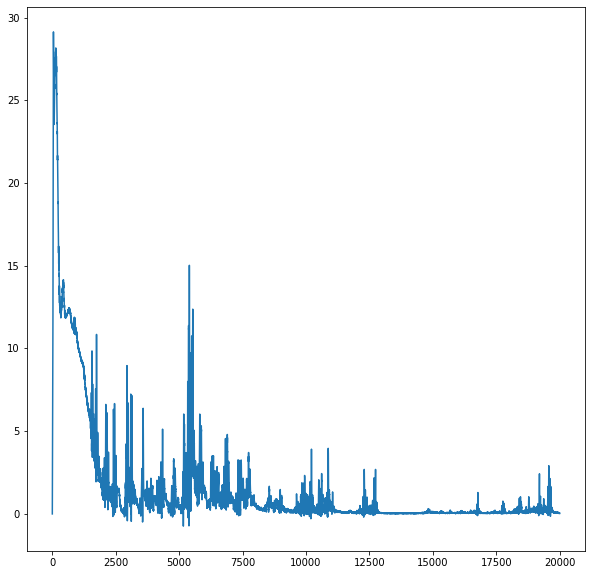

In [43]:
fig = plt.figure(figsize=(10, 10))
plt.plot(losses);

In [44]:
import numpy as np

X = np.linspace(-3, 3, 30)
Y = np.linspace(-3, 3, 30)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device)
grad_field = score_net(grid_tensor)
grad_field_np = grad_field.detach().cpu().numpy()
grad_field_np = grad_field_np[0]

RuntimeError: mat1 dim 1 must match mat2 dim 0

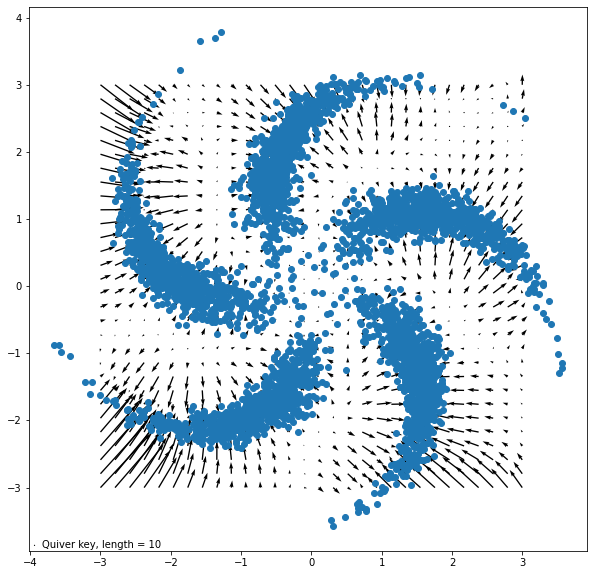

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))
q = ax.quiver(grid[..., 0], grid[..., 1], grad_field_np[..., 0], grad_field_np[..., 1])
ax.quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
sample_data = toy_data.inf_train_gen('pinwheel', n_points=4096)
ax.scatter(sample_data[:, 0], sample_data[:, 1])
plt.show()

<Figure size 720x720 with 0 Axes>

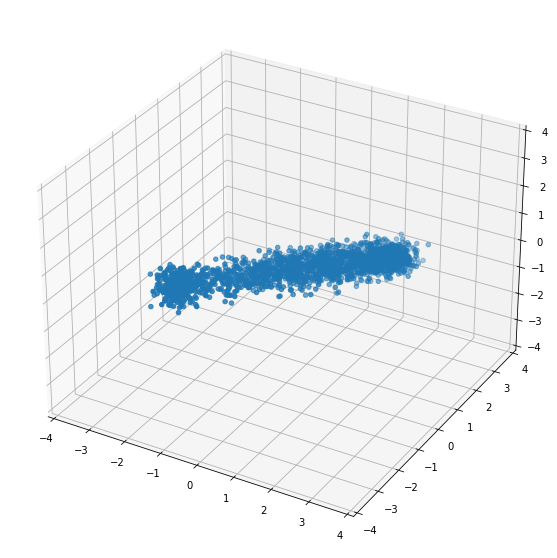

In [51]:
#x_final = langevin_dynamics_lsd(score_net, l=0.004, e=.05, num_points=2048)
x_final = langevin_dynamics_lsd_3d(score_net, l=0.001, e=.05, num_points=2048)
fig = plt.figure(figsize=(10, 10))
visualize(x_final)